# Imports and definitions

In [1]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns

from glob import glob
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.image import threshold_img, resample_to_img, binarize_img
from nilearn.glm import threshold_stats_img

In [2]:
from nilearn.masking import apply_mask
from scipy import stats

In [3]:
import statsmodels.api as sm
import pingouin as pg

from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp, ttest_rel

In [4]:
from nilearn import plotting, datasets, surface

# for plotting slices
mni152_template = datasets.load_mni152_template(resolution=1)
# for plotting on surface
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

[fetch_surf_fsaverage] Dataset found in /ihome/bchandrasekaran/krs228/nilearn_data/fsaverage


In [5]:
task_label = 'tonecat'
fwhm = 0.00
space_label = 'MNI152NLin2009cAsym'

# define data directories
bidsroot = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 
                        'FLT/',
                        'data_denoised', #'data_bids'
                       )
nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
masks_dir = os.path.join(nilearn_dir, 'masks')
# define first-level directory where group-level inputs will be pulled from
l1_dir = os.path.join(nilearn_dir, 'level-1_fwhm-%.02f'%fwhm)

# create output directory
group_out_dir = os.path.join(nilearn_dir, 'group_fwhm-%.02f'%fwhm)
if not os.path.exists(group_out_dir):
        os.makedirs(group_out_dir)

In [6]:
bidsroot

'/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised'

In [7]:
contrast_list = ['sound', 'resp', 'fb-correct-vs-wrong']

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [8]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27', # always leave out FLT27 – did not participate
               'sub-FLT07', # bad QA 11/14/23
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [9]:
print(participants_df)

   participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT05   26   M      Mandarin  3010.0
4       sub-FLT06   21   F  non-Mandarin  3001.0
5       sub-FLT08   23   F      Mandarin  2005.0
6       sub-FLT09   30   F  non-Mandarin  3002.0
7       sub-FLT10   23   F      Mandarin  2006.0
8       sub-FLT11   20   F  non-Mandarin  1005.0
9       sub-FLT12   20   F  non-Mandarin  3004.0
10      sub-FLT13   23   F  non-Mandarin  3005.0
11      sub-FLT14   23   M  non-Mandarin  3006.0
12      sub-FLT15   22   M      Mandarin  2010.0
13      sub-FLT17   29   F      Mandarin     NaN
14      sub-FLT18   24   M      Mandarin  2016.0
15      sub-FLT19   24   M      Mandarin  2018.0
16      sub-FLT20   26   F  non-Mandarin  3008.0
17      sub-FLT21   21   M      Mandarin  2011.0
18      sub-FLT22   41   F      Mandarin  2017.0
19      sub-FLT23   

In [10]:
participants_nman_df = participants_df[participants_df.group=='non-Mandarin'].reset_index(drop=True)
print(participants_nman_df)

   participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT04   21   F  non-Mandarin  1003.0
2       sub-FLT06   21   F  non-Mandarin  3001.0
3       sub-FLT09   30   F  non-Mandarin  3002.0
4       sub-FLT11   20   F  non-Mandarin  1005.0
5       sub-FLT12   20   F  non-Mandarin  3004.0
6       sub-FLT13   23   F  non-Mandarin  3005.0
7       sub-FLT14   23   M  non-Mandarin  3006.0
8       sub-FLT20   26   F  non-Mandarin  3008.0
9       sub-FLT25   19   F  non-Mandarin  1013.0
10      sub-FLT28   23   F  non-Mandarin     NaN
11      sub-FLT30   25   M  non-Mandarin     NaN


In [11]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [12]:
print(sub_list_nman)

['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25', 'sub-FLT28', 'sub-FLT30']


### Define region dictionary

In [13]:
region_dict = {'auditory': [
                        'L-HG', 'L-PT',  'L-PP', 
                        'L-STGp', 'L-STGa', 
                        'L-ParsOp', 'L-ParsTri',
                        'R-HG', 'R-PT',  'R-PP', 
                        'R-STGp', 'R-STGa', 
                        'R-ParsOp', 'R-ParsTri', 
                          ],
                'tian-S2': [
                    #'pGP-rh', 'pGP-lh',
                    #'aGP-rh', 'aGP-lh',
                    'aCAU-lh',
                    'pCAU-lh',
                    'aPUT-lh',
                    'pPUT-lh',
                    'NAc-shell-lh',
                    'NAc-core-lh',
                    'aCAU-rh',
                    'pCAU-rh',
                    'aPUT-rh',
                    'pPUT-rh',
                    'NAc-shell-rh',
                    'NAc-core-rh',
                    ],
                'tian-S3': [
                        'CAU-DA-lh', 'CAU-DA-rh', 
                        'CAU-VA-lh', 'CAU-VA-rh', 
                        'pCAU-lh', 'pCAU-rh', 
                        'PUT-DA-lh', 'PUT-DA-rh', 
                        'PUT-DP-lh', 'PUT-DP-rh', 
                        'PUT-VA-lh', 'PUT-VA-rh', 
                        'PUT-VP-lh', 'PUT-VP-rh',
                        'NAc-core-lh',  'NAc-core-rh', 
                        'NAc-shell-lh', 'NAc-shell-rh', 
                         #'aGP-lh', 'pGP-lh', 
                         #'aGP-rh', 'pGP-rh',         
                               ],
           }
network_list  = list(region_dict.keys())
print('network_list:', network_list)

network_list: ['auditory', 'tian-S2', 'tian-S3']


### define key processing functions

In [14]:
# mask stat maps
def mask_stat_maps(region_list, statmap_dict, masks_dir, network_name, space_label):
    roi_mean_dict = {}
    mask_path_list = []
    
    for rx, region in enumerate(region_list):
        print(region)
        roi_mean_list = []

        for sub_id in statmap_dict:
            stat_fpath = statmap_dict[sub_id]
            mask_fpath = glob(masks_dir + f'/{sub_id}/space-{space_label}/masks-{network_name}/*{region}*.nii.gz')[0]
            print(mask_fpath)
            #print(nib.load(mask_fpath).get_fdata().shape)
            
            mask_img = resample_to_img(mask_fpath, stat_fpath, 
                                       interpolation='nearest',
                                       force_resample=True, 
                                       copy_header=True)
            mask_img = binarize_img(mask_img, two_sided=False, copy_header=True)
            masked_data = apply_mask(stat_fpath, mask_img)
            roi_mean_sub = masked_data.mean()
            

            roi_mean_list.append(roi_mean_sub)

        # save mask_fpaths for later
        mask_path_list.append(mask_fpath)
        
        
        roi_mean_dict[region] = roi_mean_list
    
    return roi_mean_dict, mask_path_list

In [15]:
# create ROI dataframe from dictionary
def make_stats_df(roi_mean_dict, participants_df, network_name):
    roi_df = pd.DataFrame.from_dict(roi_mean_dict)

    roi_df['participant_id'] = participants_df.participant_id
    roi_df['participant_group'] = participants_df.group

    roi_df_long = roi_df.melt(id_vars=["participant_id", "participant_group"], 
                              var_name="region", value_name="beta")

    # create new `hemisphere` column
    if network_name == 'auditory':
        roi_df_long['region_hemi'] = roi_df_long.region
        roi_df_long['hemisphere'] = roi_df_long.region.str[0]
        roi_df_long['region'] = roi_df_long.region.str[2:]
    else: #if network_name == ('tian_subcortical_S3' or 'tian_subcortical_S2'):
        roi_df_long['region_hemi'] = roi_df_long.region
        roi_df_long['hemisphere'] = roi_df_long.region.str[-2:]
        roi_df_long['region'] = roi_df_long.region.str[:-3]

    # Filter for non-Mandarin participants
    #stats_df = roi_df_long[roi_df_long['participant_group'] == 'non-Mandarin']
    
    return roi_df_long # stats_df

In [16]:
# plot ROI box plots
def plot_roi_box_plots(stats_df):
    fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)
    yrange = [-6, 4.5]

    # Define a color palette
    #palette = ['#e66101', '#5e3c99']  # Example colors, adjust as needed

    # Create the swarm plot with transparent dots
    sns.stripplot(data=stats_df, 
                  x='region', y='beta', 
                  hue='hemisphere',
                  dodge=True,
                  linewidth=0.5,
                  size=3,
                  #alpha=0.6,
                  #palette=palette,  # Use the defined color palette
                  legend=None,
                  ax=ax,
                  zorder=2)  # Lower zorder for the strip plot

    # Make the swarm plot dots transparent
    for collection in ax.collections:
        collection.set_facecolor('none')

    # Create the box plot with colors
    sns.boxplot(data=stats_df, 
                x='region', y='beta', 
                hue='hemisphere',
                dodge=True,
                linewidth=1,
                fliersize=0,
                #palette=palette,  # Use the same color palette
                #legend=None,
                ax=ax,
                zorder=1)  # Higher zorder for the box plot

    #ax.set_ylim(yrange)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_title(f'{contrast_label}')

    # Extend the horizontal dashed line at y=0
    ax.axhline(y=0, color='0.5', linestyle='--', linewidth=0.5)

    fig.tight_layout()
    
    return fig

In [17]:
# plot ROI-mean values on the brain
def plot_roi_slices(roi_mean_dict, mask_path_list, network_name, space_label):
    from nilearn.image import new_img_like
    from nilearn import plotting

    roi_stat_data_list = []
    for rx, region in enumerate(roi_mean_dict):
        print('region:', region)
        mask_fpath = glob(masks_dir + f'/*/space-{space_label}/masks-{network_name}/*{region}*.nii.gz')[0]
        #mask_fpath = region
        #roi_img = nib.load(mask_fpath)
        #roi_data = roi_img.get_fdata()
        
        #roi_img = resample_to_img(mask_fpath, stat_fpath, 
        #                           interpolation='nearest',
        #                           force_resample=True, 
        #                           copy_header=True)
        roi_img = binarize_img(mask_fpath, two_sided=False)
        #roi_data = apply_mask(stat_fpath, roi_img)
        roi_data = roi_img.get_fdata()
        
        roi_stat = np.mean(roi_mean_dict[region])
        #roi_stat = roi_mean_dict.loc[roi_mean_dict['region_hemi'] == 'region', 'beta'].mean()
        roi_stat_data = roi_data * roi_stat

        roi_stat_data_list.append(roi_stat_data)
    
    # add maps together and make nifti img
    roi_stat_map_data = sum(roi_stat_data_list)
    roi_stat_map_img = new_img_like(roi_img, roi_stat_map_data)

    fig, ax = plt.subplots(figsize=(8,3), dpi=300)
    plotting.plot_stat_map(roi_stat_map_img,
                           bg_img=mni152_template,
                           black_bg=False,
                           annotate=False, draw_cross=False,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           axes=ax)
    #fig.suptitle(title);
    
    return fig

In [18]:
def plot_roi_slices_avg(roi_mean_dict_list, mask_path_list, network_name, space_label):
    from nilearn.image import new_img_like
    from nilearn import plotting

    roi_stat_data_list = []
    all_regions = roi_mean_dict_list[0].keys()  # assumes all dicts share the same regions

    for region in all_regions:
        print('region:', region)
        mask_fpath = glob(masks_dir + f'/*/space-{space_label}/masks-{network_name}/*{region}*.nii.gz')[0]
        roi_img = binarize_img(mask_fpath, two_sided=False)
        roi_data = roi_img.get_fdata()

        # Compute mean across all stages for this region
        roi_stat_values = [roi_dict[region] for roi_dict in roi_mean_dict_list]
        roi_stat = np.mean(roi_stat_values)

        roi_stat_data = roi_data * roi_stat
        roi_stat_data_list.append(roi_stat_data)

    # Combine all ROI maps
    roi_stat_map_data = sum(roi_stat_data_list)
    roi_stat_map_img = new_img_like(roi_img, roi_stat_map_data)

    fig, ax = plt.subplots(figsize=(8,3), dpi=300)
    plotting.plot_stat_map(roi_stat_map_img,
                           bg_img=mni152_template,
                           black_bg=False,
                           annotate=False, draw_cross=False,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           axes=ax)
    
    return fig


In [19]:
def plot_roi_slices_diff(roi_mean_dict_stage1, roi_mean_dict_stage2, mask_path_list, network_name, space_label):
    from nilearn.image import new_img_like
    from nilearn import plotting

    roi_stat_data_list = []
    all_regions = roi_mean_dict_stage1.keys()  # assumes both dicts share the same regions

    for region in all_regions:
        print('region:', region)
        mask_fpath = glob(masks_dir + f'/*/space-{space_label}/masks-{network_name}/*{region}*.nii.gz')[0]
        roi_img = binarize_img(mask_fpath, two_sided=False)
        roi_data = roi_img.get_fdata()

        # Compute difference between stages
        roi_stat_stage1 = np.mean(roi_mean_dict_stage1[region])
        roi_stat_stage2 = np.mean(roi_mean_dict_stage2[region])
        roi_stat_diff = roi_stat_stage2 - roi_stat_stage1


        roi_stat_data = roi_data * roi_stat_diff
        roi_stat_data_list.append(roi_stat_data)

    # Combine all ROI maps
    roi_stat_map_data = sum(roi_stat_data_list)
    roi_stat_map_img = new_img_like(roi_img, roi_stat_map_data)

    fig, ax = plt.subplots(figsize=(8,3), dpi=300)
    plotting.plot_stat_map(roi_stat_map_img,
                           bg_img=mni152_template,
                           black_bg=False,
                           annotate=False, draw_cross=False,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           axes=ax)
    
    return fig


# `grouped_runs`: Early vs. middle vs. final runs (thirds)

## `contrast-sound` for striatal network

In [18]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[1]
contrast_label = contrast_list[0]

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

In [19]:
participants_nman_df.participant_id.unique()

array(['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11',
       'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25',
       'sub-FLT28', 'sub-FLT30'], dtype=object)

In [20]:
region_dict[network_name]

['aCAU-lh',
 'pCAU-lh',
 'aPUT-lh',
 'pPUT-lh',
 'NAc-shell-lh',
 'NAc-core-lh',
 'aCAU-rh',
 'pCAU-rh',
 'aPUT-rh',
 'pPUT-rh',
 'NAc-shell-rh',
 'NAc-core-rh']

In [21]:
glob(masks_dir + f'/sub-FLT02/space-{space_label}/masks-*S2/*PUT*')

['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT02_space-MNI152NLin2009cAsym_mask-aPUT-lh.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT02_space-MNI152NLin2009cAsym_mask-pPUT-rh.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT02_space-MNI152NLin2009cAsym_mask-aPUT-rh.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT02_space-MNI152NLin2009cAsym_mask-pPUT-lh.nii.gz']

In [22]:
statmap_earlythird_dict['sub-FLT02']

'/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT02_space-MNI152NLin2009cAsym/grouped_runs/earlythird/sub-FLT02_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz'

In [25]:
print(f'masking {contrast_label} stat maps for the {network_name} network')

print(f'creating dictionary for early learning stage')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

print(f'creating dictionary for middle learning stage')
roi_middlethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_middlethird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

print(f'creating dictionary for final learning stage')
roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

masking sound stat maps for the tian-S2 network
creating dictionary for early learning stage
aCAU-lh
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT02_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT04/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT04_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT06/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT06_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT09/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT09_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT11/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT11_space-MNI152NLin2009cAsym

In [26]:
# add `learning_stage` column and combine into single dataframe
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_nman_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_middlethird_df_long = make_stats_df(roi_middlethird_mean_dict, participants_nman_df, network_name)
roi_middlethird_df_long['learning_stage'] = 'middle'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_nman_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_middlethird_df_long, roi_latethird_df_long],)

In [27]:
roi_earlythird_df_long.columns

Index(['participant_id', 'participant_group', 'region', 'beta', 'region_hemi',
       'hemisphere', 'learning_stage'],
      dtype='object')

In [28]:
roi_df_long.participant_id.unique()

array(['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11',
       'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25',
       'sub-FLT28', 'sub-FLT30'], dtype=object)

In [45]:
print(network_name)
non_mandarin_df = roi_df_long.copy()

# create a new column based on rostral–caudal axis
non_mandarin_df['Axis'] = ''

if network_name == 'tian-S3':
    non_mandarin_df.loc[(non_mandarin_df['region']=='pCAU'),   'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='PUT-VP'), 'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='PUT-DP'), 'Axis'] = 'Caudal'

    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-DA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-VA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-DP', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-VP', 'Axis'] = 'Rostral'

    non_mandarin_df.loc[non_mandarin_df['region']=='PUT-VA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='PUT-DA', 'Axis'] = 'Rostral'

    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-shell', 'Axis'] = 'Ventral'
    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-core', 'Axis'] = 'Ventral'

elif network_name == 'tian-S2':
    non_mandarin_df.loc[(non_mandarin_df['region']=='pCAU'), 'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='pPUT'), 'Axis'] = 'Caudal'    
    
    non_mandarin_df.loc[(non_mandarin_df['region']=='aCAU'), 'Axis'] = 'Rostral'
    non_mandarin_df.loc[(non_mandarin_df['region']=='aPUT'), 'Axis'] = 'Rostral'    

    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-shell', 'Axis'] = 'Ventral'
    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-core', 'Axis'] = 'Ventral'

non_mandarin_df.head()

tian-S2


participant_id participant_group region      beta region_hemi hemisphere  \
0      sub-FLT02      non-Mandarin   aCAU  0.311762     aCAU-lh         lh   
1      sub-FLT04      non-Mandarin   aCAU  6.639905     aCAU-lh         lh   
2      sub-FLT06      non-Mandarin   aCAU  2.195999     aCAU-lh         lh   
3      sub-FLT09      non-Mandarin   aCAU  6.193708     aCAU-lh         lh   
4      sub-FLT11      non-Mandarin   aCAU  2.443195     aCAU-lh         lh   

  learning_stage     Axis  
0          early  Rostral  
1          early  Rostral  
2          early  Rostral  
3          early  Rostral  
4          early  Rostral

In [46]:
non_mandarin_df.region_hemi.unique()

array(['aCAU-lh', 'pCAU-lh', 'aPUT-lh', 'pPUT-lh', 'NAc-shell-lh',
       'NAc-core-lh', 'aCAU-rh', 'pCAU-rh', 'aPUT-rh', 'pPUT-rh',
       'NAc-shell-rh', 'NAc-core-rh'], dtype=object)

In [47]:
non_mandarin_df.participant_id.unique()

array(['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11',
       'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25',
       'sub-FLT28', 'sub-FLT30'], dtype=object)

In [48]:
roi_earlythird_mean_dict

{'aCAU-lh': [0.3117616851747771,
  6.639904820354088,
  2.1959991644916452,
  6.193707702031219,
  2.443195486821008,
  2.8972806675383076,
  -1.1198396325231699,
  4.168678112055015,
  1.9343560828325517,
  1.8644260062875508,
  2.865138146572995,
  4.659762324830282],
 'pCAU-lh': [0.03663031556699579,
  9.726810146965523,
  0.03738020826516198,
  6.691358367942123,
  2.6733342076686295,
  -0.2202859917481682,
  -1.2258988287254358,
  6.730932130278987,
  3.535427463518687,
  3.1906075481214176,
  1.403298242200978,
  8.569074952736539],
 'aPUT-lh': [3.938304741106591,
  5.392301986284355,
  3.2194526892595015,
  10.339491720833477,
  4.01596296009053,
  4.585784110189911,
  7.027865495029831,
  11.583854395699905,
  3.0698347877117342,
  3.5959071254826167,
  4.711486858238983,
  6.421832692510481],
 'pPUT-lh': [3.6350622883527928,
  5.034317401464273,
  1.502602056969844,
  3.964207415214333,
  3.1458371343957627,
  1.0909272793612812,
  3.9017681945036604,
  5.830174316861266,
  0.

region: aCAU-lh


/scratch/slurm-6464360/ipykernel_166919/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: pCAU-lh
region: aPUT-lh
region: pPUT-lh
region: NAc-shell-lh
region: NAc-core-lh
region: aCAU-rh
region: pCAU-rh
region: aPUT-rh
region: pPUT-rh
region: NAc-shell-rh
region: NAc-core-rh


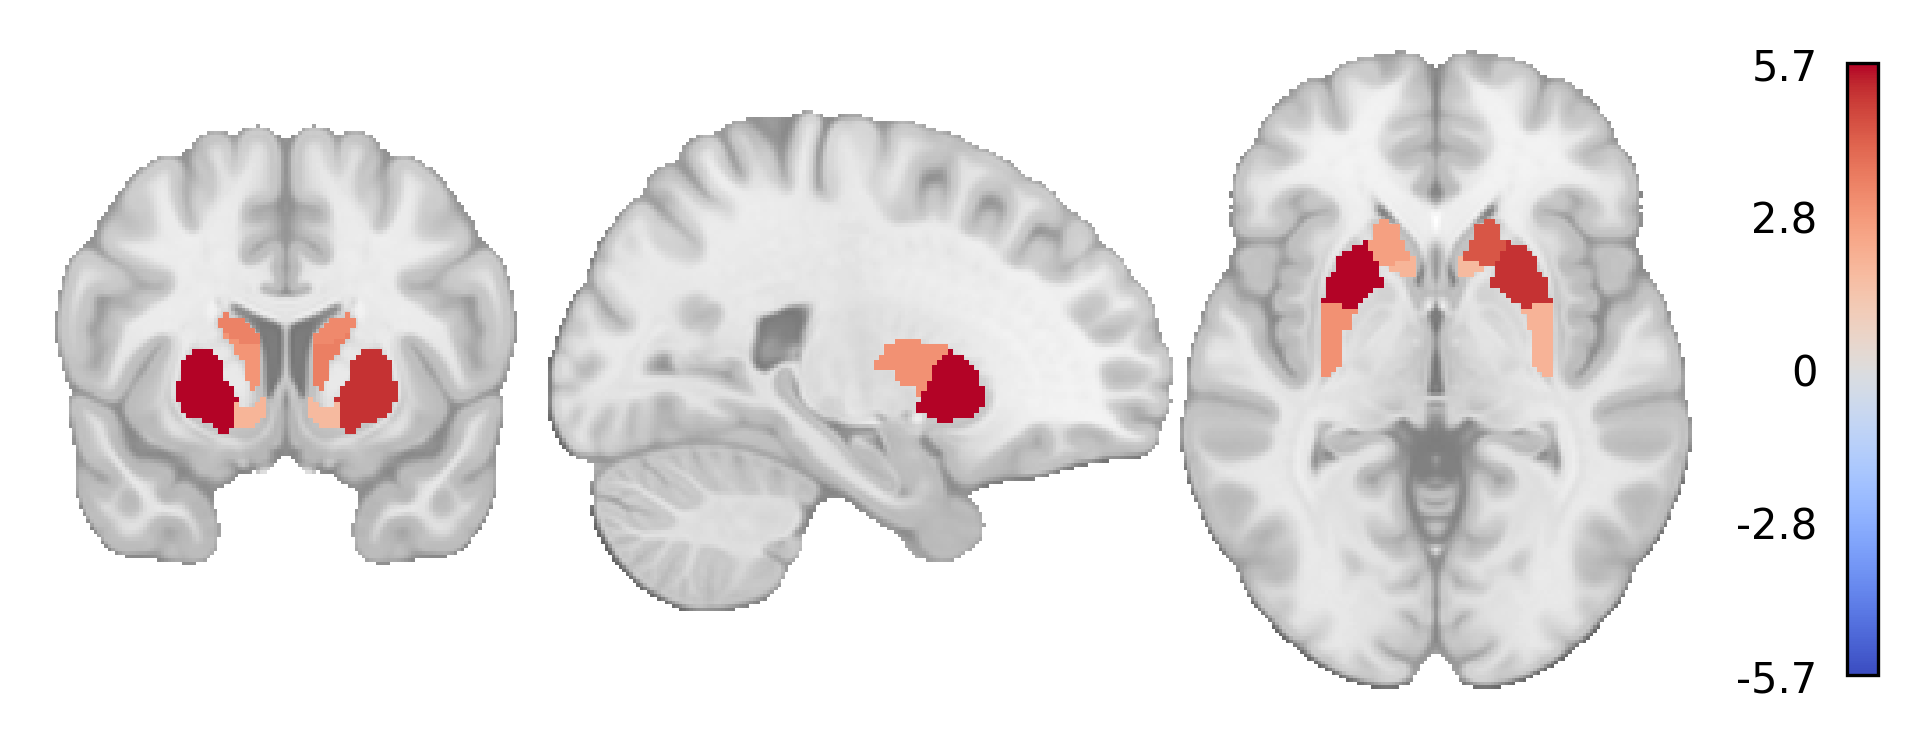

In [34]:
fig = plot_roi_slices(roi_earlythird_mean_dict, mask_path_list, network_name, space_label)

region: aCAU-lh


/scratch/slurm-6464360/ipykernel_166919/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: pCAU-lh
region: aPUT-lh
region: pPUT-lh
region: NAc-shell-lh
region: NAc-core-lh
region: aCAU-rh
region: pCAU-rh
region: aPUT-rh
region: pPUT-rh
region: NAc-shell-rh
region: NAc-core-rh


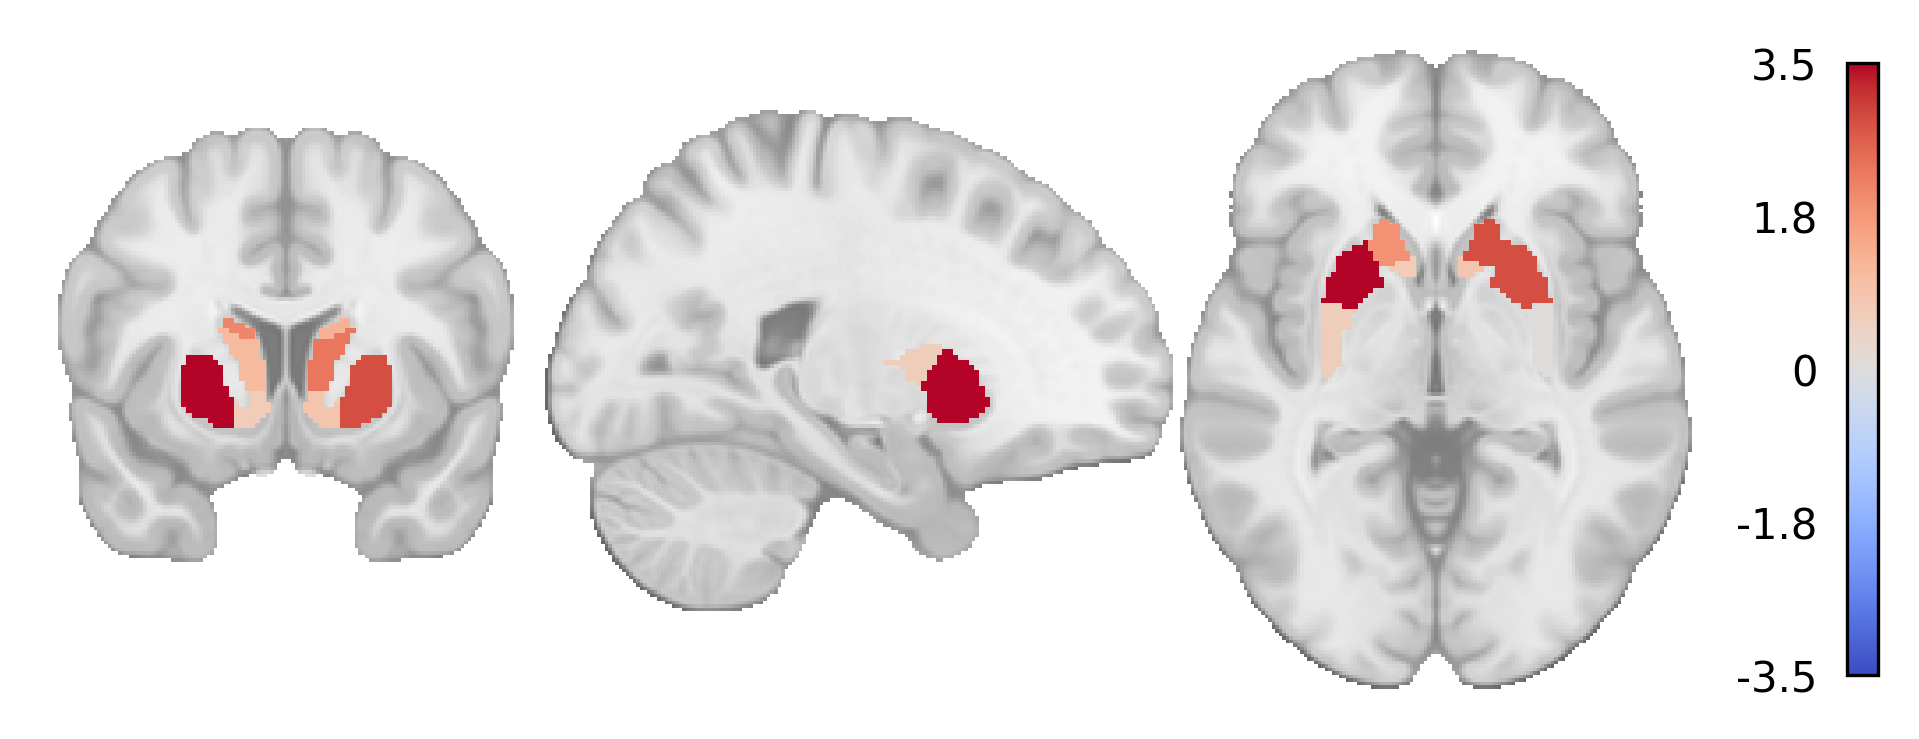

In [35]:
fig = plot_roi_slices(roi_middlethird_mean_dict, mask_path_list, network_name, space_label)

region: aCAU-lh


/scratch/slurm-6464360/ipykernel_166919/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: pCAU-lh
region: aPUT-lh
region: pPUT-lh
region: NAc-shell-lh
region: NAc-core-lh
region: aCAU-rh
region: pCAU-rh
region: aPUT-rh
region: pPUT-rh
region: NAc-shell-rh
region: NAc-core-rh


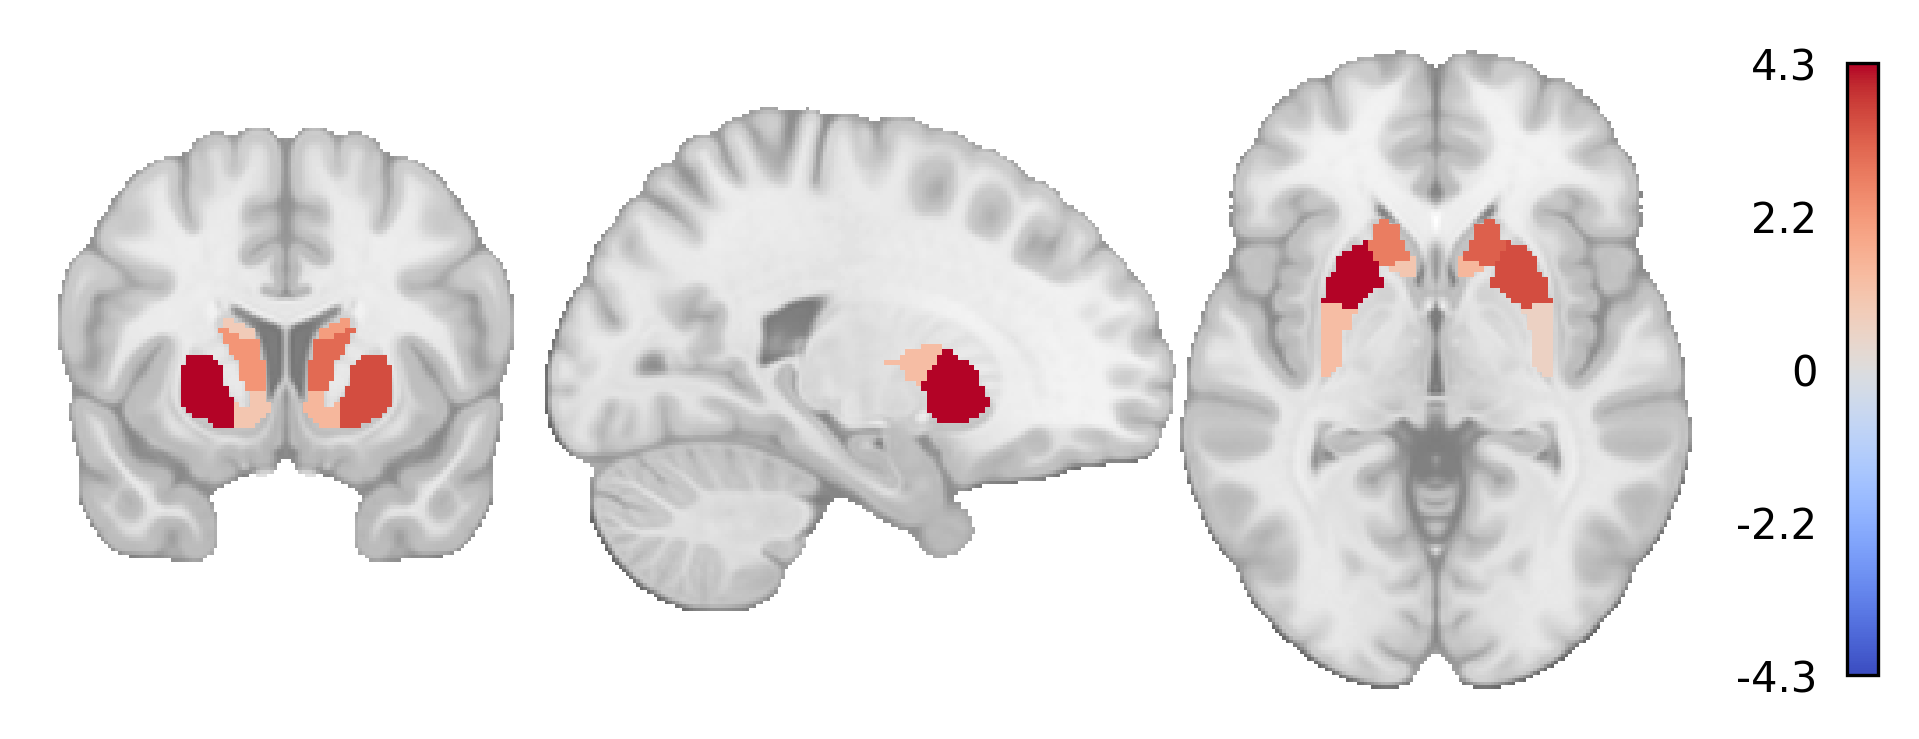

In [36]:
fig = plot_roi_slices(roi_latethird_mean_dict, mask_path_list, network_name, space_label)

In [49]:
plot_order = ['aCAU', 'pCAU', 'aPUT', 'pPUT', 'NAc-core', 'NAc-shell', ]

/scratch/slurm-6464360/ipykernel_166919/2807131526.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


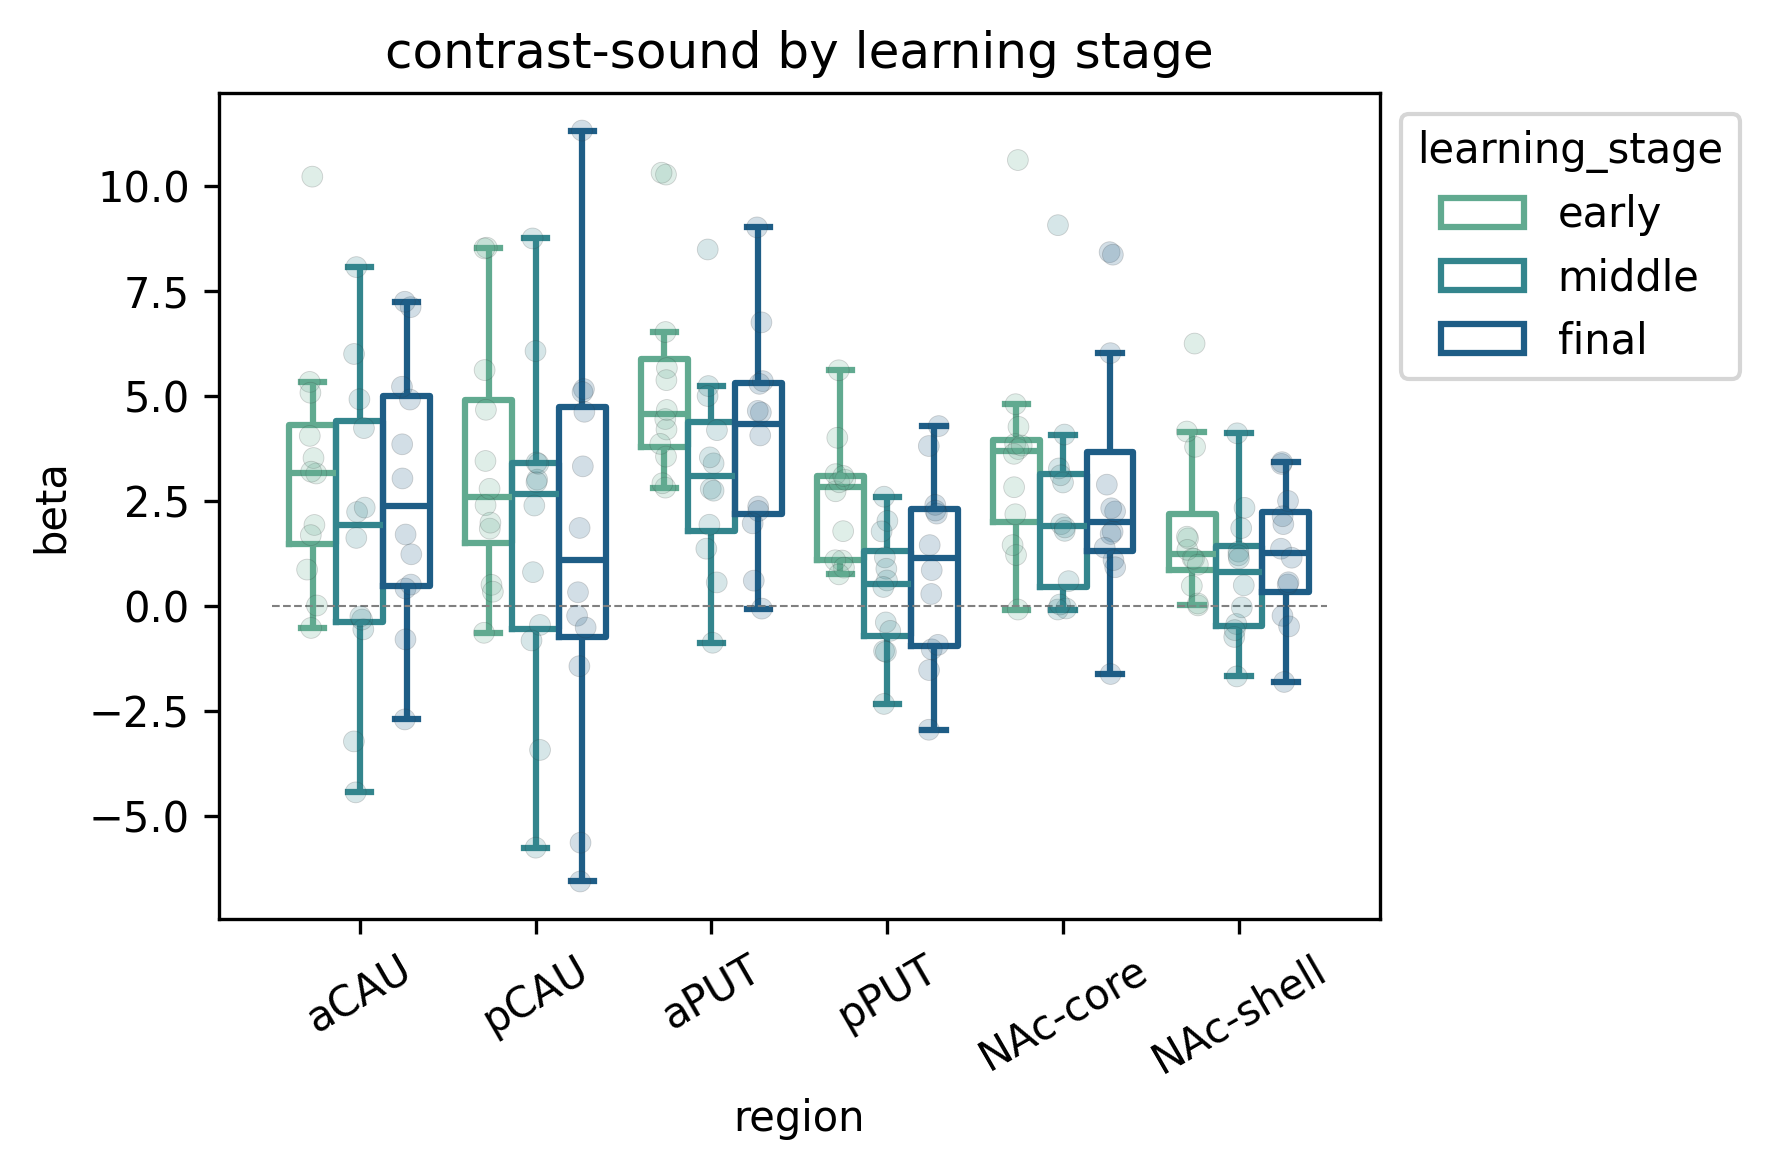

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by learning stage');
#ax.set_ylim([-5, 5])

fig.tight_layout()


/scratch/slurm-6464360/ipykernel_166919/3935233491.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


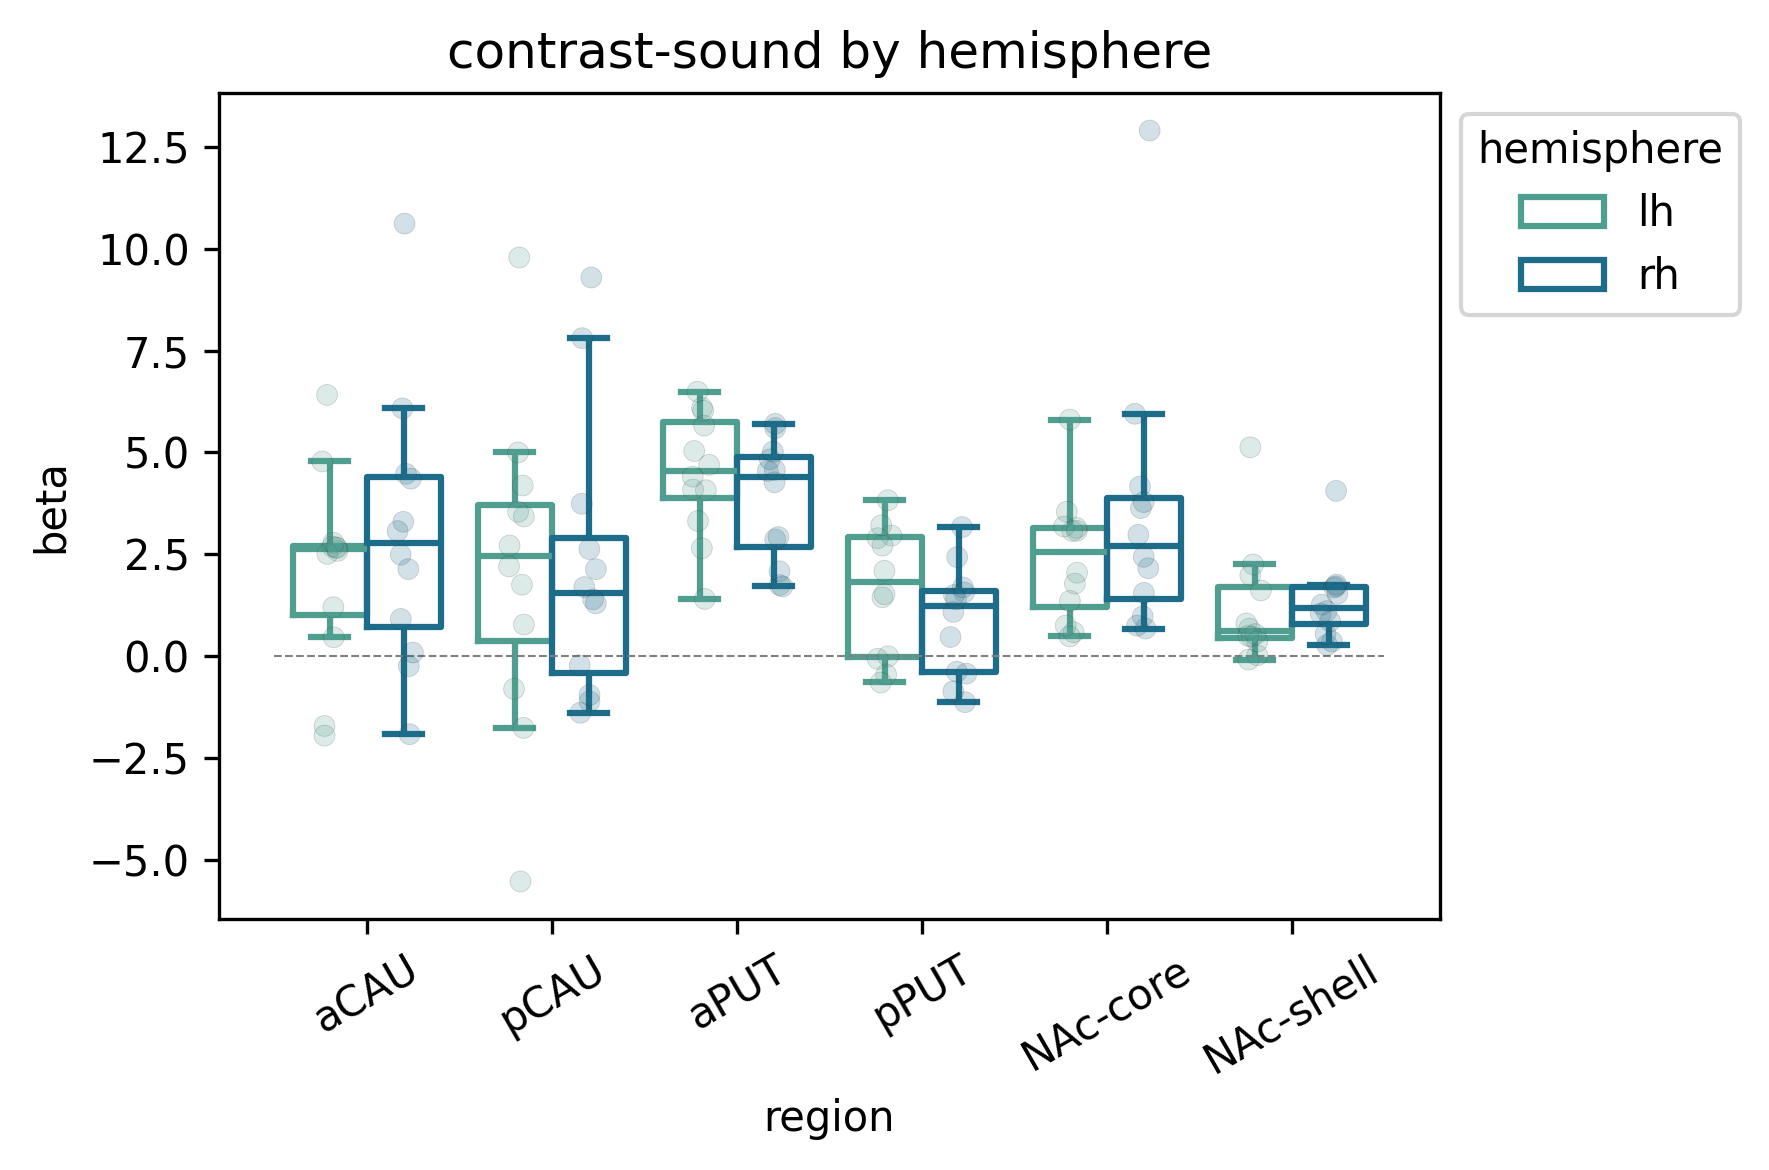

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'hemisphere'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by hemisphere');
#ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [52]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

In [53]:
non_mandarin_df.head()

participant_id participant_group region      beta region_hemi hemisphere  \
0      sub-FLT02      non-Mandarin   aCAU  0.311762     aCAU-lh         lh   
1      sub-FLT04      non-Mandarin   aCAU  6.639905     aCAU-lh         lh   
2      sub-FLT06      non-Mandarin   aCAU  2.195999     aCAU-lh         lh   
3      sub-FLT09      non-Mandarin   aCAU  6.193708     aCAU-lh         lh   
4      sub-FLT11      non-Mandarin   aCAU  2.443195     aCAU-lh         lh   

  learning_stage     Axis  
0          early  Rostral  
1          early  Rostral  
2          early  Rostral  
3          early  Rostral  
4          early  Rostral

In [54]:
non_mandarin_df.participant_id.unique()

array(['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11',
       'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25',
       'sub-FLT28', 'sub-FLT30'], dtype=object)

In [55]:
# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','Axis', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
aov.summary()

network: tian-S2
contrast: sound


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/stats/anova.py:508: FutureWarning: The provided callable <function mean at 0x7fbc901ac4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  self.data = (self.data
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Anova
============================================================
                               F Value Num DF  Den DF Pr > F
------------------------------------------------------------
hemisphere                      0.2742 1.0000 11.0000 0.6109
learning_stage                  3.3291 2.0000 22.0000 0.0546
Axis                           11.3689 2.0000 22.0000 0.0004
hemisphere:learning_stage       0.1518 2.0000 22.0000 0.8600
hemisphere:Axis                 3.1736 2.0000 22.0000 0.0615
learning_stage:Axis             1.2106 4.0000 44.0000 0.3199
hemisphere:learning_stage:Axis  1.6678 4.0000 44.0000 0.1745
============================================================

"""

In [56]:
# pairwise by Axis

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['hemisphere','Axis', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'hemisphere','A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'hemisphere', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast hemisphere        A        B         T   dof     p-unc  \
0  hemisphere * Axis         lh   Caudal  Rostral -4.052569  11.0  0.001907   
1  hemisphere * Axis         lh   Caudal  Ventral  0.141364  11.0  0.890138   
2  hemisphere * Axis         lh  Rostral  Ventral  4.096615  11.0  0.001770   
3  hemisphere * Axis         rh   Caudal  Rostral -5.551809  11.0  0.000172   
4  hemisphere * Axis         rh   Caudal  Ventral -1.789402  11.0  0.101086   
5  hemisphere * Axis         rh  Rostral  Ventral  2.738664  11.0  0.019277   

     p-corr     BF10  
0  0.003814   23.257  
1  0.890138     0.29  
2  0.003814   24.766  
3  0.001034  180.172  
4  0.121304    0.981  
5  0.028916    3.491

In [57]:
# pairwise by Axis

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['Axis', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'Axis', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'Axis', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast     Axis   A   B         T   dof     p-unc    p-corr  \
0  Axis * hemisphere   Caudal  lh  rh  0.978574  11.0  0.348822  0.523233   
1  Axis * hemisphere  Rostral  lh  rh -0.290219  11.0  0.777047  0.777047   
2  Axis * hemisphere  Ventral  lh  rh -1.886260  11.0  0.085924  0.257771   

    BF10  
0  0.429  
1  0.298  
2  1.104

In [58]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['Axis', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
#pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-unc'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast Contrast        A        B         T   dof     p-unc    p-corr  \
0     Axis     Axis   Caudal  Rostral -5.582431  11.0  0.000165  0.000494   
1     Axis     Axis   Caudal  Ventral -0.951683  11.0  0.361701  0.361701   
2     Axis     Axis  Rostral  Ventral  3.666448  11.0  0.003713  0.005569   

      BF10  
0  187.439  
1     0.42  
2   13.345

In [59]:
# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
aov.summary()

network: tian-S2
contrast: sound


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Anova
================================================================
                                 F Value  Num DF  Den DF  Pr > F
----------------------------------------------------------------
hemisphere                        0.2742  1.0000  11.0000 0.6109
learning_stage                    3.3291  2.0000  22.0000 0.0546
region                            5.9006  5.0000  55.0000 0.0002
hemisphere:learning_stage         0.1518  2.0000  22.0000 0.8600
hemisphere:region                 3.0660  5.0000  55.0000 0.0164
learning_stage:region             0.7085 10.0000 110.0000 0.7148
hemisphere:learning_stage:region  1.1783 10.0000 110.0000 0.3132
================================================================

"""

In [60]:
# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['hemisphere','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'hemisphere', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'hemisphere', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast hemisphere          A          B         T   dof  \
0  hemisphere * region         lh   NAc-core  NAc-shell  3.388173  11.0   
1  hemisphere * region         lh   NAc-core       aPUT -4.891869  11.0   
2  hemisphere * region         lh  NAc-shell       aPUT -6.257106  11.0   
3  hemisphere * region         lh       aCAU       aPUT -3.529814  11.0   
4  hemisphere * region         lh       aPUT       pPUT  9.260379  11.0   
5  hemisphere * region         rh  NAc-shell       aPUT -5.209293  11.0   
6  hemisphere * region         rh       aPUT       pPUT  8.294622  11.0   

      p-unc    p-corr       BF10  
0  0.006054  0.025947      8.914  
1  0.000478  0.002867     75.068  
2  0.000062  0.000620    436.949  
3  0.004716  0.023582     10.948  
4  0.000002  0.000048  1.102e+04  
5  0.000290  0.002177    115.008  
6  0.000005  0.000069   4264.287

In [61]:
# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast     region   A   B         T   dof     p-unc    p-corr  \
0  region * hemisphere   NAc-core  lh  rh -1.646028  11.0  0.128001  0.217182   
1  region * hemisphere  NAc-shell  lh  rh -0.732916  11.0  0.478937  0.574725   
2  region * hemisphere       aCAU  lh  rh -1.569683  11.0  0.144788  0.217182   
3  region * hemisphere       aPUT  lh  rh  2.638011  11.0  0.023075  0.069225   
4  region * hemisphere       pCAU  lh  rh -0.129931  11.0  0.898966  0.898966   
5  region * hemisphere       pPUT  lh  rh  4.394612  11.0  0.001073  0.006436   

     BF10  
0   0.828  
1   0.361  
2   0.759  
3   3.027  
4    0.29  
5  37.754

In [62]:
# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'learning_stage', 'A', 'B', 'Paired', 'Parametric', 'T',
       'dof', 'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast learning_stage          A          B         T  \
0  learning_stage * region          early   NAc-core  NAc-shell  3.512838   
1  learning_stage * region          early  NAc-shell       aPUT -4.484958   
2  learning_stage * region          early       aPUT       pPUT  5.529661   
3  learning_stage * region          final  NAc-shell       aPUT -4.502989   
4  learning_stage * region          final       aPUT       pPUT  4.246067   
5  learning_stage * region         middle  NAc-shell       aPUT -3.589181   
6  learning_stage * region         middle       aPUT       pPUT  7.410972   

    dof     p-unc    p-corr      BF10  
0  11.0  0.004859  0.031238    10.682  
1  11.0  0.000924  0.010393    42.845  
2  11.0  0.000178  0.004008   175.081  
3  11.0  0.000897  0.010393    43.936  
4  11.0  0.001375  0.012373    30.622  
5  11.0  0.004250  0.031238    11.933  
6  11.0  0.000013  0.000604  1667.267

In [63]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast    region      A       B         T   dof  \
1   region * learning_stage  NAc-core  early  middle  2.288006  11.0   
15  region * learning_stage      pPUT  early   final  2.696646  11.0   
16  region * learning_stage      pPUT  early  middle  4.043303  11.0   

       p-unc    p-corr    BF10  
1   0.042928  0.257567   1.864  
15  0.020781  0.187028   3.289  
16  0.001938  0.034876  22.951

In [64]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-unc'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast Contrast          A          B         T   dof         p-unc  \
0    region   region   NAc-core  NAc-shell  3.250552  11.0  7.727639e-03   
4    region   region   NAc-core       pPUT  2.786608  11.0  1.769356e-02   
6    region   region  NAc-shell       aPUT -6.112342  11.0  7.602772e-05   
9    region   region       aCAU       aPUT -2.324049  11.0  4.028937e-02   
12   region   region       aPUT       pCAU  2.366273  11.0  3.739730e-02   
13   region   region       aPUT       pPUT  9.751255  11.0  9.503448e-07   

      p-corr       BF10  
0   0.038638      7.299  
4   0.066351      3.738  
6   0.000570    365.851  
9   0.100723      1.958  
12  0.100723      2.074  
13  0.000014  1.736e+04

In [65]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
#pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-unc'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast        Contrast      A       B         T   dof     p-unc  \
0  learning_stage  learning_stage  early   final  1.394267  11.0  0.190759   
1  learning_stage  learning_stage  early  middle  2.560120  11.0  0.026513   
2  learning_stage  learning_stage  final  middle  1.133608  11.0  0.281061   

     p-corr   BF10  
0  0.281061  0.628  
1  0.079539  2.713  
2  0.281061  0.489

#### Collapse (average) over non-significant factors

In [66]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})


In [67]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region_stage, data in roi_df_collapsed.groupby(["region",'learning_stage']):
    #print(region_stage)
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region_stage[0], region_stage[1], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, stage: {stage}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: NAc-core, stage: early, t = 4.59; corrected p = 0.0031
Region: NAc-core, stage: final, t = 3.34; corrected p = 0.0132
Region: NAc-core, stage: middle, t = 3.24; corrected p = 0.0141
Region: NAc-shell, stage: early, t = 3.45; corrected p = 0.0122
Region: NAc-shell, stage: final, t = 2.62; corrected p = 0.0358
Region: NAc-shell, stage: middle, t = 1.63; corrected p = 0.1769
Region: aCAU, stage: early, t = 3.85; corrected p = 0.0070
Region: aCAU, stage: final, t = 2.93; corrected p = 0.0225
Region: aCAU, stage: middle, t = 1.60; corrected p = 0.1769
Region: aPUT, stage: early, t = 7.35; corrected p = 0.0003
Region: aPUT, stage: final, t = 5.18; corrected p = 0.0018
Region: aPUT, stage: middle, t = 4.54; corrected p = 0.0031
Region: pCAU, stage: early, t = 3.85; corrected p = 0.0070
Region: pCAU, stage: final, t = 1.01; corrected p = 0.3542
Region: pCAU, stage: middle, t = 1.48; corrected p = 0.1997
Region: pPUT, stage: early, t = 5.97; corrected p = 0.0008
Region: pPUT, stage: fin

In [68]:
# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: NAc-core, t = 6.50; corrected p = 0.0000
Region: NAc-shell, t = 4.47; corrected p = 0.0001
Region: aCAU, t = 4.69; corrected p = 0.0001
Region: aPUT, t = 9.51; corrected p = 0.0000
Region: pCAU, t = 3.22; corrected p = 0.0028
Region: pPUT, t = 3.88; corrected p = 0.0005


### Make 3D plots

In [43]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region_hemi"], 
                                       as_index=False).agg({"beta": "mean"})

# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region_hemi"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: CAU-DA-lh, t = 2.71; corrected p = 0.0283
Region: CAU-DA-rh, t = 2.64; corrected p = 0.0293
Region: CAU-VA-lh, t = 2.88; corrected p = 0.0229
Region: CAU-VA-rh, t = 3.33; corrected p = 0.0120
Region: NAc-core-lh, t = 5.40; corrected p = 0.0008
Region: NAc-core-rh, t = 3.62; corrected p = 0.0081
Region: NAc-shell-lh, t = 2.87; corrected p = 0.0229
Region: NAc-shell-rh, t = 4.70; corrected p = 0.0017
Region: PUT-DA-lh, t = 9.63; corrected p = 0.0000
Region: PUT-DA-rh, t = 7.60; corrected p = 0.0000
Region: PUT-DP-lh, t = 5.16; corrected p = 0.0009
Region: PUT-DP-rh, t = 4.26; corrected p = 0.0030
Region: PUT-VA-lh, t = 9.52; corrected p = 0.0000
Region: PUT-VA-rh, t = 9.02; corrected p = 0.0000
Region: PUT-VP-lh, t = 1.83; corrected p = 0.1005
Region: PUT-VP-rh, t = 0.45; corrected p = 0.6630
Region: pCAU-lh, t = 1.92; corrected p = 0.0908
Region: pCAU-rh, t = 2.25; corrected p = 0.0547


In [44]:
region_list = region_dict[network_name]

mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [71]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('Reds') # 'coolwarm'

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        yaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        zaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    #title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_network-{network_name}_surface.svg')
clear_output()

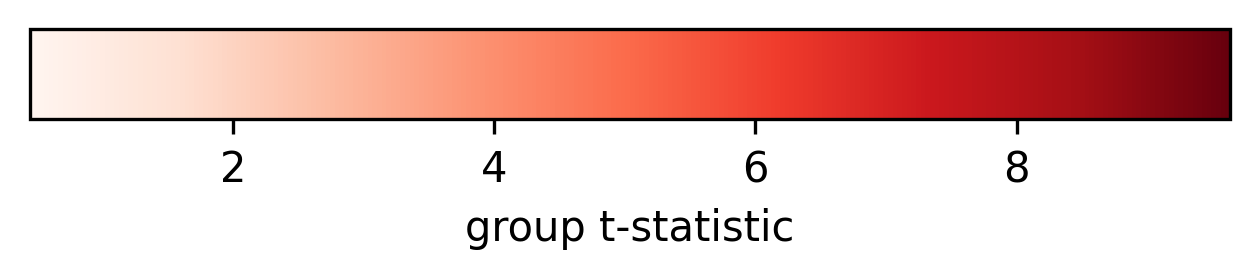

In [64]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
#cbar.ax.get_yaxis().labelpad = 15
plt.savefig(f"out-figure_group-all_contrast-{contrast_label}_network-{network_name}_colorbar.svg")

## `contrast-sound` for cortical network

In [18]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[0]
contrast_label = contrast_list[0]
print('network_name:', network_name)
print('contrast_label:', contrast_label)

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

network_name: auditory
contrast_label: sound


In [21]:
print(f'masking {contrast_label} stat maps for the {network_name} network')

print(f'creating dictionary for early learning stage')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

print(f'creating dictionary for middle learning stage')
roi_middlethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_middlethird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

print(f'creating dictionary for final learning stage')
roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

masking sound stat maps for the auditory network
creating dictionary for early learning stage
L-HG
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT02_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT04/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT04_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT06/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT06_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT09/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT09_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT11/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchan

In [22]:
# add `learning_stage` column and combine into single dataframe
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_nman_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_middlethird_df_long = make_stats_df(roi_middlethird_mean_dict, participants_nman_df, network_name)
roi_middlethird_df_long['learning_stage'] = 'middle'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_nman_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_middlethird_df_long, roi_latethird_df_long],)

In [23]:
non_mandarin_df = roi_df_long

region: L-HG


/scratch/slurm-6601185/ipykernel_4086458/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: L-PT
region: L-PP
region: L-STGp
region: L-STGa
region: L-ParsOp
region: L-ParsTri
region: R-HG
region: R-PT
region: R-PP
region: R-STGp
region: R-STGa
region: R-ParsOp
region: R-ParsTri


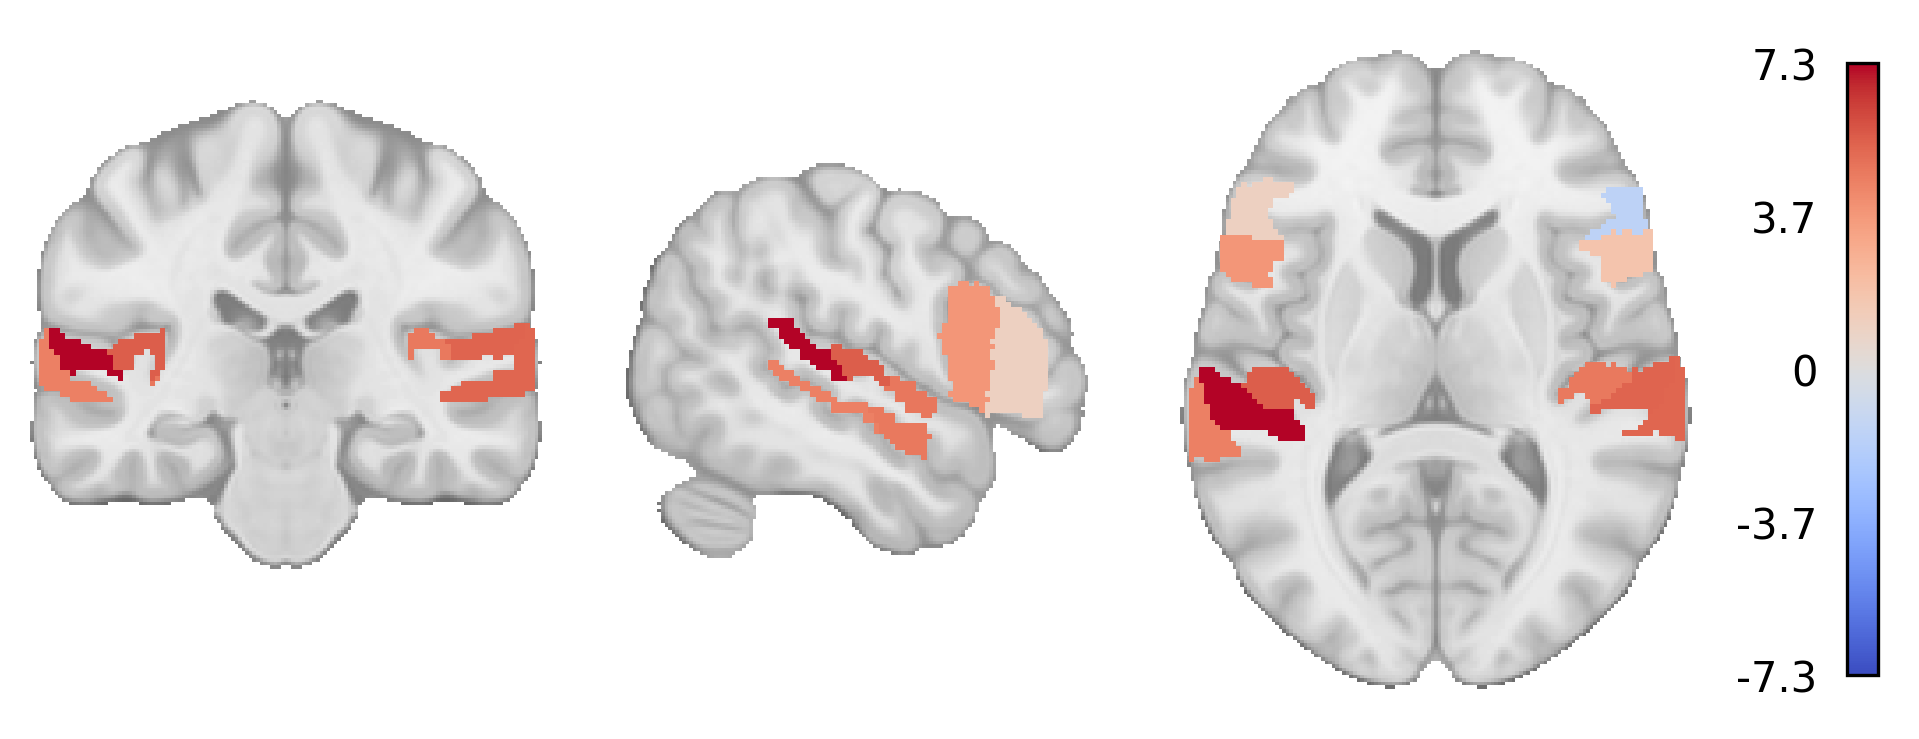

In [48]:
fig = plot_roi_slices(roi_earlythird_mean_dict, mask_path_list, 'dseg', space_label)

region: L-HG


/scratch/slurm-6601185/ipykernel_4086458/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: L-PT
region: L-PP
region: L-STGp
region: L-STGa
region: L-ParsOp
region: L-ParsTri
region: R-HG
region: R-PT
region: R-PP
region: R-STGp
region: R-STGa
region: R-ParsOp
region: R-ParsTri


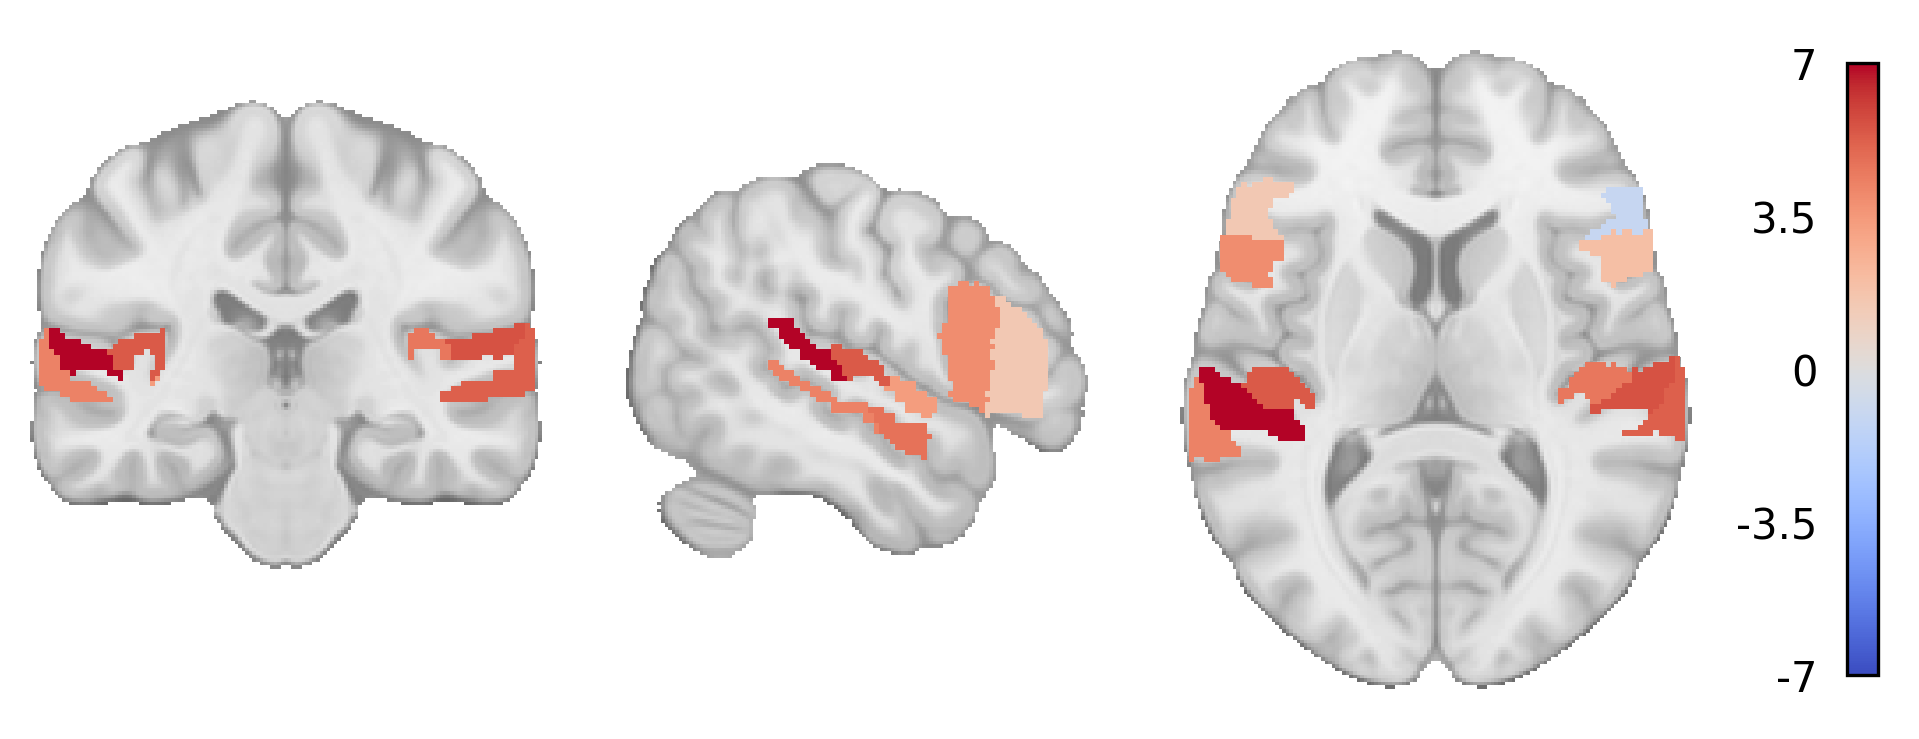

In [49]:
fig = plot_roi_slices(roi_middlethird_mean_dict, mask_path_list, 'dseg', space_label)

region: L-HG


/scratch/slurm-6601185/ipykernel_4086458/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: L-PT
region: L-PP
region: L-STGp
region: L-STGa
region: L-ParsOp
region: L-ParsTri
region: R-HG
region: R-PT
region: R-PP
region: R-STGp
region: R-STGa
region: R-ParsOp
region: R-ParsTri


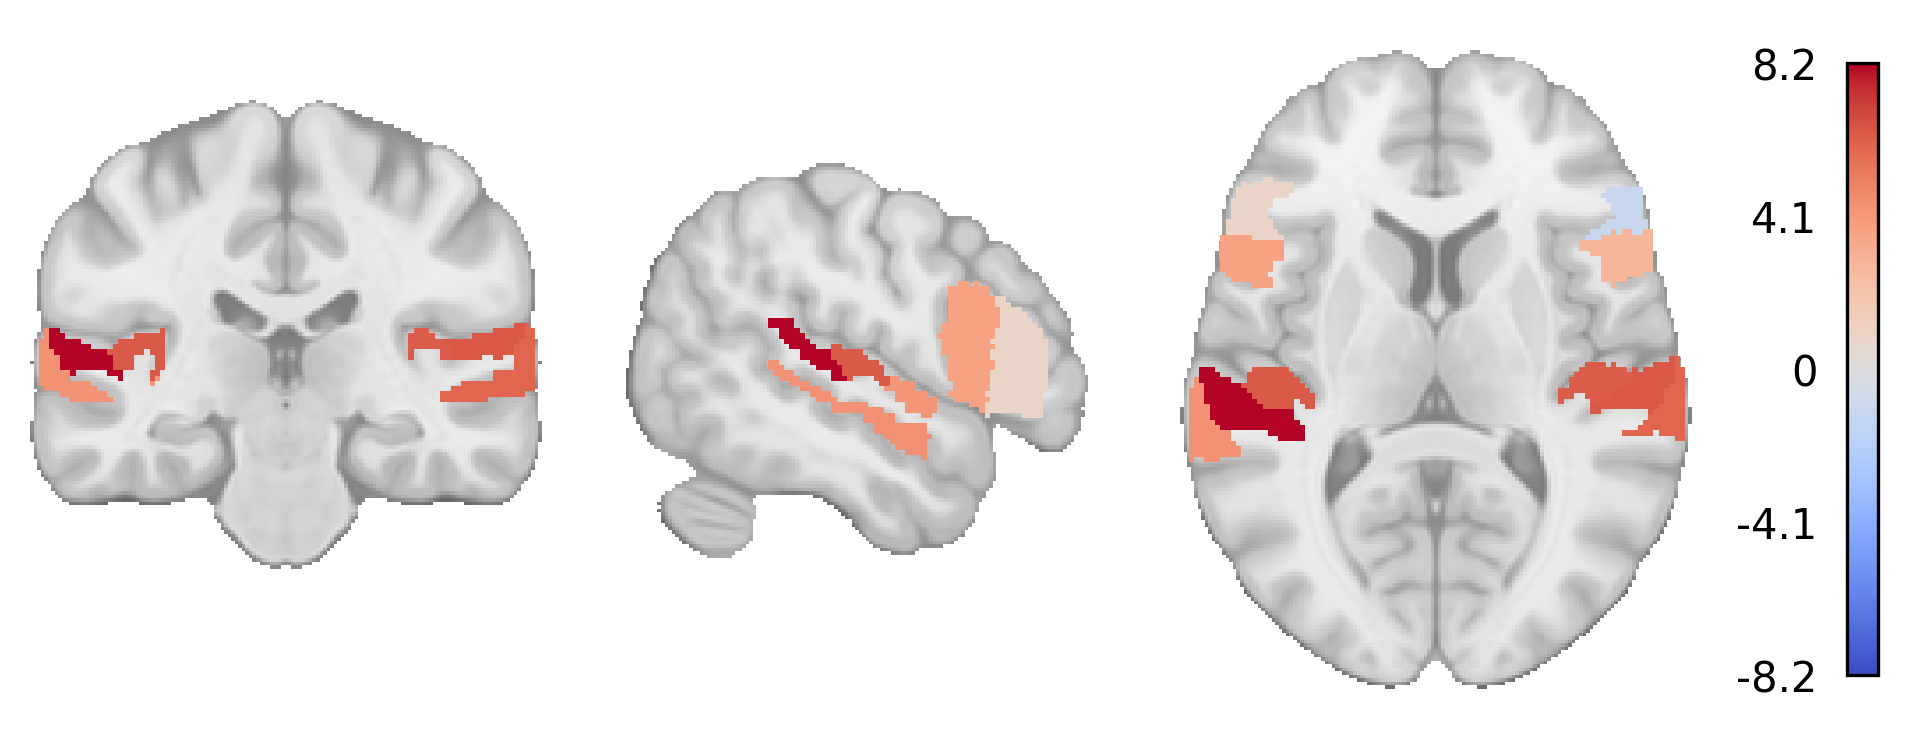

In [50]:
fig = plot_roi_slices(roi_latethird_mean_dict, mask_path_list, 'dseg', space_label)

In [30]:
plot_order = ['HG', 'PT', 'PP', 'STGp', 'STGa', 'ParsOp', 'ParsTri', ]

/scratch/slurm-6601185/ipykernel_4086458/2807131526.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


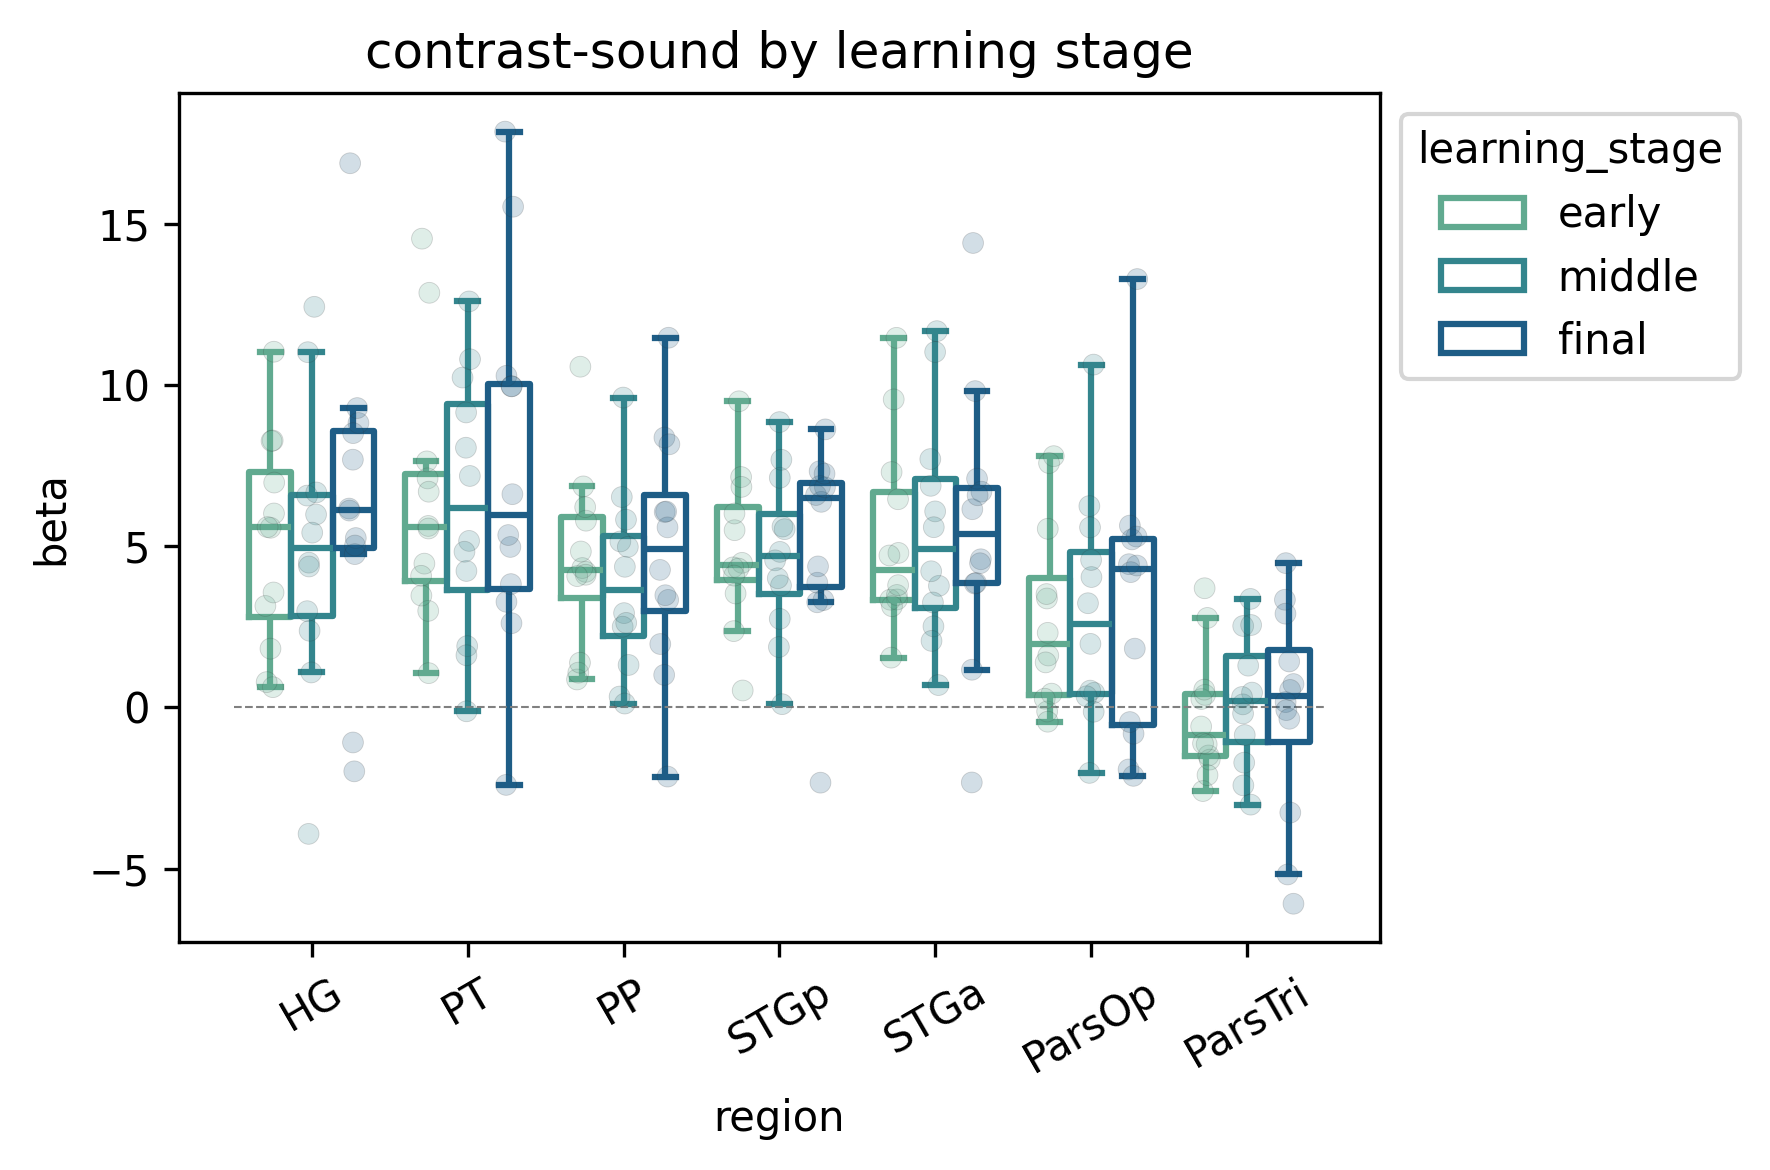

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by learning stage');
#ax.set_ylim([-5, 5])

fig.tight_layout()


/scratch/slurm-6601185/ipykernel_4086458/3935233491.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


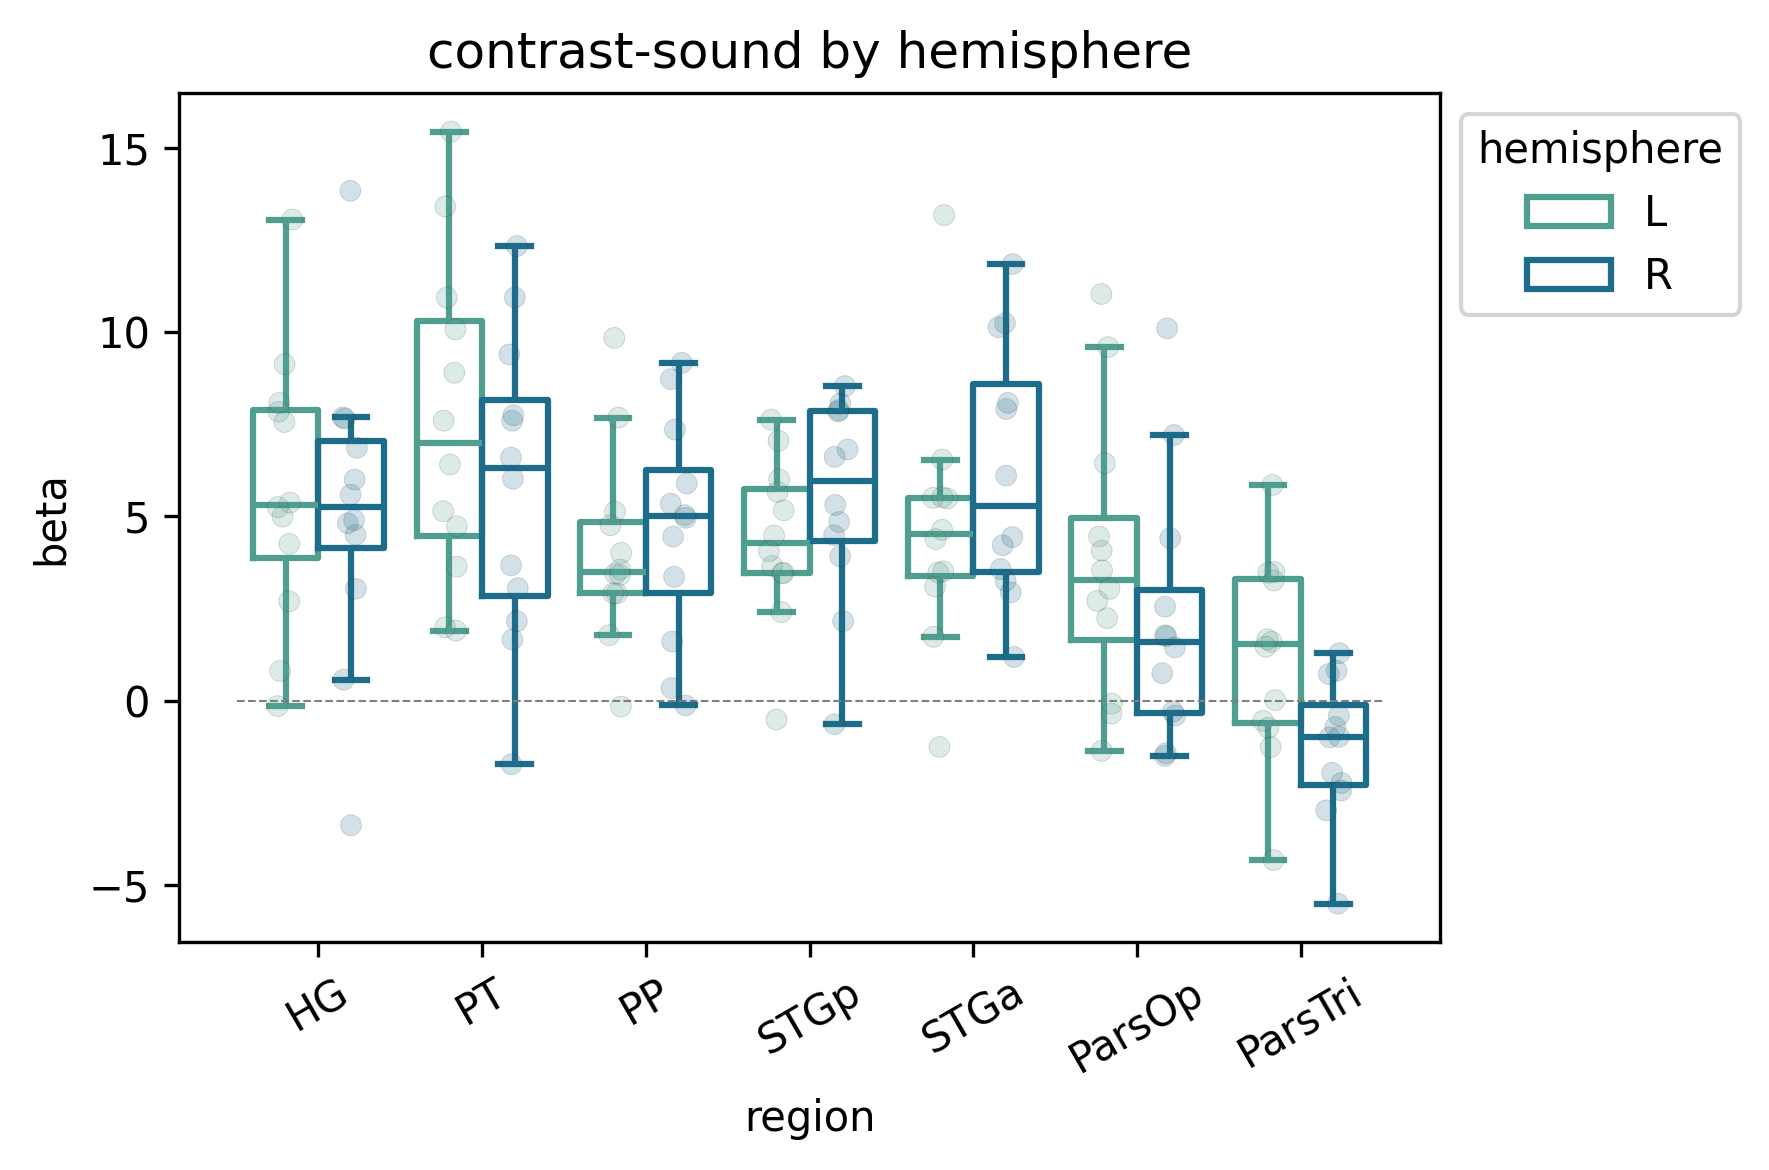

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'hemisphere'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by hemisphere');
#ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [33]:
# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
print(aov)


network: auditory
contrast: sound
                             Anova
                                 F Value  Num DF  Den DF  Pr > F
----------------------------------------------------------------
hemisphere                        2.1057  1.0000  11.0000 0.1747
learning_stage                    0.5528  2.0000  22.0000 0.5831
region                           15.2165  6.0000  66.0000 0.0000
hemisphere:learning_stage         4.0239  2.0000  22.0000 0.0324
hemisphere:region                 5.6363  6.0000  66.0000 0.0001
learning_stage:region             0.5524 12.0000 132.0000 0.8762
hemisphere:learning_stage:region  0.4041 12.0000 132.0000 0.9599



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [34]:
aov.summary().tables[0]

F Value  Num DF  Den DF        Pr > F
hemisphere                         2.105728     1.0    11.0  1.746623e-01
learning_stage                     0.552782     2.0    22.0  5.831321e-01
region                            15.216543     6.0    66.0  7.471695e-11
hemisphere:learning_stage          4.023930     2.0    22.0  3.241160e-02
hemisphere:region                  5.636293     6.0    66.0  9.019190e-05
learning_stage:region              0.552410    12.0   132.0  8.761834e-01
hemisphere:learning_stage:region   0.404070    12.0   132.0  9.599465e-01

In [35]:
import pingouin as pg

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['hemisphere','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'hemisphere', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'hemisphere', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast hemisphere        A        B         T   dof  \
0   hemisphere * region          L       HG       PT -3.032347  11.0   
1   hemisphere * region          L       HG  ParsTri  4.084457  11.0   
2   hemisphere * region          L       PP       PT -4.870349  11.0   
3   hemisphere * region          L       PP  ParsTri  3.982441  11.0   
4   hemisphere * region          L       PT   ParsOp  3.205826  11.0   
5   hemisphere * region          L       PT  ParsTri  5.443918  11.0   
6   hemisphere * region          L       PT     STGa  2.940474  11.0   
7   hemisphere * region          L       PT     STGp  3.706068  11.0   
8   hemisphere * region          L   ParsOp  ParsTri  3.508359  11.0   
9   hemisphere * region          L  ParsTri     STGa -4.572417  11.0   
10  hemisphere * region          L  ParsTri     STGp -3.880390  11.0   
11  hemisphere * region          R       HG  ParsTri  4.612920  11.0   
12  hemisphere * region          R       PP  ParsTri  7.211662  11.0   
13  hemisphere * region          R       PT   ParsOp  3.494900  11.0   
14  hemisphere * region          R       PT  ParsTri  6.612382  11.0   
15  hemisphere * region          R   ParsOp  ParsTri  3.606424  11.0   
16  hemisphere * region          R   ParsOp     STGa -4.116993  11.0   
17  hemisphere * region          R   ParsOp     STGp -3.721635  11.0   
18  hemisphere * region          R  ParsTri     STGa -8.389776  11.0   
19  hemisphere * region          R  ParsTri     STGp -9.863913  11.0   

           p-unc    p-corr       BF10  
0   1.140141e-02  0.025203      5.321  
1   1.806465e-03  0.007587      24.34  
2   4.944335e-04  0.003461     72.903  
3   2.149808e-03  0.008208     21.038  
4   8.367453e-03  0.019524      6.841  
5   2.026947e-04  0.001703    156.618  
6   1.343634e-02  0.028216      4.661  
7   3.464797e-03  0.010394     14.132  
8   4.897718e-03  0.012390     10.613  
9   8.002070e-04  0.004201     48.394  
10  2.561643e-03  0.008966     18.171  
11  7.489695e-04  0.004201      51.19  
12  1.726603e-05  0.000242   1335.524  
13  5.015107e-03  0.012390     10.408  
14  3.799533e-05  0.000399    669.443  
15  4.123285e-03  0.011545     12.234  
16  1.709389e-03  0.007587     25.495  
17  3.372171e-03  0.010394     14.454  
18  4.143723e-06  0.000087   4698.524  
19  8.476366e-07  0.000036  1.922e+04

In [36]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'hemisphere',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast   region  A  B         T   dof     p-unc    p-corr  \
0  region * hemisphere       HG  L  R  0.828055  11.0  0.425240  0.425240   
1  region * hemisphere       PP  L  R -1.071343  11.0  0.306958  0.358118   
2  region * hemisphere       PT  L  R  2.948979  11.0  0.013234  0.046317   
3  region * hemisphere   ParsOp  L  R  1.716370  11.0  0.114084  0.159718   
4  region * hemisphere  ParsTri  L  R  3.523001  11.0  0.004773  0.033412   
5  region * hemisphere     STGa  L  R -2.096809  11.0  0.059930  0.104878   
6  region * hemisphere     STGp  L  R -2.261990  11.0  0.044935  0.104848   

     BF10  
0   0.384  
1   0.463  
2   4.718  
3   0.899  
4  10.841  
5   1.445  
6     1.8

In [37]:

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['hemisphere','learning_stage', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'hemisphere', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'hemisphere', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast hemisphere      A       B         T   dof  \
0  hemisphere * learning_stage          L  early   final -0.111819  11.0   
1  hemisphere * learning_stage          L  early  middle  0.412077  11.0   
2  hemisphere * learning_stage          L  final  middle  0.520542  11.0   
3  hemisphere * learning_stage          R  early   final -1.518938  11.0   
4  hemisphere * learning_stage          R  early  middle -0.339562  11.0   
5  hemisphere * learning_stage          R  final  middle  1.146512  11.0   

      p-unc    p-corr   BF10  
0  0.912981  0.912981  0.289  
1  0.688199  0.888697  0.309  
2  0.613002  0.888697  0.323  
3  0.156984  0.827735  0.717  
4  0.740581  0.888697  0.302  
5  0.275912  0.827735  0.494

In [38]:

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','hemisphere', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'learning_stage', 'A', 'B', 'Paired', 'Parametric', 'T',
       'dof', 'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast learning_stage  A  B         T   dof     p-unc  \
0  learning_stage * hemisphere          early  L  R  2.412325  11.0  0.034472   
1  learning_stage * hemisphere          final  L  R -0.028438  11.0  0.977822   
2  learning_stage * hemisphere         middle  L  R  1.572542  11.0  0.144127   

     p-corr   BF10  
0  0.103417  2.209  
1  0.977822  0.287  
2  0.216190  0.761

In [39]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-unc'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast Contrast        A        B         T   dof     p-unc    p-corr  \
3    region   region       HG  ParsTri  4.714434  11.0  0.000635  0.002668   
6    region   region       PP       PT -3.878930  11.0  0.002568  0.006741   
8    region   region       PP  ParsTri  6.729290  11.0  0.000032  0.000197   
11   region   region       PT   ParsOp  3.705123  11.0  0.003471  0.008098   
12   region   region       PT  ParsTri  6.622560  11.0  0.000037  0.000197   
14   region   region       PT     STGp  2.450656  11.0  0.032208  0.067637   
15   region   region   ParsOp  ParsTri  4.431382  11.0  0.001009  0.003533   
16   region   region   ParsOp     STGa -3.904812  11.0  0.002456  0.006741   
17   region   region   ParsOp     STGp -2.359438  11.0  0.037851  0.072262   
18   region   region  ParsTri     STGa -7.492478  11.0  0.000012  0.000127   
19   region   region  ParsTri     STGp -8.124587  11.0  0.000006  0.000118   

        BF10  
3     58.892  
6     18.133  
8    768.164  
11    14.113  
12   677.546  
14     2.329  
15    39.752  
16     18.82  
17     2.054  
18  1823.611  
19  3578.825

#### Collapse (average) over non-significant factors

In [40]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'hemisphere'], 
                                       as_index=False).agg({"beta": "mean"})


In [43]:
# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region_stage, data in roi_df_collapsed.groupby(["region",'hemisphere']):
    #print(region_stage)
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region_stage[0], region_stage[1], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, hemisphere, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, stage: {hemisphere}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: HG, stage: L, t = 5.40; corrected p = 0.0004
Region: HG, stage: R, t = 4.30; corrected p = 0.0017
Region: PP, stage: L, t = 5.45; corrected p = 0.0004
Region: PP, stage: R, t = 5.40; corrected p = 0.0004
Region: PT, stage: L, t = 5.97; corrected p = 0.0003
Region: PT, stage: R, t = 4.84; corrected p = 0.0009
Region: ParsOp, stage: L, t = 3.47; corrected p = 0.0067
Region: ParsOp, stage: R, t = 2.17; corrected p = 0.0568
Region: ParsTri, stage: L, t = 1.48; corrected p = 0.1662
Region: ParsTri, stage: R, t = -2.33; corrected p = 0.0463
Region: STGa, stage: L, t = 4.74; corrected p = 0.0009
Region: STGa, stage: R, t = 6.24; corrected p = 0.0003
Region: STGp, stage: L, t = 6.93; corrected p = 0.0002
Region: STGp, stage: R, t = 6.93; corrected p = 0.0002


In [44]:
# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: HG, t = 6.93; corrected p = 0.0000
Region: PP, t = 7.78; corrected p = 0.0000
Region: PT, t = 7.66; corrected p = 0.0000
Region: ParsOp, t = 4.01; corrected p = 0.0006
Region: ParsTri, t = -0.11; corrected p = 0.9157
Region: STGa, t = 7.74; corrected p = 0.0000
Region: STGp, t = 9.70; corrected p = 0.0000


### Make 3D plots

In [78]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region_hemi"], 
                                       as_index=False).agg({"beta": "mean"})

# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region_hemi"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: L-HG, t = 5.40; corrected p = 0.0004
Region: L-PP, t = 5.45; corrected p = 0.0004
Region: L-PT, t = 5.97; corrected p = 0.0003
Region: L-ParsOp, t = 3.47; corrected p = 0.0067
Region: L-ParsTri, t = 1.48; corrected p = 0.1662
Region: L-STGa, t = 4.74; corrected p = 0.0009
Region: L-STGp, t = 6.93; corrected p = 0.0002
Region: R-HG, t = 4.30; corrected p = 0.0017
Region: R-PP, t = 5.40; corrected p = 0.0004
Region: R-PT, t = 4.84; corrected p = 0.0009
Region: R-ParsOp, t = 2.17; corrected p = 0.0568
Region: R-ParsTri, t = -2.33; corrected p = 0.0463
Region: R-STGa, t = 6.24; corrected p = 0.0003
Region: R-STGp, t = 6.93; corrected p = 0.0002


In [79]:
region_list = region_dict[network_name]

mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [80]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('Reds') # 'coolwarm'

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        yaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        zaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    #title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_network-{network_name}_surface.svg')
clear_output()

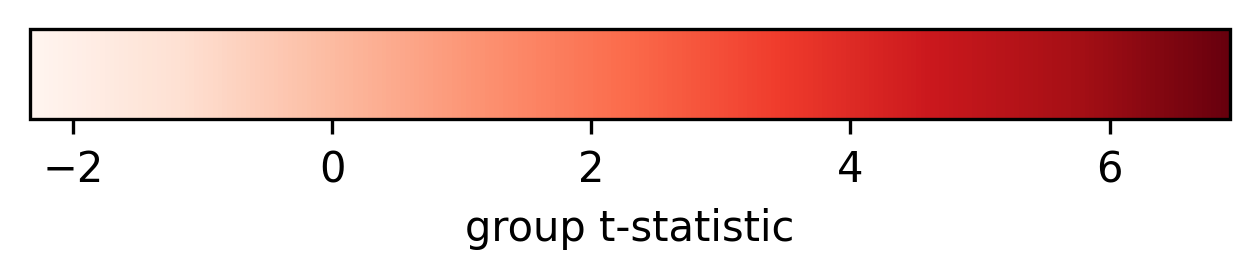

In [81]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
#cbar.ax.get_yaxis().labelpad = 15
plt.savefig(f"out-figure_group-all_contrast-{contrast_label}_network-{network_name}_colorbar.svg")

## `contrast-resp` for striatal network

In [69]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[1]
contrast_label = contrast_list[1]
print('network_name:', network_name)
print('contrast_label:', contrast_label)

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

network_name: tian-S2
contrast_label: resp


In [70]:
print(f'masking {contrast_label} stat maps for the {network_name} network')

print(f'creating dictionary for early learning stage')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

print(f'creating dictionary for middle learning stage')
roi_middlethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_middlethird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

print(f'creating dictionary for final learning stage')
roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

masking resp stat maps for the tian-S2 network
creating dictionary for early learning stage
aCAU-lh
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT02_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT04/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT04_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT06/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT06_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT09/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT09_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT11/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT11_space-MNI152NLin2009cAsym_

In [71]:
# add `learning_stage` column and combine into single dataframe
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_nman_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_middlethird_df_long = make_stats_df(roi_middlethird_mean_dict, participants_nman_df, network_name)
roi_middlethird_df_long['learning_stage'] = 'middle'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_nman_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_middlethird_df_long, roi_latethird_df_long],)

In [72]:
roi_df_long.participant_id.unique()

array(['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11',
       'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25',
       'sub-FLT28', 'sub-FLT30'], dtype=object)

In [73]:
non_mandarin_df = roi_df_long.copy()

# create a new column based on rostral–caudal axis
non_mandarin_df['Axis'] = ''

if network_name == 'tian-S3':
    non_mandarin_df.loc[(non_mandarin_df['region']=='pCAU'),   'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='PUT-VP'), 'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='PUT-DP'), 'Axis'] = 'Caudal'

    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-DA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-VA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-DP', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-VP', 'Axis'] = 'Rostral'

    non_mandarin_df.loc[non_mandarin_df['region']=='PUT-VA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='PUT-DA', 'Axis'] = 'Rostral'

    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-shell', 'Axis'] = 'Ventral'
    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-core', 'Axis'] = 'Ventral'

elif network_name == 'tian-S2':
    non_mandarin_df.loc[(non_mandarin_df['region']=='pCAU'), 'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='pPUT'), 'Axis'] = 'Caudal'    
    
    non_mandarin_df.loc[(non_mandarin_df['region']=='aCAU'), 'Axis'] = 'Rostral'
    non_mandarin_df.loc[(non_mandarin_df['region']=='aPUT'), 'Axis'] = 'Rostral'    

    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-shell', 'Axis'] = 'Ventral'
    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-core', 'Axis'] = 'Ventral'

non_mandarin_df.head()

participant_id participant_group region      beta region_hemi hemisphere  \
0      sub-FLT02      non-Mandarin   aCAU -0.742095     aCAU-lh         lh   
1      sub-FLT04      non-Mandarin   aCAU -1.773197     aCAU-lh         lh   
2      sub-FLT06      non-Mandarin   aCAU  2.438495     aCAU-lh         lh   
3      sub-FLT09      non-Mandarin   aCAU  1.729920     aCAU-lh         lh   
4      sub-FLT11      non-Mandarin   aCAU  1.082552     aCAU-lh         lh   

  learning_stage     Axis  
0          early  Rostral  
1          early  Rostral  
2          early  Rostral  
3          early  Rostral  
4          early  Rostral

In [74]:
non_mandarin_df.Axis.unique()

array(['Rostral', 'Caudal', 'Ventral'], dtype=object)

In [75]:
non_mandarin_df.participant_id.unique()

array(['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11',
       'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25',
       'sub-FLT28', 'sub-FLT30'], dtype=object)

region: aCAU-lh


/scratch/slurm-6464360/ipykernel_166919/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: pCAU-lh
region: aPUT-lh
region: pPUT-lh
region: NAc-shell-lh
region: NAc-core-lh
region: aCAU-rh
region: pCAU-rh
region: aPUT-rh
region: pPUT-rh
region: NAc-shell-rh
region: NAc-core-rh


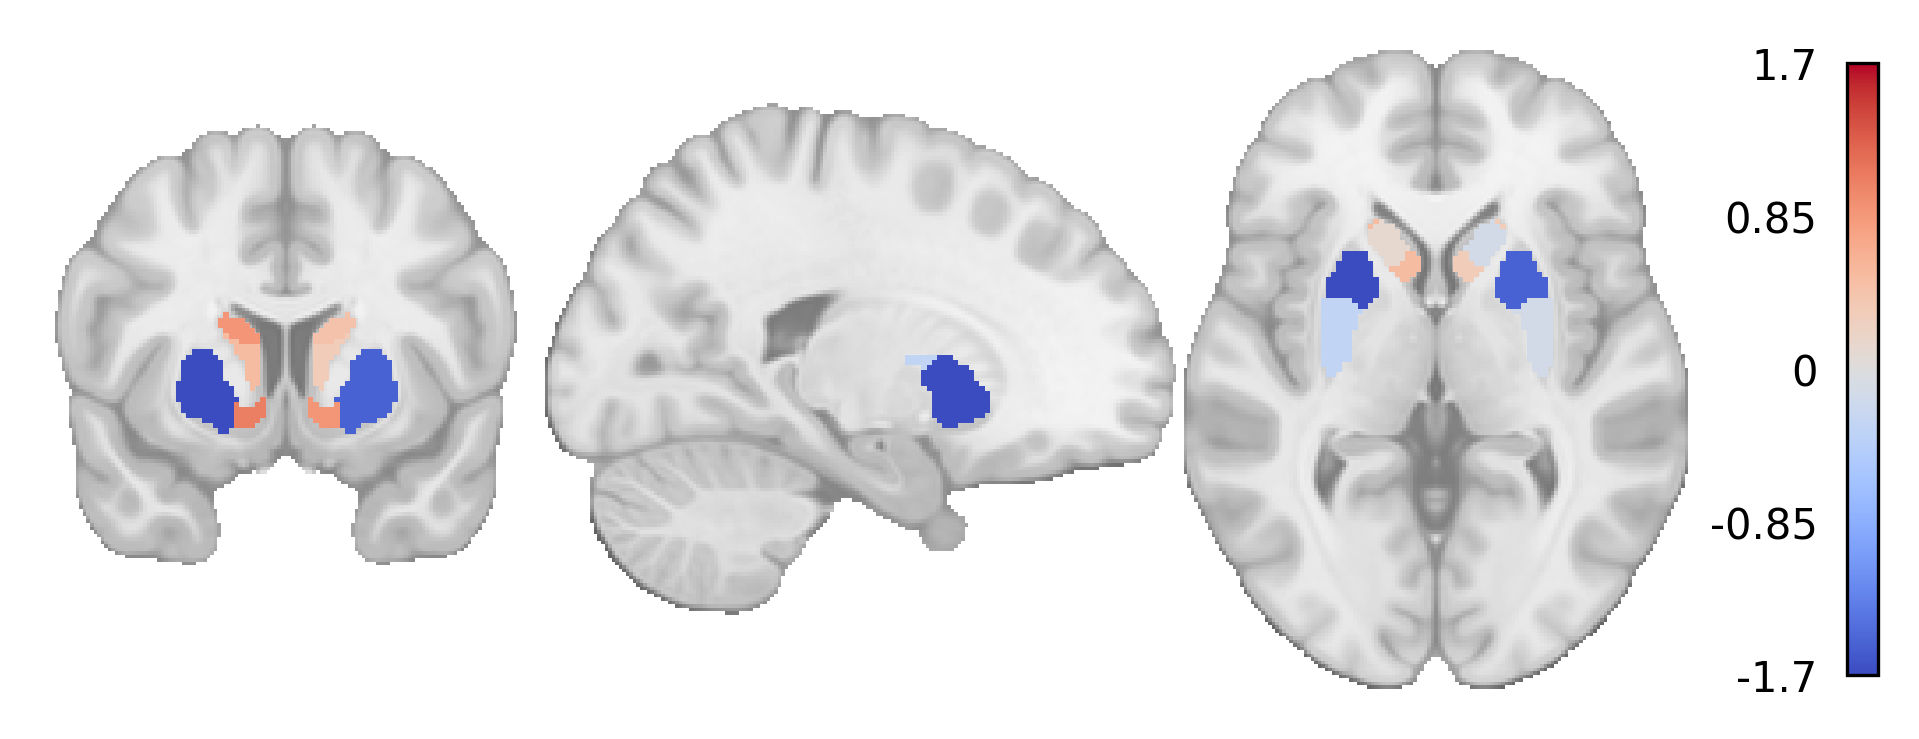

In [76]:
fig = plot_roi_slices(roi_earlythird_mean_dict, mask_path_list, network_name, space_label)

region: aCAU-lh


/scratch/slurm-6464360/ipykernel_166919/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: pCAU-lh
region: aPUT-lh
region: pPUT-lh
region: NAc-shell-lh
region: NAc-core-lh
region: aCAU-rh
region: pCAU-rh
region: aPUT-rh
region: pPUT-rh
region: NAc-shell-rh
region: NAc-core-rh


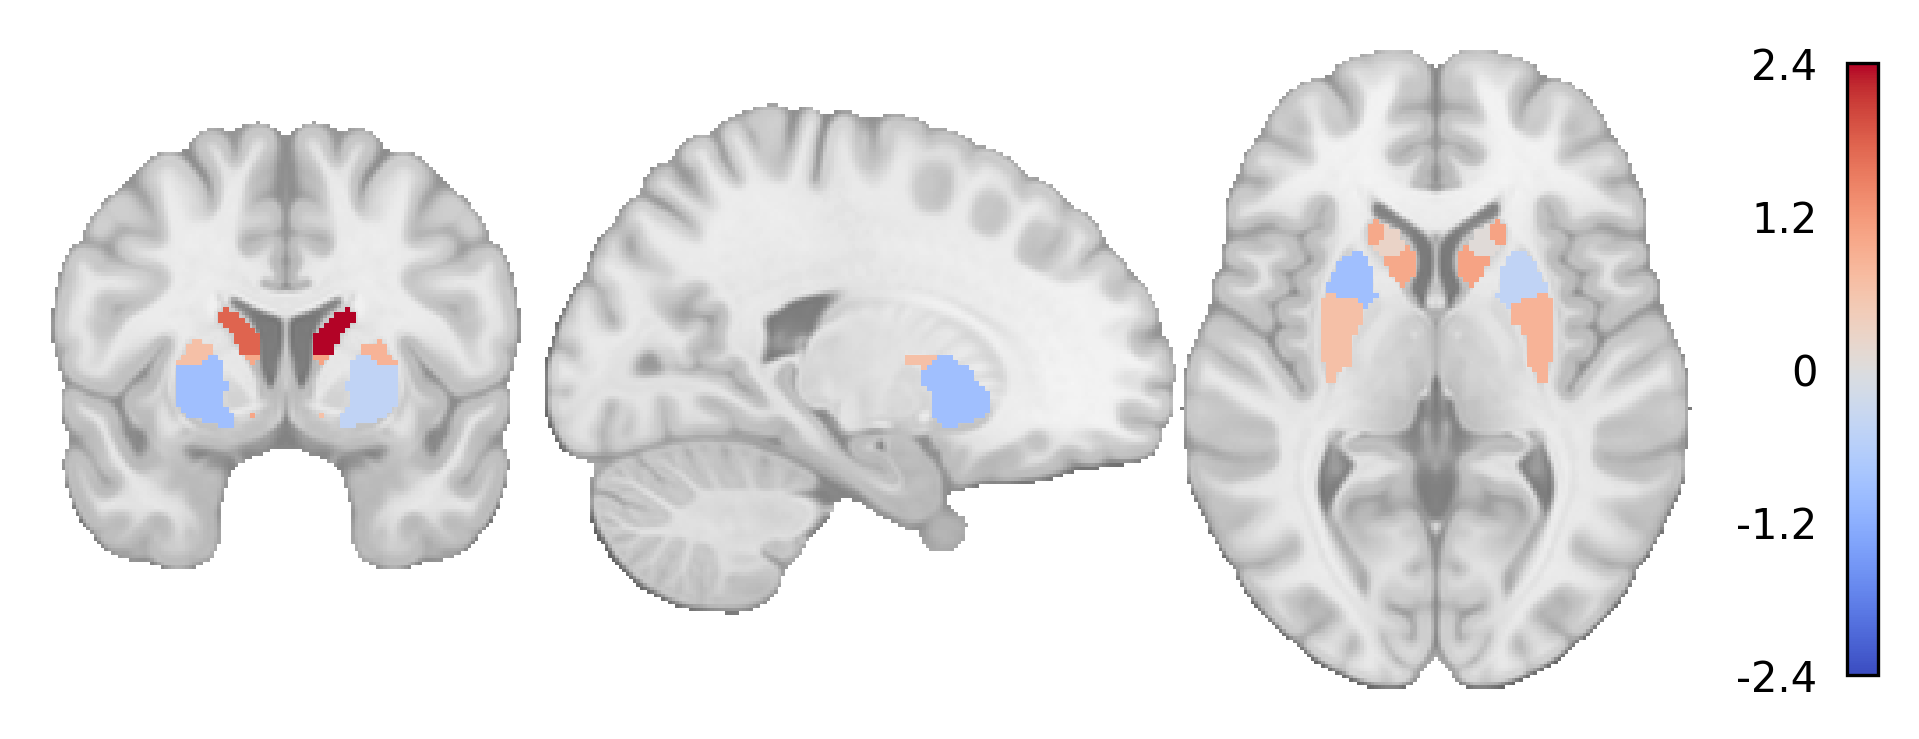

In [77]:
fig = plot_roi_slices(roi_middlethird_mean_dict, mask_path_list, network_name, space_label)

region: aCAU-lh


/scratch/slurm-6464360/ipykernel_166919/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: pCAU-lh
region: aPUT-lh
region: pPUT-lh
region: NAc-shell-lh
region: NAc-core-lh
region: aCAU-rh
region: pCAU-rh
region: aPUT-rh
region: pPUT-rh
region: NAc-shell-rh
region: NAc-core-rh


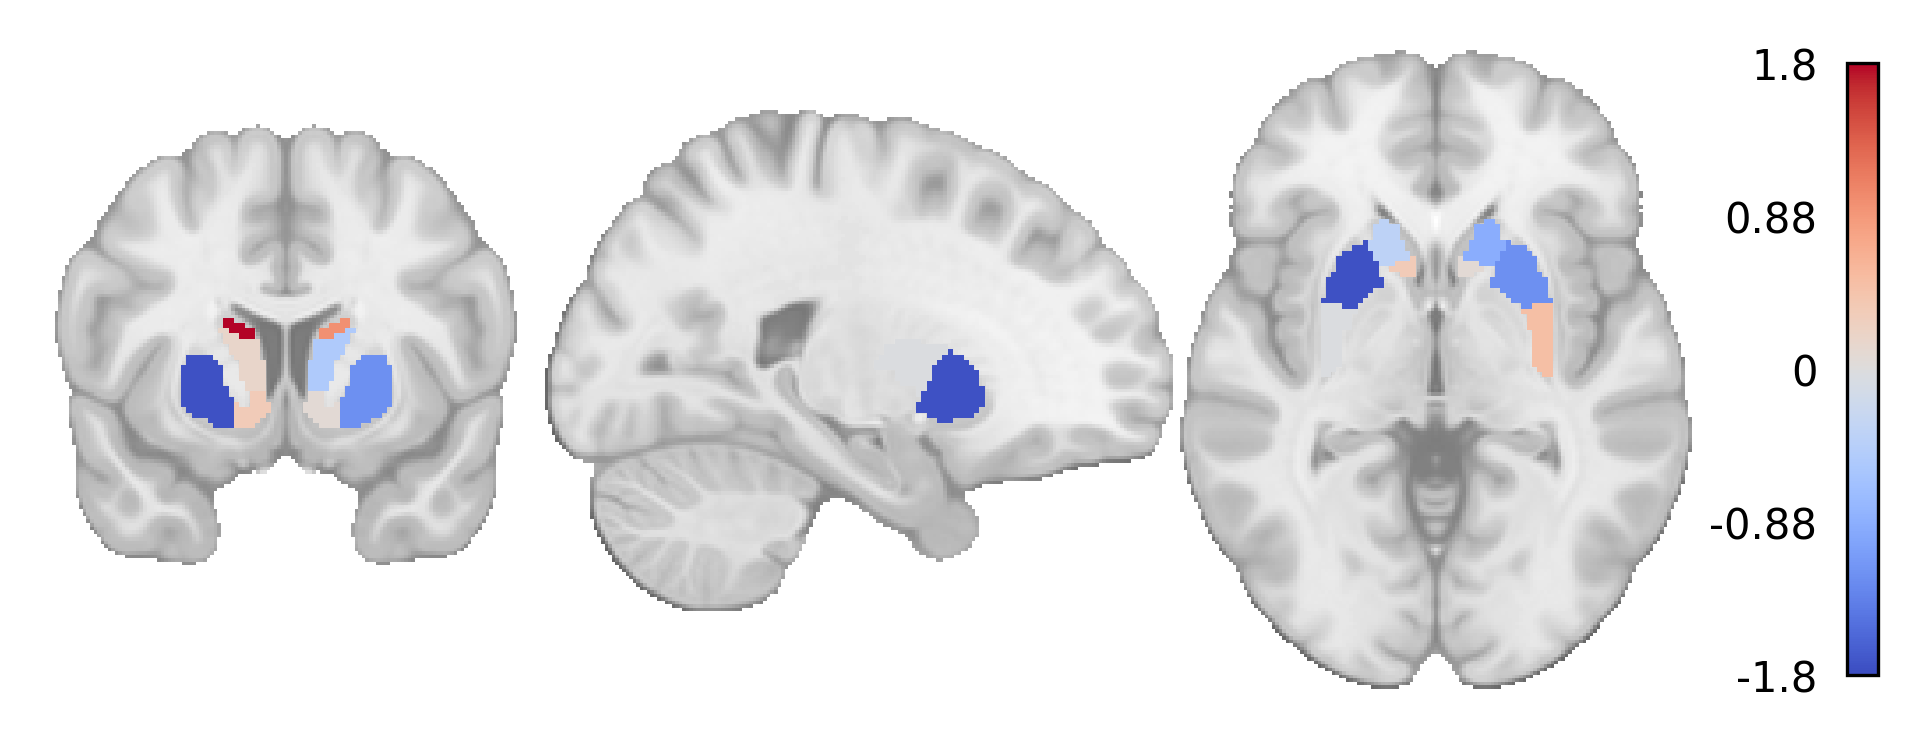

In [78]:
fig = plot_roi_slices(roi_latethird_mean_dict, mask_path_list, network_name, space_label)

In [79]:
plot_order = ['aCAU', 'pCAU', 'aPUT', 'pPUT', 'NAc-core', 'NAc-shell', ]

/scratch/slurm-6464360/ipykernel_166919/2807131526.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


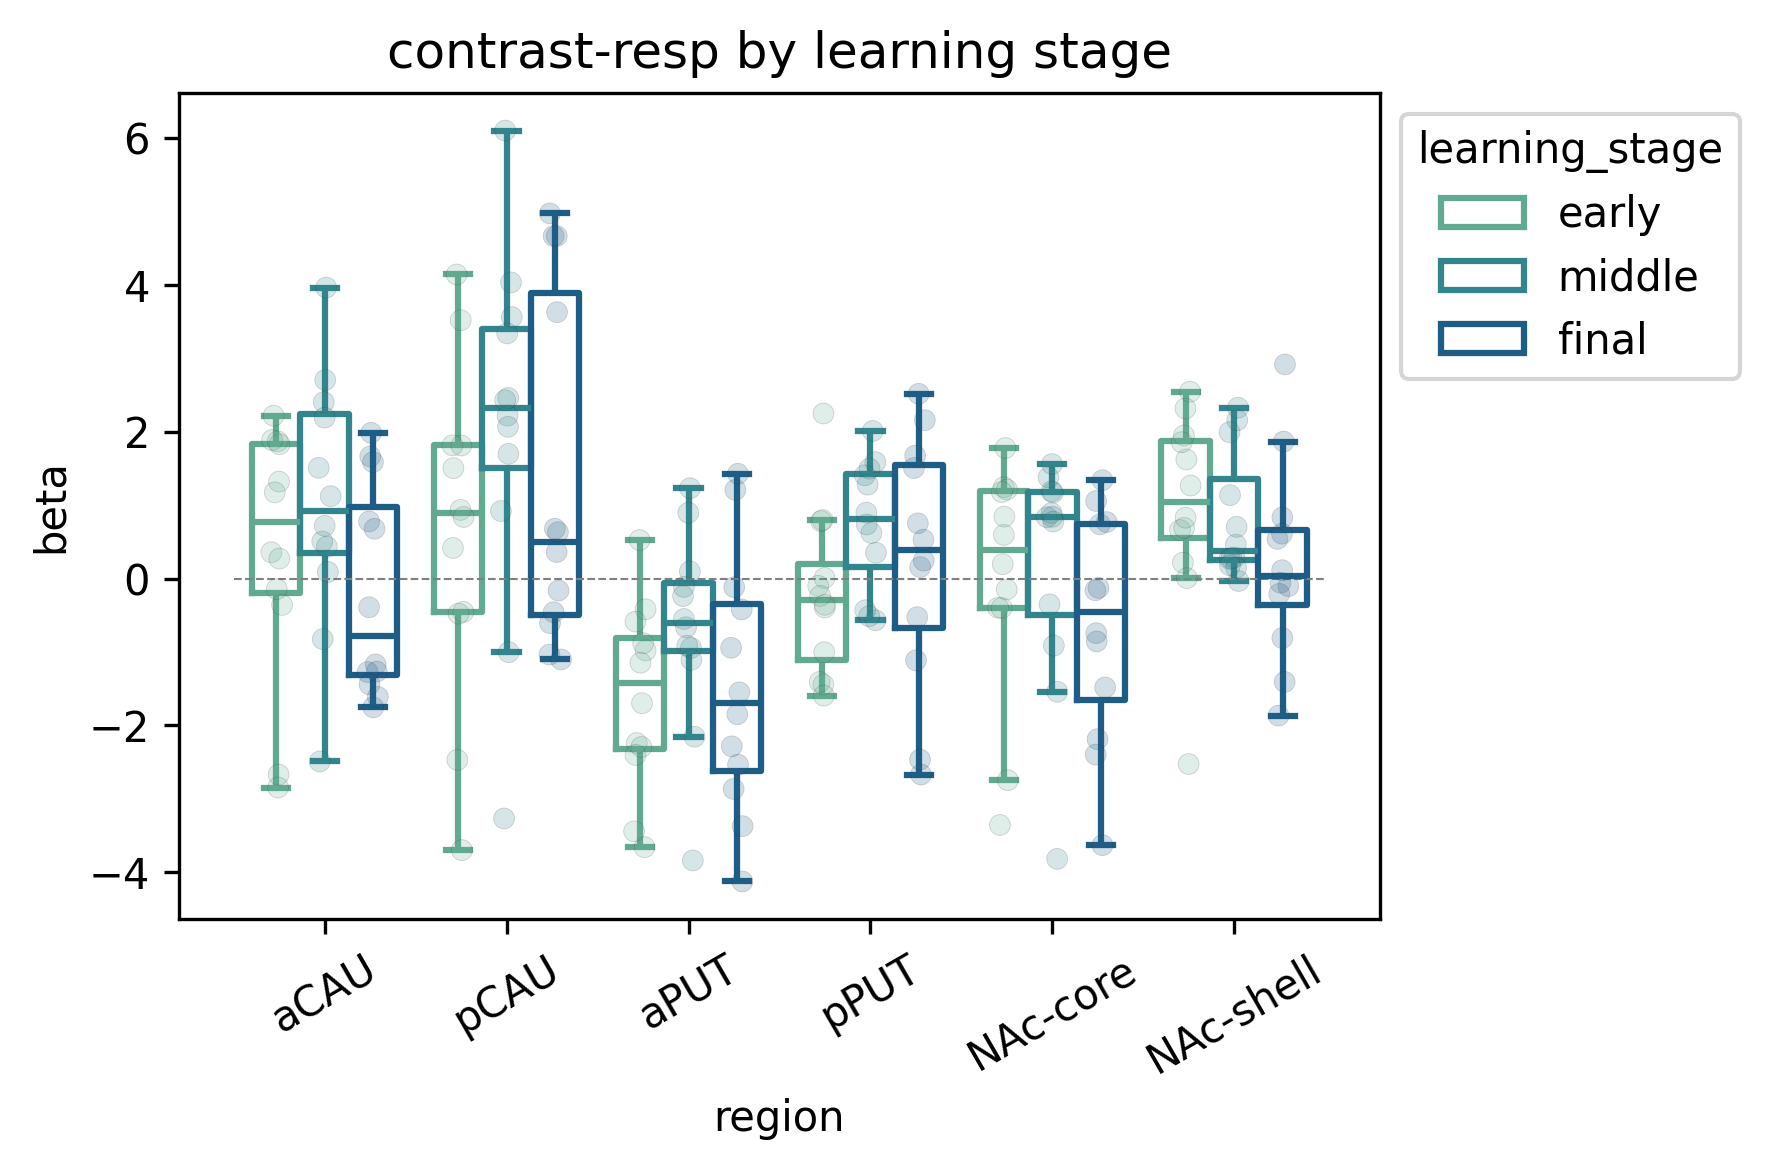

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by learning stage');
#ax.set_ylim([-5, 5])

fig.tight_layout()


/scratch/slurm-6464360/ipykernel_166919/3935233491.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


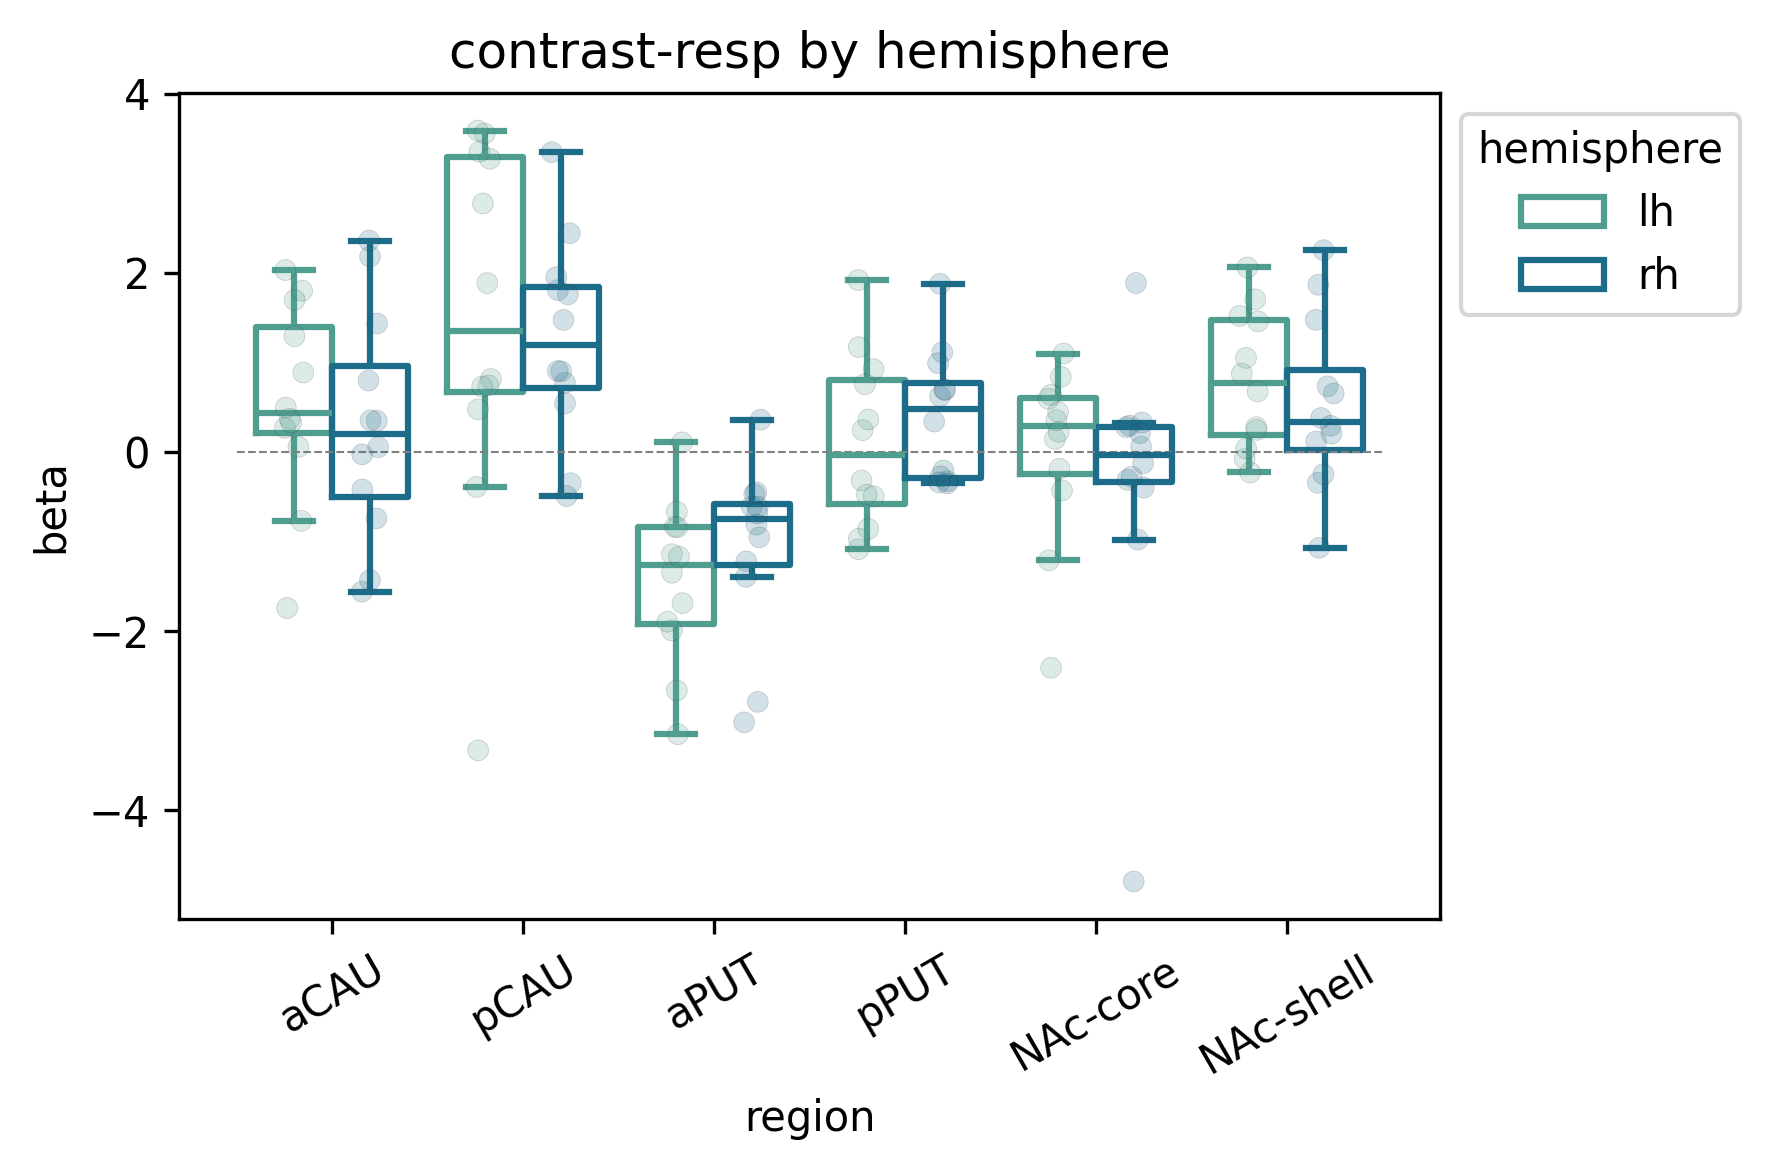

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'hemisphere'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by hemisphere');
#ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [82]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

In [83]:
# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','Axis', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
aov.summary()

network: tian-S2
contrast: resp


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/stats/anova.py:508: FutureWarning: The provided callable <function mean at 0x7fbc901ac4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  self.data = (self.data
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Anova
============================================================
                               F Value Num DF  Den DF Pr > F
------------------------------------------------------------
hemisphere                      0.3157 1.0000 11.0000 0.5855
learning_stage                  1.4763 2.0000 22.0000 0.2502
Axis                           16.5938 2.0000 22.0000 0.0000
hemisphere:learning_stage       0.5589 2.0000 22.0000 0.5798
hemisphere:Axis                 1.6046 2.0000 22.0000 0.2236
learning_stage:Axis             3.0632 4.0000 44.0000 0.0260
hemisphere:learning_stage:Axis  0.8689 4.0000 44.0000 0.4902
============================================================

"""

In [84]:
# pairwise by Axis

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','Axis', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'learning_stage','A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'learning_stage', 'A', 'B', 'Paired', 'Parametric', 'T',
       'dof', 'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast learning_stage        A        B         T   dof  \
0  learning_stage * Axis          early   Caudal  Rostral  2.754951  11.0   
1  learning_stage * Axis          early   Caudal  Ventral -0.712496  11.0   
2  learning_stage * Axis          early  Rostral  Ventral -5.477260  11.0   
3  learning_stage * Axis          final   Caudal  Rostral  3.800672  11.0   
4  learning_stage * Axis          final   Caudal  Ventral  2.883283  11.0   
5  learning_stage * Axis          final  Rostral  Ventral -1.897184  11.0   
6  learning_stage * Axis         middle   Caudal  Rostral  4.208683  11.0   
7  learning_stage * Axis         middle   Caudal  Ventral  2.593698  11.0   
8  learning_stage * Axis         middle  Rostral  Ventral -1.388690  11.0   

      p-unc    p-corr     BF10  
0  0.018724  0.033704    3.573  
1  0.490995  0.490995    0.357  
2  0.000193  0.001735  163.569  
3  0.002940  0.008820   16.201  
4  0.014884  0.033488    4.293  
5  0.084351  0.108452     1.12  
6  0.001464  0.006588   29.043  
7  0.024973  0.037460    2.844  
8  0.192403  0.216453    0.625

In [85]:
# pairwise by Axis

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['Axis', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
#pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'Axis', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'Axis', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast     Axis      A       B         T   dof     p-unc  \
0  Axis * learning_stage   Caudal  early   final -0.826825  11.0  0.425908   
1  Axis * learning_stage   Caudal  early  middle -1.877430  11.0  0.087214   
2  Axis * learning_stage   Caudal  final  middle -0.948843  11.0  0.363081   
3  Axis * learning_stage  Rostral  early   final  0.354428  11.0  0.729719   
4  Axis * learning_stage  Rostral  early  middle -1.694345  11.0  0.118289   
5  Axis * learning_stage  Rostral  final  middle -2.517268  11.0  0.028614   
6  Axis * learning_stage  Ventral  early   final  1.308581  11.0  0.217357   
7  Axis * learning_stage  Ventral  early  middle -0.057144  11.0  0.955455   
8  Axis * learning_stage  Ventral  final  middle -1.730460  11.0  0.111465   

     p-corr   BF10  
0  0.547596  0.384  
1  0.266150  1.092  
2  0.544621  0.419  
3  0.820934  0.304  
4  0.266150  0.876  
5  0.257528  2.555  
6  0.391243  0.576  
7  0.955455  0.288  
8  0.266150  0.914

In [86]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['Axis', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
#pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-unc'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast Contrast        A        B         T   dof     p-unc    p-corr  \
0     Axis     Axis   Caudal  Rostral  6.391393  11.0  0.000051  0.000154   
1     Axis     Axis   Caudal  Ventral  2.225006  11.0  0.047944  0.047944   
2     Axis     Axis  Rostral  Ventral -3.466302  11.0  0.005274  0.007911   

      BF10  
0  514.196  
1    1.712  
2    9.984

In [87]:
# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
aov.summary()

network: tian-S2
contrast: resp


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Anova
================================================================
                                 F Value  Num DF  Den DF  Pr > F
----------------------------------------------------------------
hemisphere                        0.3157  1.0000  11.0000 0.5855
learning_stage                    1.4763  2.0000  22.0000 0.2502
region                           16.1262  5.0000  55.0000 0.0000
hemisphere:learning_stage         0.5589  2.0000  22.0000 0.5798
hemisphere:region                 1.1289  5.0000  55.0000 0.3561
learning_stage:region             1.3726 10.0000 110.0000 0.2023
hemisphere:learning_stage:region  0.9339 10.0000 110.0000 0.5054
================================================================

"""

In [88]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-corr'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast Contrast          A          B         T   dof     p-unc  \
0    region   region   NAc-core  NAc-shell -2.628782  11.0  0.023458   
2    region   region   NAc-core       aPUT  4.380616  11.0  0.001098   
3    region   region   NAc-core       pCAU -5.445763  11.0  0.000202   
6    region   region  NAc-shell       aPUT  5.818919  11.0  0.000116   
9    region   region       aCAU       aPUT  5.550968  11.0  0.000173   
10   region   region       aCAU       pCAU -3.465643  11.0  0.005280   
12   region   region       aPUT       pCAU -7.033313  11.0  0.000022   
13   region   region       aPUT       pPUT -7.317433  11.0  0.000015   
14   region   region       pCAU       pPUT  3.366944  11.0  0.006286   

      p-corr      BF10  
0   0.039097     2.988  
2   0.002745     37.02  
3   0.000606   156.995  
6   0.000580   253.546  
9   0.000606   179.976  
10  0.011315     9.975  
12  0.000163  1091.466  
13  0.000163  1503.114  
14  0.011787     8.643

#### Collapse (average) over non-significant factors

In [89]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})


In [90]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region_stage, data in roi_df_collapsed.groupby(["region",'learning_stage']):
    #print(region_stage)
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region_stage[0], region_stage[1], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, stage: {stage}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: NAc-core, stage: early, t = 0.00; corrected p = 0.9985
Region: NAc-core, stage: final, t = -1.43; corrected p = 0.3250
Region: NAc-core, stage: middle, t = 0.37; corrected p = 0.7596
Region: NAc-shell, stage: early, t = 2.42; corrected p = 0.1015
Region: NAc-shell, stage: final, t = 0.54; corrected p = 0.7474
Region: NAc-shell, stage: middle, t = 3.33; corrected p = 0.0532
Region: aCAU, stage: early, t = 0.83; corrected p = 0.6340
Region: aCAU, stage: final, t = -0.45; corrected p = 0.7474
Region: aCAU, stage: middle, t = 2.08; corrected p = 0.1593
Region: aPUT, stage: early, t = -4.43; corrected p = 0.0182
Region: aPUT, stage: final, t = -2.89; corrected p = 0.0532
Region: aPUT, stage: middle, t = -1.79; corrected p = 0.2030
Region: pCAU, stage: early, t = 1.02; corrected p = 0.5409
Region: pCAU, stage: final, t = 1.95; corrected p = 0.1721
Region: pCAU, stage: middle, t = 2.95; corrected p = 0.0532
Region: pPUT, stage: early, t = -0.70; corrected p = 0.6930
Region: pPUT, stag

In [91]:
# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: NAc-core, t = -0.60; corrected p = 0.5537
Region: NAc-shell, t = 3.27; corrected p = 0.0048
Region: aCAU, t = 1.52; corrected p = 0.2066
Region: aPUT, t = -5.08; corrected p = 0.0001
Region: pCAU, t = 3.45; corrected p = 0.0044
Region: pPUT, t = 1.15; corrected p = 0.3077


### Make 3D plots

In [ ]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region_hemi"], 
                                       as_index=False).agg({"beta": "mean"})

# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region_hemi"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


In [ ]:
region_list = region_dict[network_name]

mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm') # 'coolwarm', 'Reds'

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        yaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        zaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    #title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_network-{network_name}_surface.svg')
clear_output()

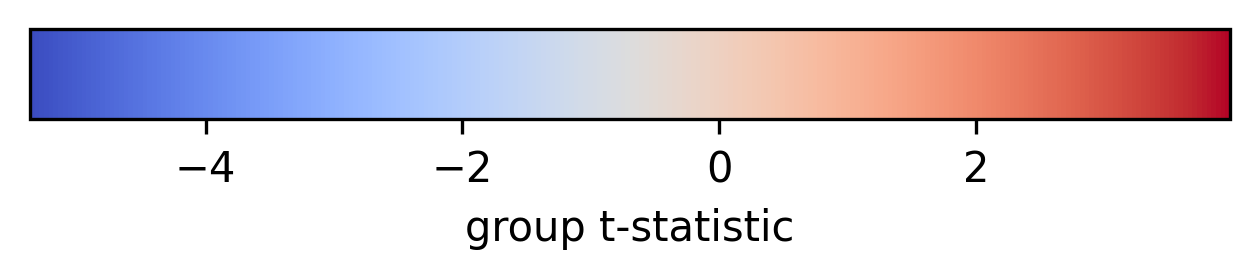

In [ ]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
#cbar.ax.get_yaxis().labelpad = 15
plt.savefig(f"out-figure_group-all_contrast-{contrast_label}_network-{network_name}_colorbar.svg")

## `contrast-resp` for cortical network

In [51]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[0]
contrast_label = contrast_list[1]
print('network_name:', network_name)
print('contrast_label:', contrast_label)

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

network_name: auditory
contrast_label: resp


In [52]:
print(f'masking {contrast_label} stat maps for the {network_name} network')

print(f'creating dictionary for early learning stage')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

print(f'creating dictionary for middle learning stage')
roi_middlethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_middlethird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

print(f'creating dictionary for final learning stage')
roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

masking resp stat maps for the auditory network
creating dictionary for early learning stage
L-HG
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT02_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT04/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT04_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT06/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT06_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT09/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT09_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT11/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchand

In [53]:
# add `learning_stage` column and combine into single dataframe
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_nman_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_middlethird_df_long = make_stats_df(roi_middlethird_mean_dict, participants_nman_df, network_name)
roi_middlethird_df_long['learning_stage'] = 'middle'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_nman_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_middlethird_df_long, roi_latethird_df_long],)

In [54]:
non_mandarin_df = roi_df_long

region: L-HG


/scratch/slurm-6601185/ipykernel_4086458/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: L-PT
region: L-PP
region: L-STGp
region: L-STGa
region: L-ParsOp
region: L-ParsTri
region: R-HG
region: R-PT
region: R-PP
region: R-STGp
region: R-STGa
region: R-ParsOp
region: R-ParsTri


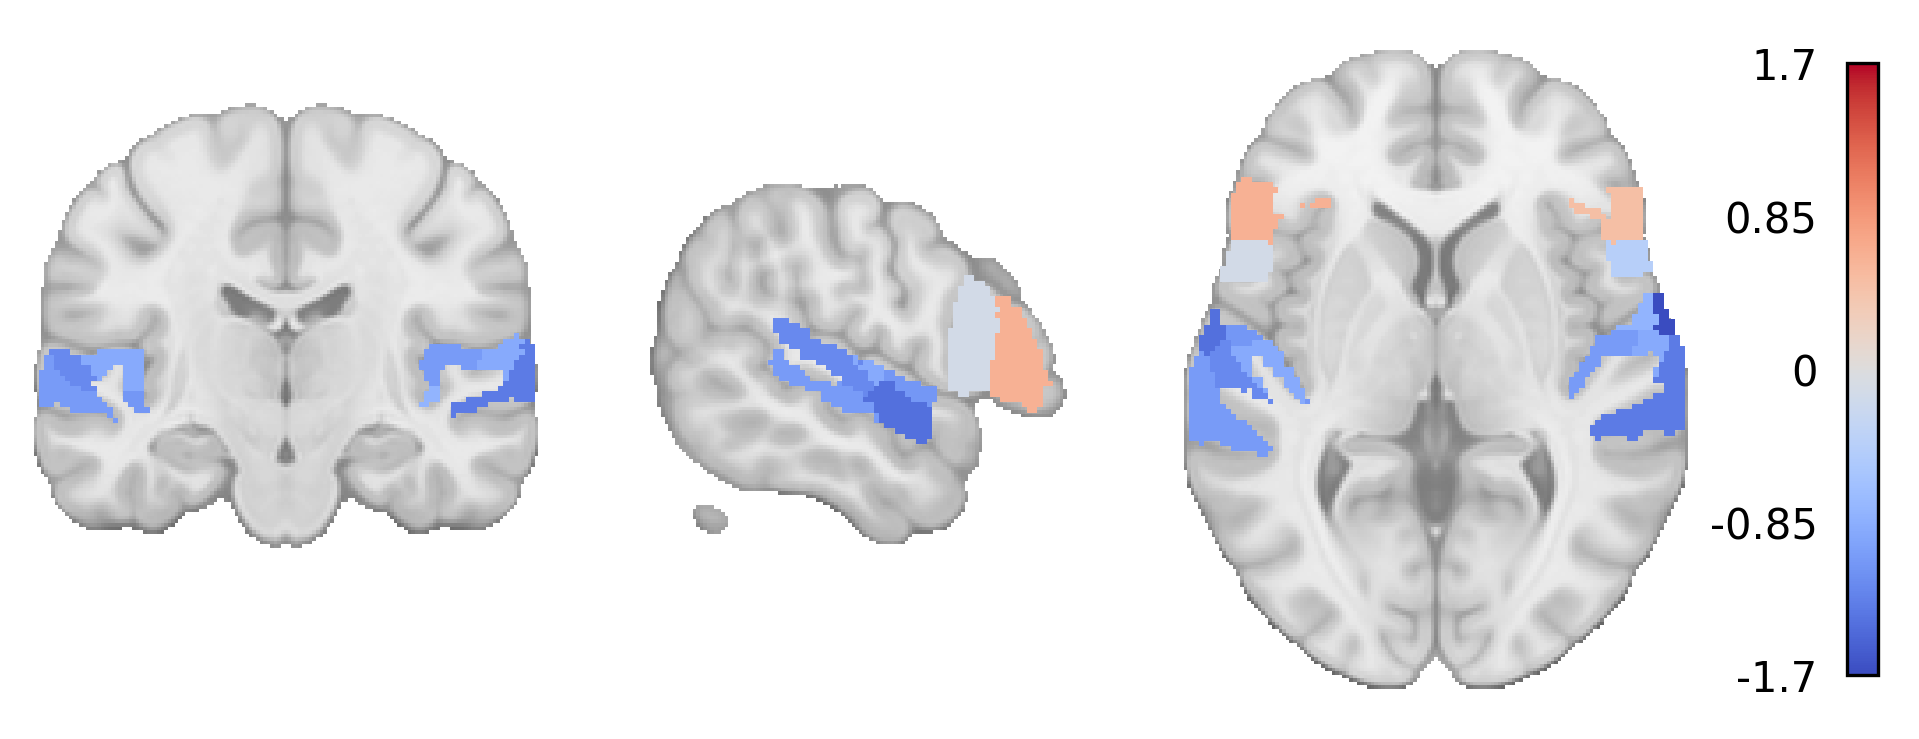

In [55]:
fig = plot_roi_slices(roi_earlythird_mean_dict, mask_path_list, 'dseg', space_label)

region: L-HG


/scratch/slurm-6601185/ipykernel_4086458/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: L-PT
region: L-PP
region: L-STGp
region: L-STGa
region: L-ParsOp
region: L-ParsTri
region: R-HG
region: R-PT
region: R-PP
region: R-STGp
region: R-STGa
region: R-ParsOp
region: R-ParsTri


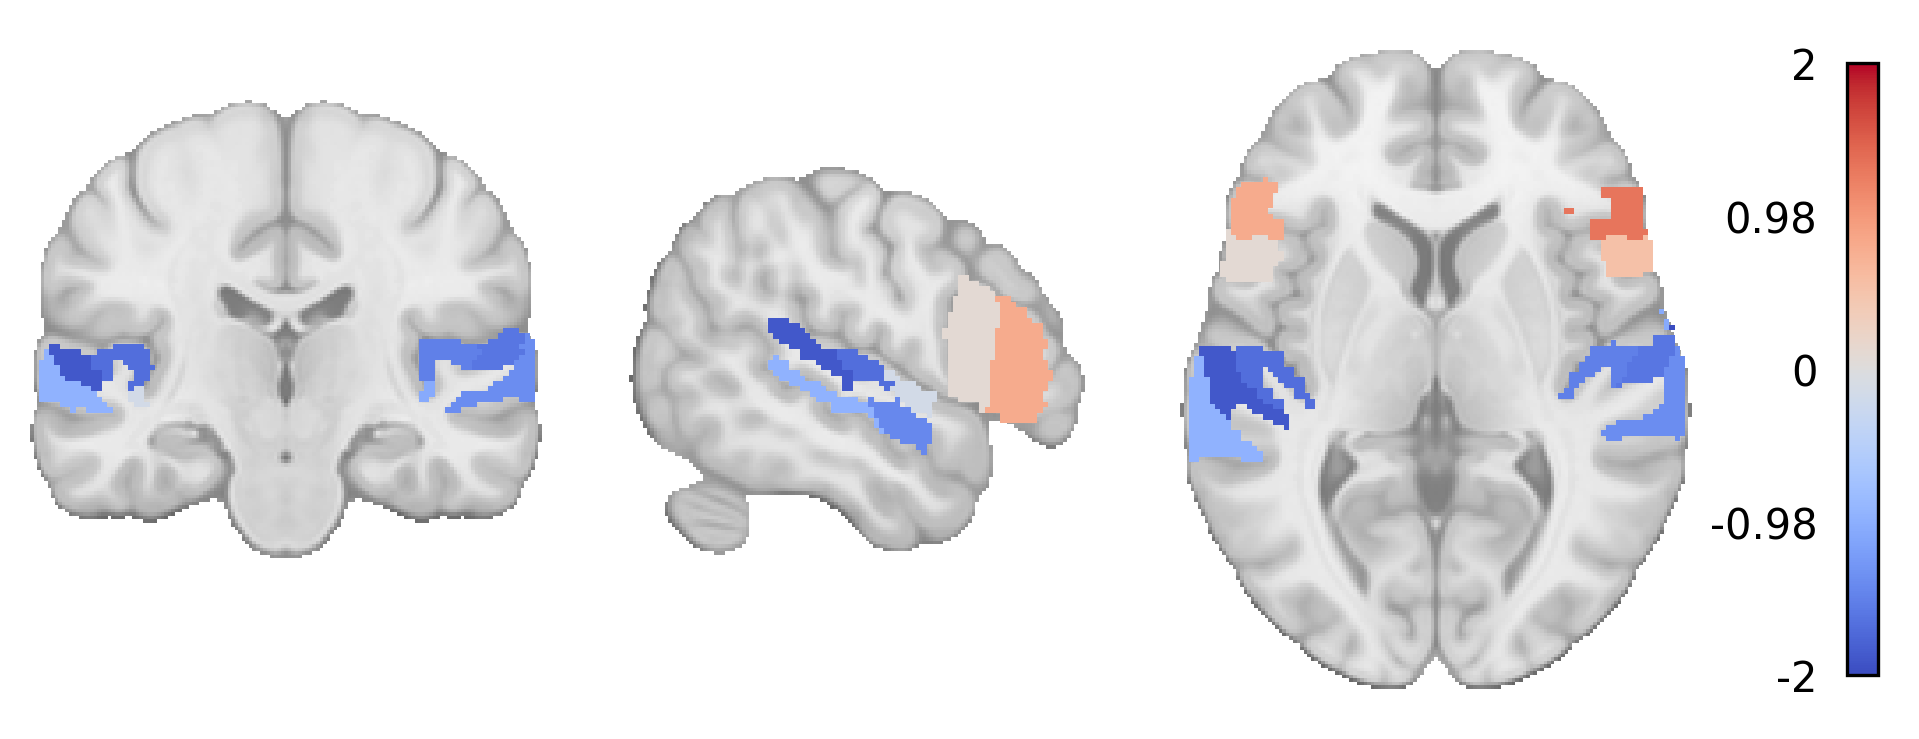

In [57]:
fig = plot_roi_slices(roi_middlethird_mean_dict, mask_path_list, 'dseg', space_label)

region: L-HG


/scratch/slurm-6601185/ipykernel_4086458/513056916.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: L-PT
region: L-PP
region: L-STGp
region: L-STGa
region: L-ParsOp
region: L-ParsTri
region: R-HG
region: R-PT
region: R-PP
region: R-STGp
region: R-STGa
region: R-ParsOp
region: R-ParsTri


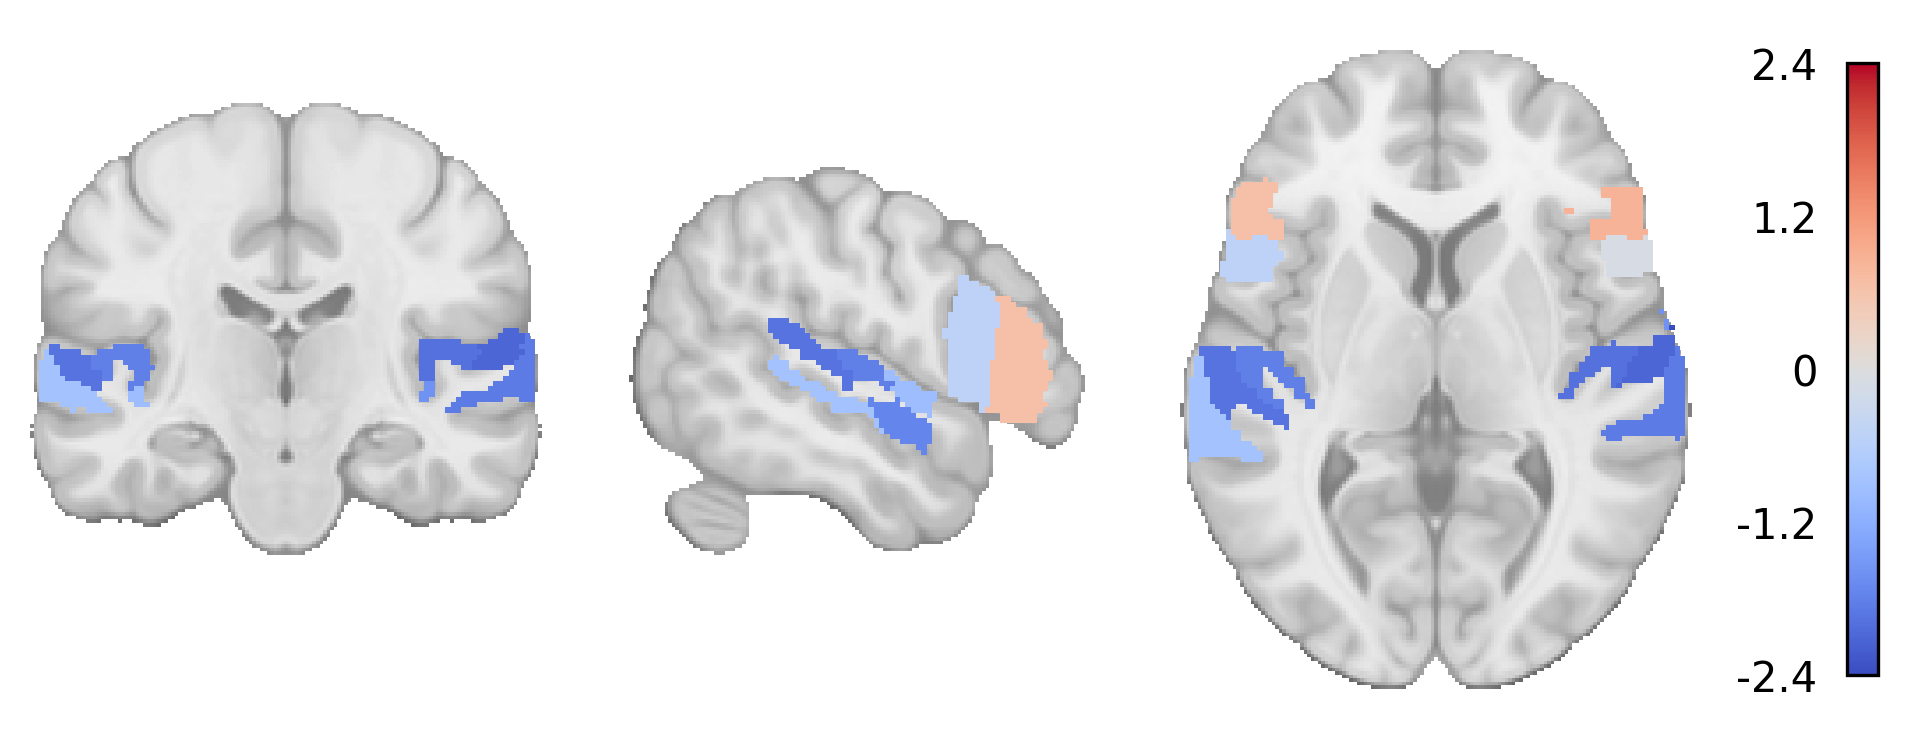

In [56]:
fig = plot_roi_slices(roi_latethird_mean_dict, mask_path_list, 'dseg', space_label)

/scratch/slurm-6601185/ipykernel_4086458/2807131526.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


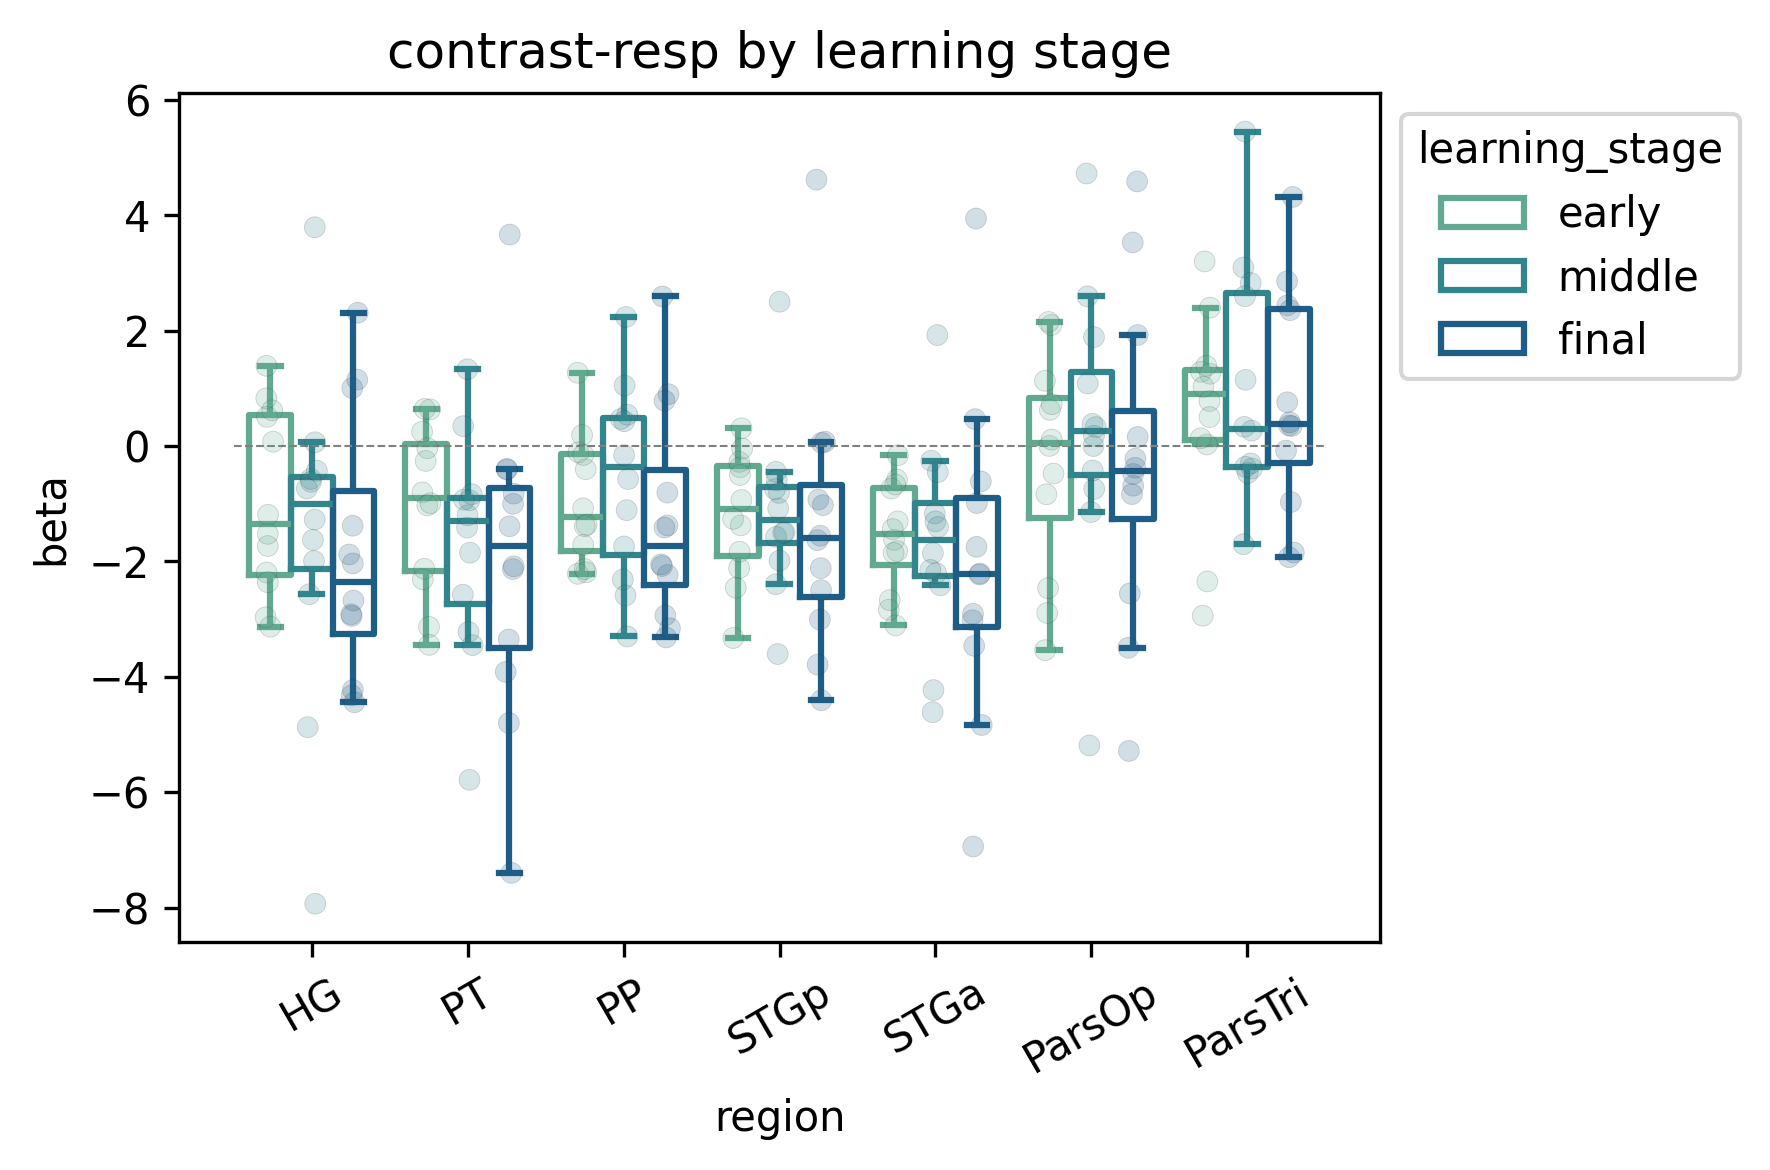

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by learning stage');
#ax.set_ylim([-5, 5])

fig.tight_layout()


/scratch/slurm-6601185/ipykernel_4086458/3935233491.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


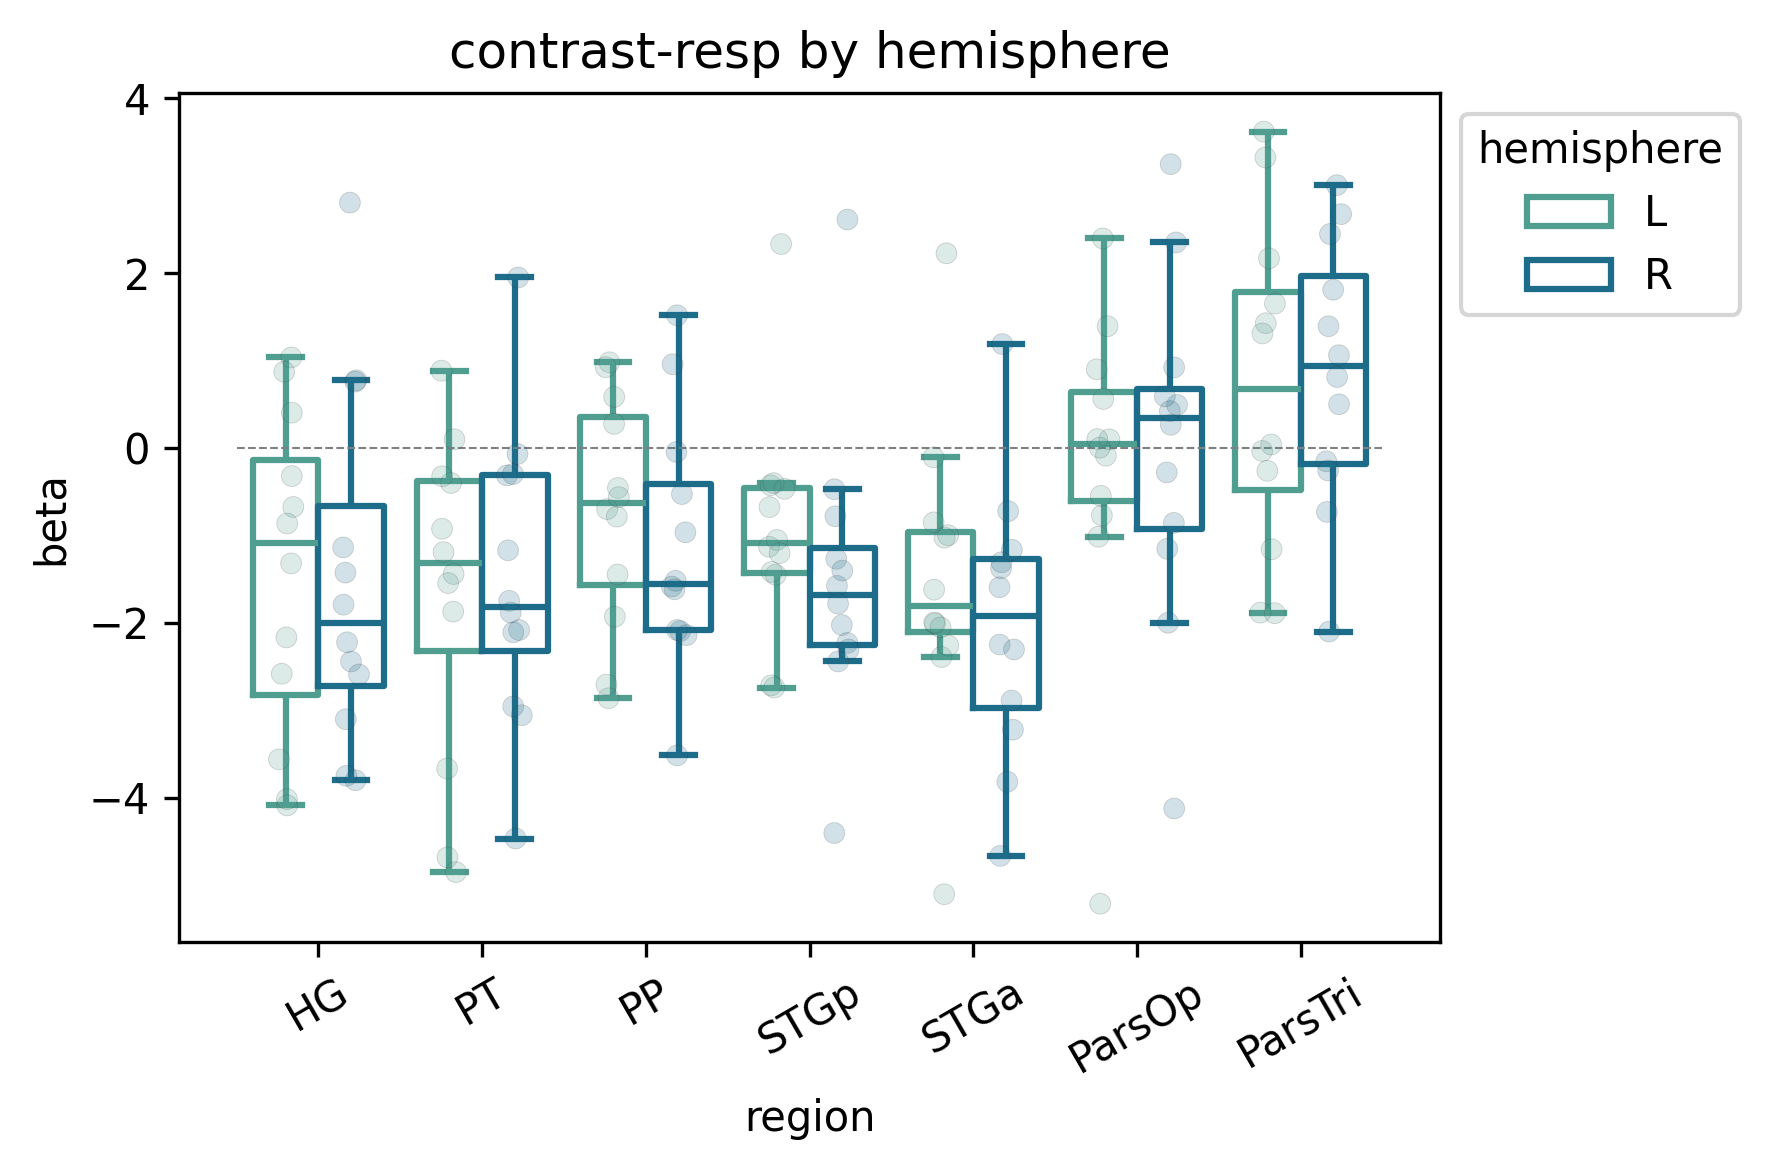

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'hemisphere'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by hemisphere');
#ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [56]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
print(aov)


network: auditory
contrast: resp
                             Anova
                                 F Value  Num DF  Den DF  Pr > F
----------------------------------------------------------------
hemisphere                        1.6294  1.0000  11.0000 0.2281
learning_stage                    0.5288  2.0000  22.0000 0.5966
region                           11.0522  6.0000  66.0000 0.0000
hemisphere:learning_stage         0.6538  2.0000  22.0000 0.5299
hemisphere:region                 1.1851  6.0000  66.0000 0.3251
learning_stage:region             0.8066 12.0000 132.0000 0.6432
hemisphere:learning_stage:region  1.3232 12.0000 132.0000 0.2126



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [57]:
aov.summary().tables[0]

F Value  Num DF  Den DF        Pr > F
hemisphere                         1.629375     1.0    11.0  2.280801e-01
learning_stage                     0.528797     2.0    22.0  5.966167e-01
region                            11.052217     6.0    66.0  1.705836e-08
hemisphere:learning_stage          0.653826     2.0    22.0  5.298657e-01
hemisphere:region                  1.185110     6.0    66.0  3.251248e-01
learning_stage:region              0.806587    12.0   132.0  6.431936e-01
hemisphere:learning_stage:region   1.323246    12.0   132.0  2.126318e-01

In [58]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-corr'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast Contrast        A        B         T   dof     p-unc    p-corr  \
3    region   region       HG  ParsTri -3.540727  11.0  0.004627  0.010796   
8    region   region       PP  ParsTri -3.751798  11.0  0.003200  0.009600   
11   region   region       PT   ParsOp -4.253119  11.0  0.001359  0.005706   
12   region   region       PT  ParsTri -4.492956  11.0  0.000912  0.004787   
16   region   region   ParsOp     STGa  5.584317  11.0  0.000164  0.001696   
17   region   region   ParsOp     STGp  3.893060  11.0  0.002506  0.008772   
18   region   region  ParsTri     STGa  6.823081  11.0  0.000029  0.000602   
19   region   region  ParsTri     STGp  5.326638  11.0  0.000242  0.001696   
20   region   region     STGa     STGp -3.549792  11.0  0.004554  0.010796   

       BF10  
3    11.123  
8    15.097  
11    30.93  
12   43.326  
16  187.896  
17   18.505  
18  856.933  
19   134.31  
20    11.27

#### Collapse (average) over non-significant factors

In [59]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region"], 
                                       as_index=False).agg({"beta": "mean"})


In [60]:
# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: HG, t = -2.77; corrected p = 0.0317
Region: PP, t = -2.57; corrected p = 0.0366
Region: PT, t = -3.21; corrected p = 0.0290
Region: ParsOp, t = -0.18; corrected p = 0.8594
Region: ParsTri, t = 1.79; corrected p = 0.1184
Region: STGa, t = -3.84; corrected p = 0.0192
Region: STGp, t = -2.98; corrected p = 0.0292


### Make 3D plots

In [61]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region_hemi"], 
                                       as_index=False).agg({"beta": "mean"})

# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region_hemi"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: L-HG, t = -2.72; corrected p = 0.0401
Region: L-PP, t = -1.91; corrected p = 0.1051
Region: L-PT, t = -3.13; corrected p = 0.0293
Region: L-ParsOp, t = -0.34; corrected p = 0.7981
Region: L-ParsTri, t = 1.29; corrected p = 0.2601
Region: L-STGa, t = -3.08; corrected p = 0.0293
Region: L-STGp, t = -2.52; corrected p = 0.0443
Region: R-HG, t = -2.57; corrected p = 0.0443
Region: R-PP, t = -2.77; corrected p = 0.0401
Region: R-PT, t = -3.12; corrected p = 0.0293
Region: R-ParsOp, t = -0.02; corrected p = 0.9870
Region: R-ParsTri, t = 1.99; corrected p = 0.1004
Region: R-STGa, t = -4.49; corrected p = 0.0127
Region: R-STGp, t = -3.19; corrected p = 0.0293


In [62]:
region_list = region_dict[network_name]

mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [63]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm') # 'coolwarm', 'Reds'

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        yaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        zaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    #title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_network-{network_name}_surface.svg')
clear_output()

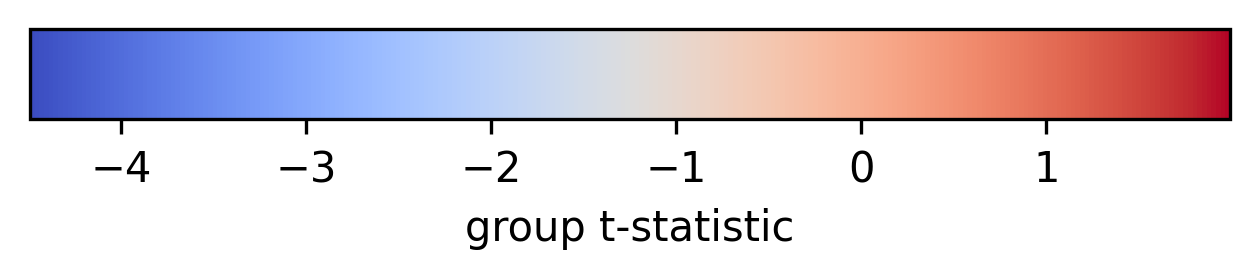

In [64]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
#cbar.ax.get_yaxis().labelpad = 15
plt.savefig(f"out-figure_group-all_contrast-{contrast_label}_network-{network_name}_colorbar.svg")

## `contrast-fb` for striatal network

In [20]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[1]
contrast_label = contrast_list[2]
print('network_name:', network_name)
print('contrast_label:', contrast_label)

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

network_name: tian-S2
contrast_label: fb-correct-vs-wrong


In [21]:
print(f'masking {contrast_label} stat maps for the {network_name} network')

print(f'creating dictionary for early learning stage')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

print(f'creating dictionary for middle learning stage')
roi_middlethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_middlethird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

print(f'creating dictionary for final learning stage')
roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               network_name,
                                               space_label)

masking fb-correct-vs-wrong stat maps for the tian-S2 network
creating dictionary for early learning stage
aCAU-lh
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT02_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT04/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT04_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT06/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT06_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT09/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT09_space-MNI152NLin2009cAsym_mask-aCAU-lh.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT11/space-MNI152NLin2009cAsym/masks-tian-S2/sub-FLT11_space-MNI15

In [22]:
# add `learning_stage` column and combine into single dataframe
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_nman_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_middlethird_df_long = make_stats_df(roi_middlethird_mean_dict, participants_nman_df, network_name)
roi_middlethird_df_long['learning_stage'] = 'middle'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_nman_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_middlethird_df_long, roi_latethird_df_long],)

In [23]:
roi_df_long.participant_id.unique()

array(['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11',
       'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25',
       'sub-FLT28', 'sub-FLT30'], dtype=object)

In [24]:
non_mandarin_df = roi_df_long.copy()

# create a new column based on rostral–caudal axis
non_mandarin_df['Axis'] = ''

if network_name == 'tian-S3':
    non_mandarin_df.loc[(non_mandarin_df['region']=='pCAU'),   'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='PUT-VP'), 'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='PUT-DP'), 'Axis'] = 'Caudal'

    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-DA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-VA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-DP', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='CAU-VP', 'Axis'] = 'Rostral'

    non_mandarin_df.loc[non_mandarin_df['region']=='PUT-VA', 'Axis'] = 'Rostral'
    non_mandarin_df.loc[non_mandarin_df['region']=='PUT-DA', 'Axis'] = 'Rostral'

    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-shell', 'Axis'] = 'Ventral'
    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-core', 'Axis'] = 'Ventral'

elif network_name == 'tian-S2':
    non_mandarin_df.loc[(non_mandarin_df['region']=='pCAU'), 'Axis'] = 'Caudal'
    non_mandarin_df.loc[(non_mandarin_df['region']=='pPUT'), 'Axis'] = 'Caudal'    
    
    non_mandarin_df.loc[(non_mandarin_df['region']=='aCAU'), 'Axis'] = 'Rostral'
    non_mandarin_df.loc[(non_mandarin_df['region']=='aPUT'), 'Axis'] = 'Rostral'    

    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-shell', 'Axis'] = 'Ventral'
    non_mandarin_df.loc[non_mandarin_df['region']=='NAc-core', 'Axis'] = 'Ventral'

non_mandarin_df.head()

participant_id participant_group region      beta region_hemi hemisphere  \
0      sub-FLT02      non-Mandarin   aCAU  0.497805     aCAU-lh         lh   
1      sub-FLT04      non-Mandarin   aCAU  2.527807     aCAU-lh         lh   
2      sub-FLT06      non-Mandarin   aCAU  0.477561     aCAU-lh         lh   
3      sub-FLT09      non-Mandarin   aCAU  1.557735     aCAU-lh         lh   
4      sub-FLT11      non-Mandarin   aCAU  1.185698     aCAU-lh         lh   

  learning_stage     Axis  
0          early  Rostral  
1          early  Rostral  
2          early  Rostral  
3          early  Rostral  
4          early  Rostral

region: aCAU-lh


/scratch/slurm-6642435/ipykernel_1684450/89836282.py:11: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: pCAU-lh
region: aPUT-lh
region: pPUT-lh
region: NAc-shell-lh
region: NAc-core-lh
region: aCAU-rh
region: pCAU-rh
region: aPUT-rh
region: pPUT-rh
region: NAc-shell-rh
region: NAc-core-rh


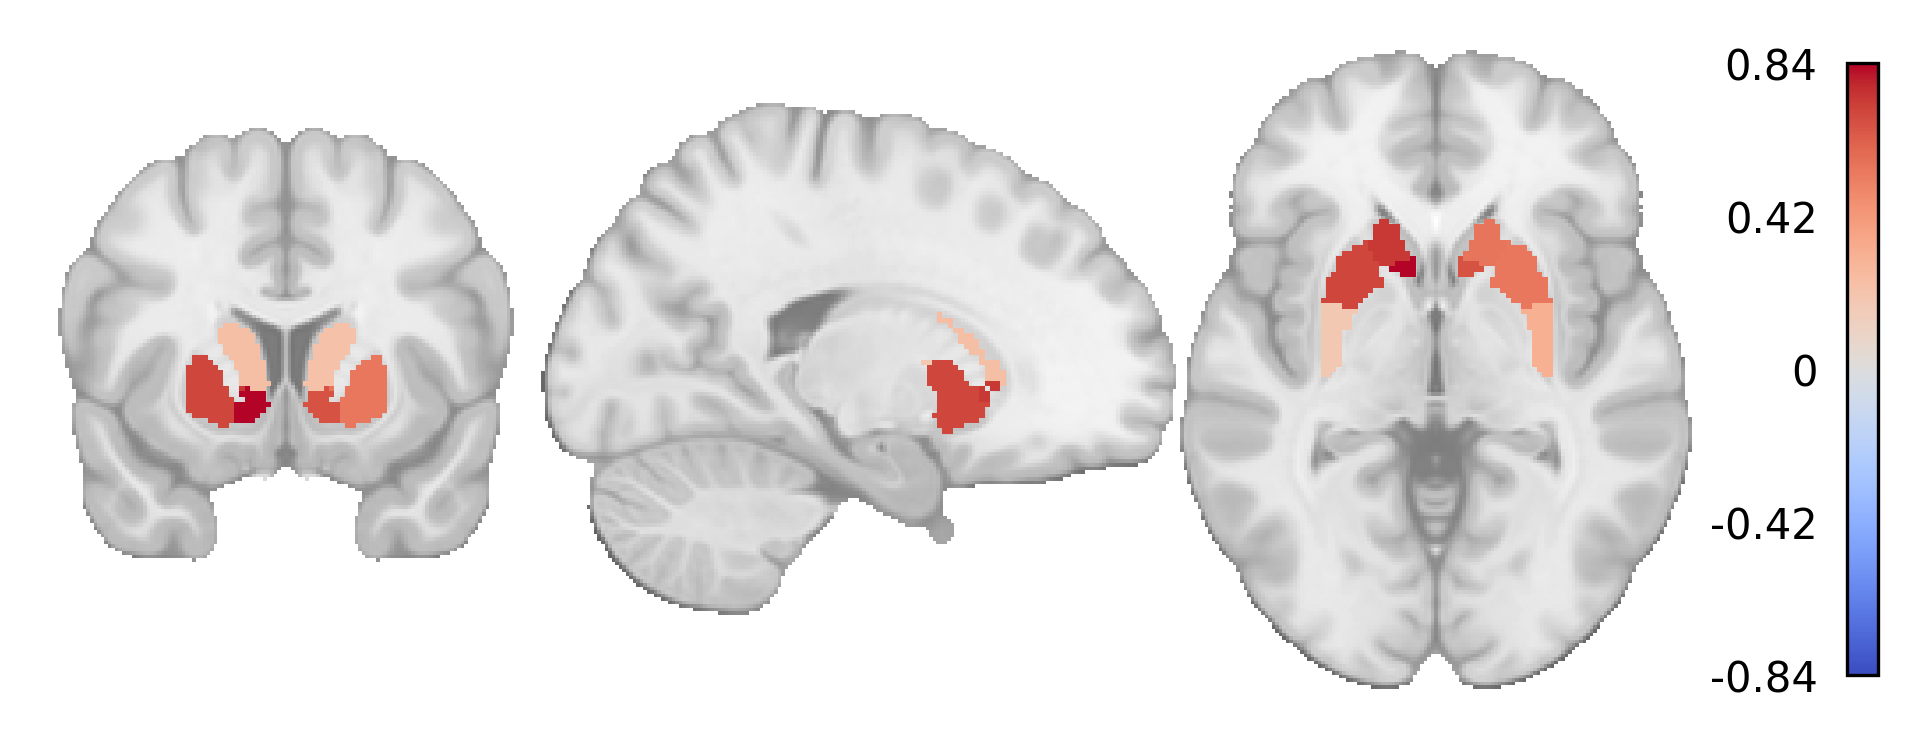

In [25]:
roi_mean_dict_list = [roi_earlythird_mean_dict, roi_middlethird_mean_dict, roi_latethird_mean_dict]
fig = plot_roi_slices_avg(roi_mean_dict_list, mask_path_list, network_name, space_label)

region: aCAU-lh


/scratch/slurm-6642435/ipykernel_1684450/1790035066.py:11: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  roi_img = binarize_img(mask_fpath, two_sided=False)


region: pCAU-lh
region: aPUT-lh
region: pPUT-lh
region: NAc-shell-lh
region: NAc-core-lh
region: aCAU-rh
region: pCAU-rh
region: aPUT-rh
region: pPUT-rh
region: NAc-shell-rh
region: NAc-core-rh


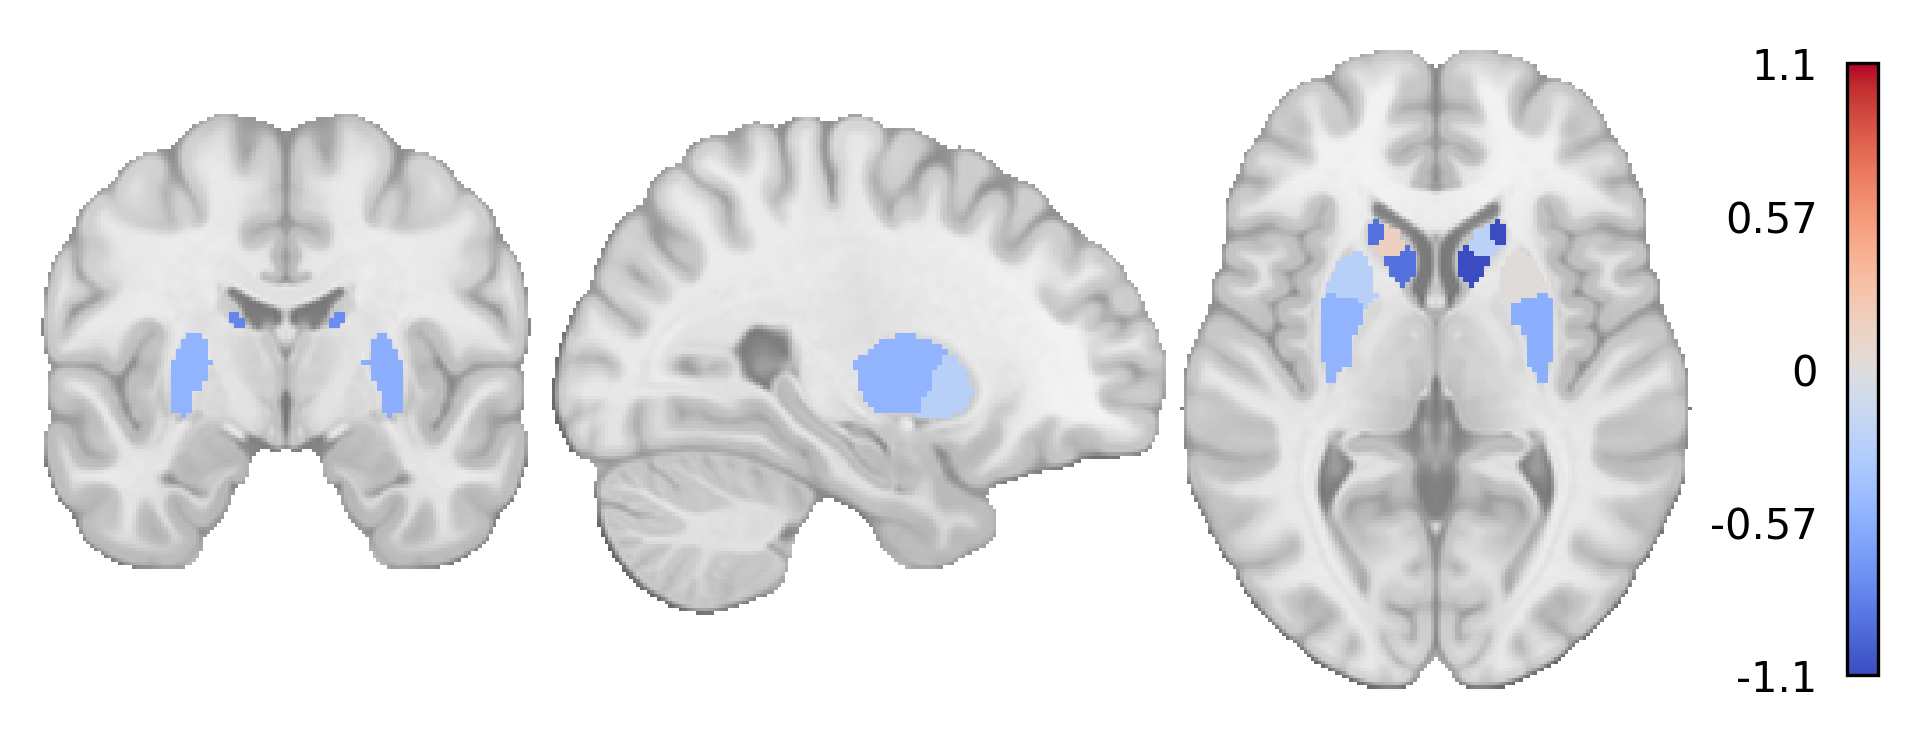

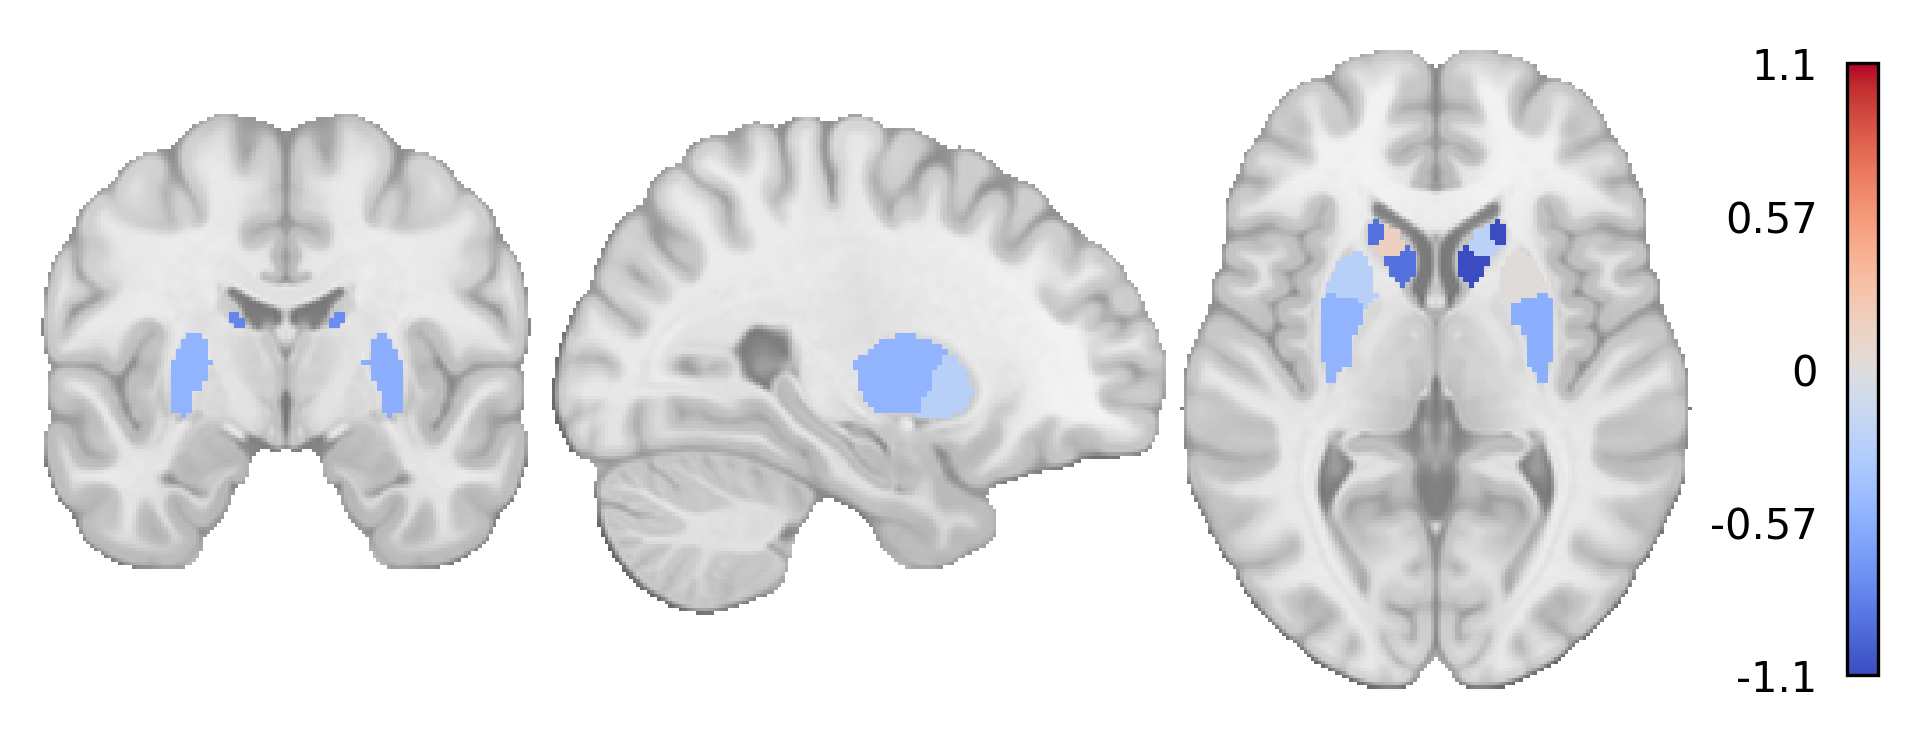

In [29]:
plot_roi_slices_diff(roi_earlythird_mean_dict, roi_latethird_mean_dict, mask_path_list, network_name, space_label)

In [ ]:
plot_order = ['aCAU', 'pCAU', 'aPUT', 'pPUT', 'NAc-core', 'NAc-shell', ]

/scratch/slurm-6601185/ipykernel_4086458/2807131526.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


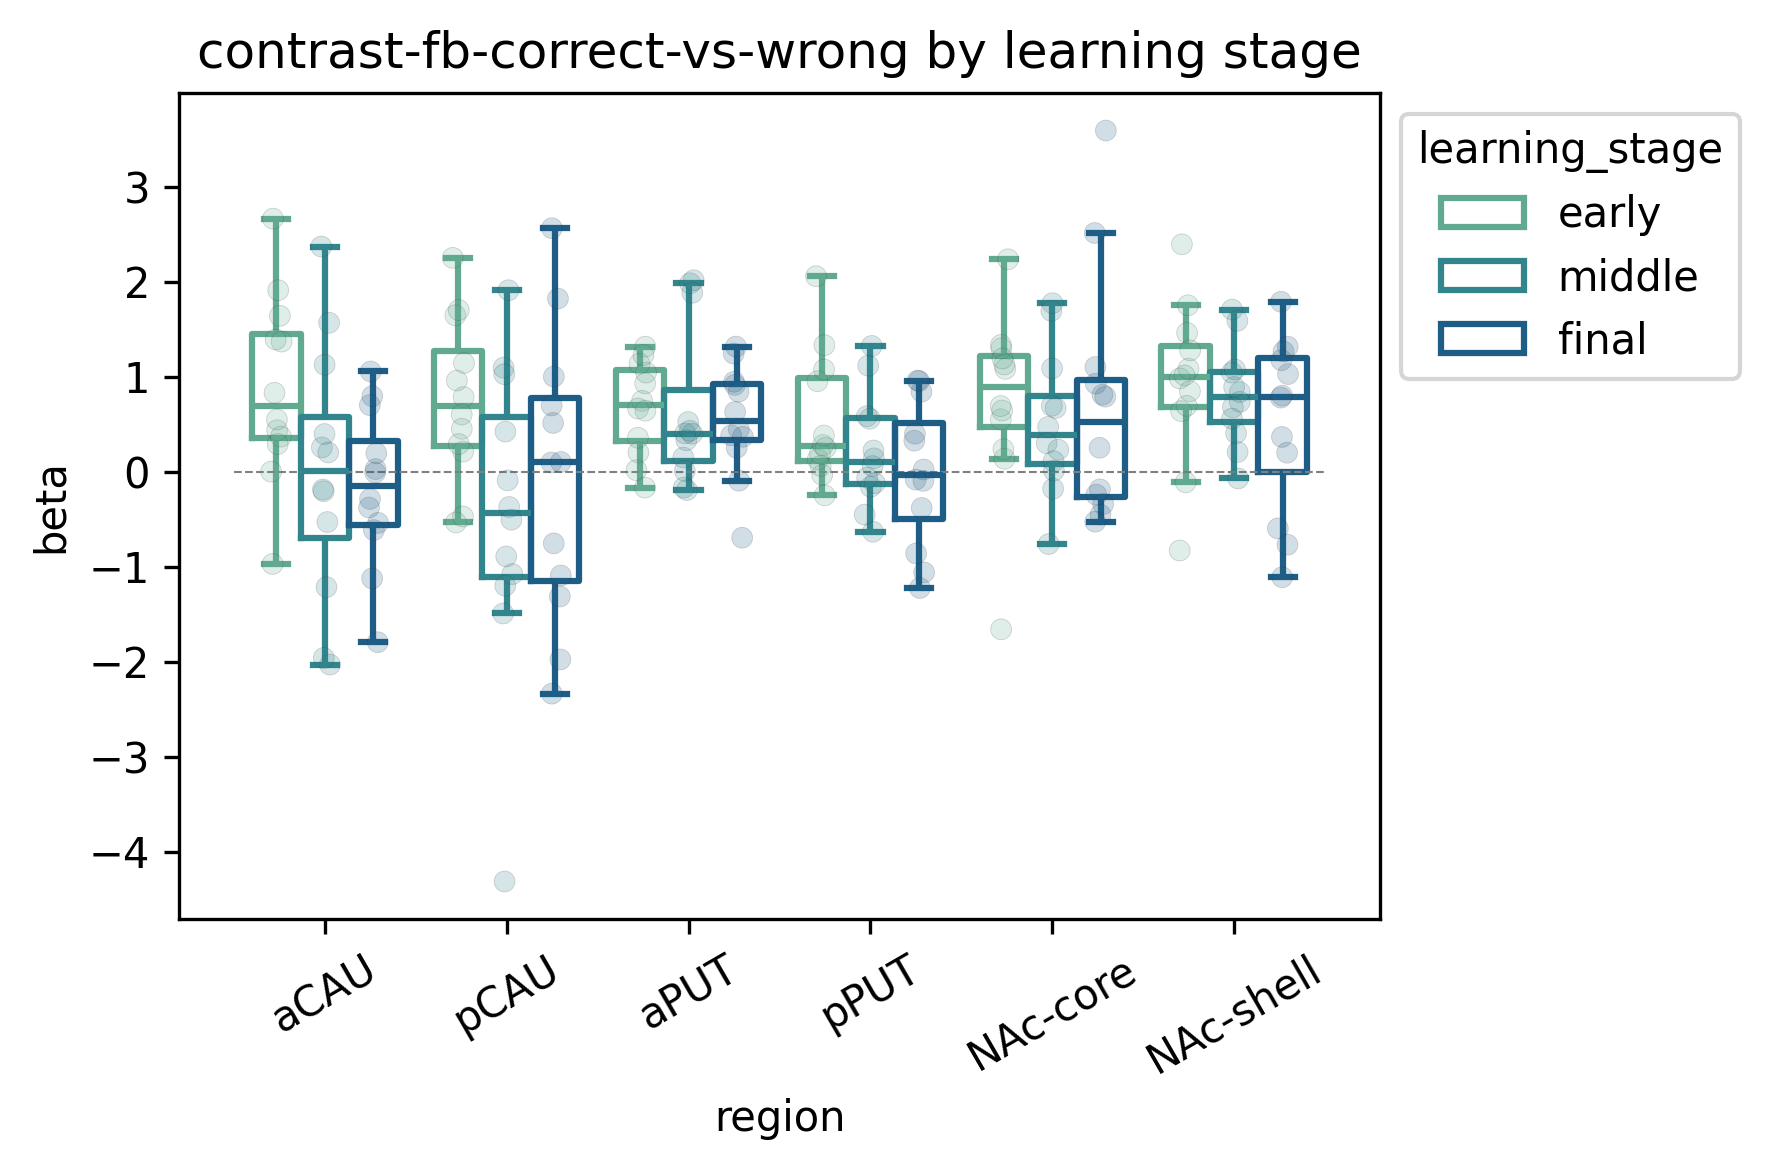

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by learning stage');
#ax.set_ylim([-5, 5])

fig.tight_layout()


/scratch/slurm-6601185/ipykernel_4086458/3935233491.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


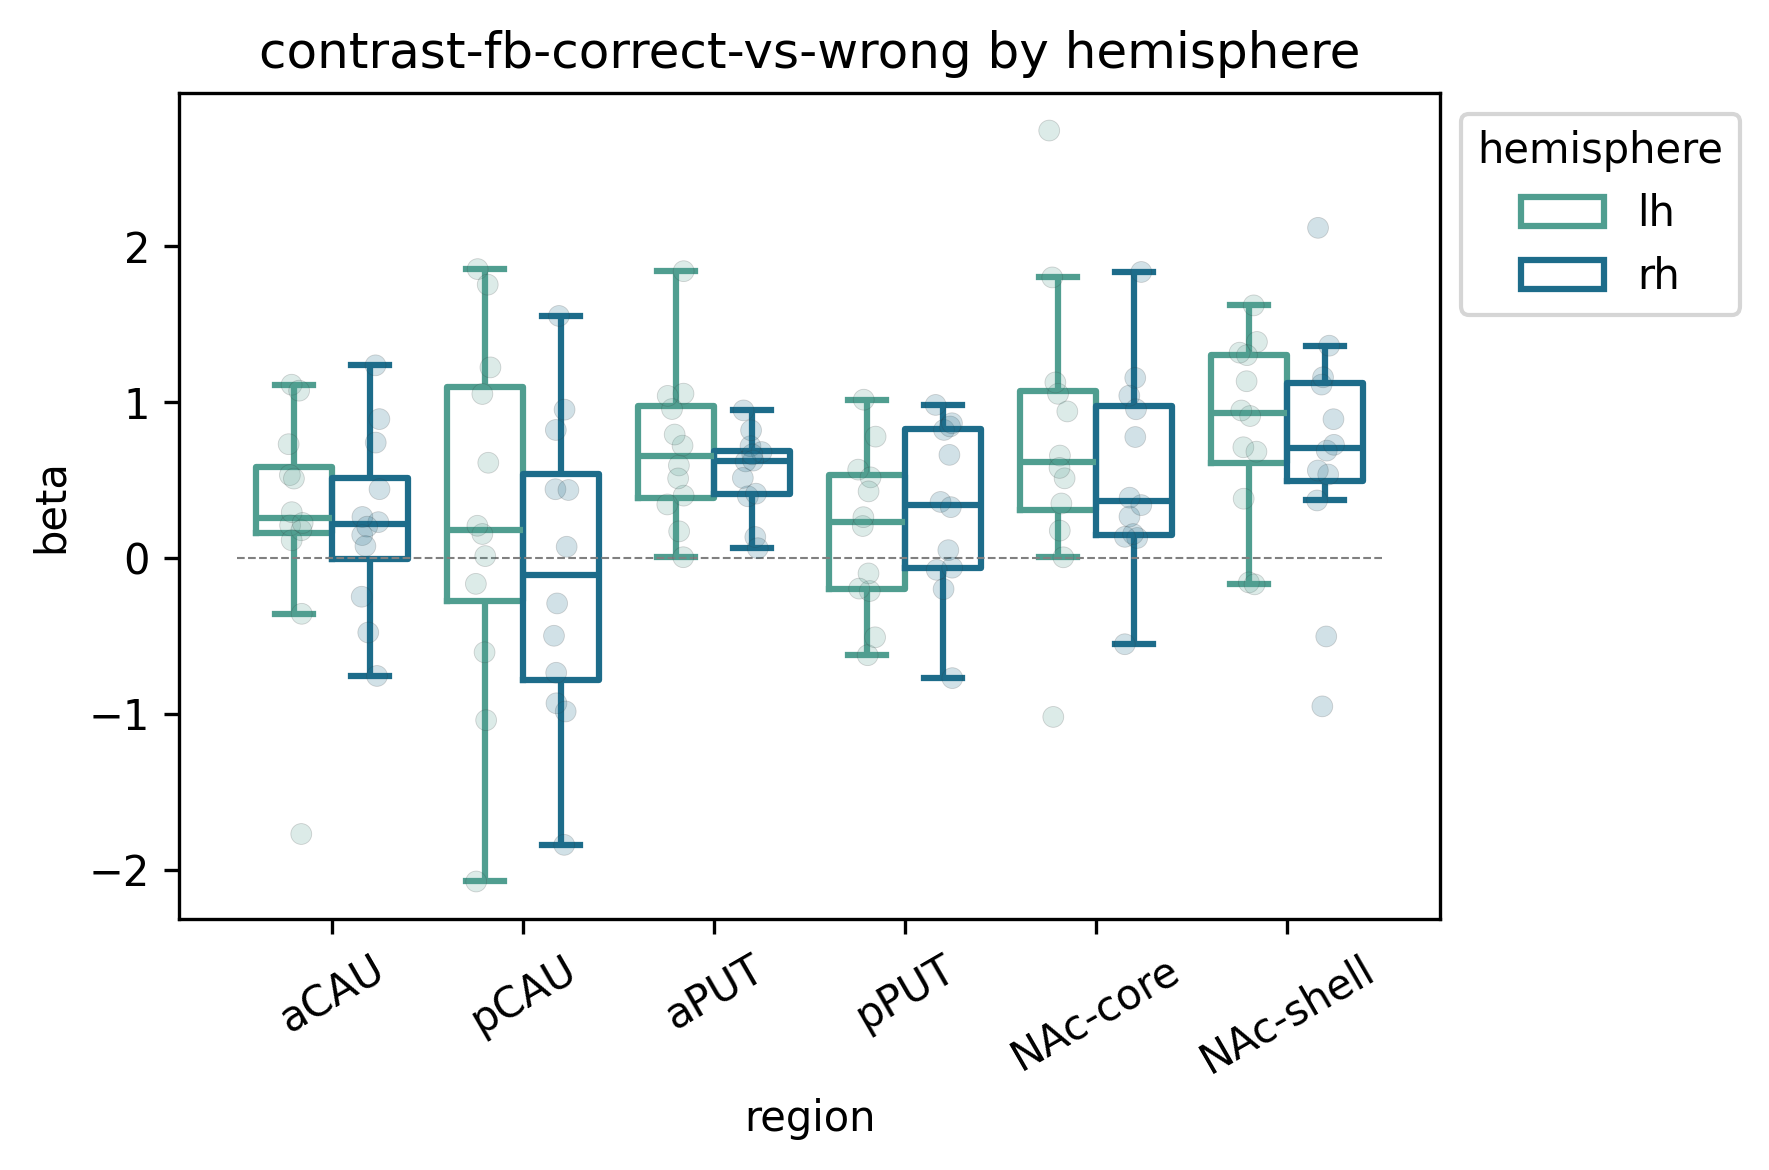

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'hemisphere'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='hemisphere', #hue_order=['early', 'middle', 'final'],
              order=plot_order,
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by hemisphere');
#ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

In [ ]:
non_mandarin_df.head()

In [ ]:
non_mandarin_df.participant_id.unique()

In [91]:
# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','Axis', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
aov.summary()

network: tian-S2
contrast: fb-correct-vs-wrong


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/stats/anova.py:508: FutureWarning: The provided callable <function mean at 0x7f01540ca4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  self.data = (self.data
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Anova
============================================================
                               F Value Num DF  Den DF Pr > F
------------------------------------------------------------
hemisphere                      2.2372 1.0000 11.0000 0.1628
learning_stage                  3.9676 2.0000 22.0000 0.0338
Axis                            4.4493 2.0000 22.0000 0.0238
hemisphere:learning_stage       0.5815 2.0000 22.0000 0.5674
hemisphere:Axis                 0.3539 2.0000 22.0000 0.7059
learning_stage:Axis             1.0227 4.0000 44.0000 0.4062
hemisphere:learning_stage:Axis  0.3561 4.0000 44.0000 0.8384
============================================================

"""

In [92]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['Axis', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
#pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-unc'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast Contrast        A        B         T   dof     p-unc    p-corr  \
0     Axis     Axis   Caudal  Rostral -2.000294  11.0  0.070768  0.070768   
1     Axis     Axis   Caudal  Ventral -2.143736  11.0  0.055245  0.070768   
2     Axis     Axis  Rostral  Ventral -2.090744  11.0  0.060563  0.070768   

    BF10  
0  1.275  
1  1.537  
2  1.434

In [93]:
# pairwise by learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
#pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-unc'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast        Contrast      A       B         T   dof     p-unc  \
0  learning_stage  learning_stage  early   final  3.241245  11.0  0.007857   
1  learning_stage  learning_stage  early  middle  2.086492  11.0  0.061010   
2  learning_stage  learning_stage  final  middle -0.147325  11.0  0.885541   

     p-corr   BF10  
0  0.023570  7.201  
1  0.091514  1.426  
2  0.885541   0.29

In [94]:
# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
aov.summary()

network: tian-S2
contrast: fb-correct-vs-wrong


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Anova
================================================================
                                 F Value  Num DF  Den DF  Pr > F
----------------------------------------------------------------
hemisphere                        2.2372  1.0000  11.0000 0.1628
learning_stage                    3.9676  2.0000  22.0000 0.0338
region                            2.6461  5.0000  55.0000 0.0325
hemisphere:learning_stage         0.5815  2.0000  22.0000 0.5674
hemisphere:region                 1.4170  5.0000  55.0000 0.2326
learning_stage:region             1.6668 10.0000 110.0000 0.0976
hemisphere:learning_stage:region  0.8982 10.0000 110.0000 0.5375
================================================================

"""

In [95]:
import pingouin as pg

# Pairwise comparisons for region with FDR correction
pairwise_by_learning_stage = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage','region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_learning_stage.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_learning_stage)
#pairwise_by_learning_stage[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_learning_stage[pairwise_by_learning_stage.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-corr'] < 0.05].reset_index()
pairwise_interaction[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'learning_stage', 'A', 'B', 'Paired', 'Parametric', 'T',
       'dof', 'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Empty DataFrame
Columns: [Contrast, learning_stage, A, B, T, dof, p-unc, p-corr, BF10]
Index: []

In [96]:
# pairwise by region

# Pairwise comparisons for region with FDR correction
pairwise_by_region = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', 'learning_stage',],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region)
#pairwise_by_region[['Contrast', 'learning_stage', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns

pd.set_option('display.max_rows', None)

pairwise_interaction = pairwise_by_region[pairwise_by_region.Contrast.str.contains(' * ')].reset_index()
pairwise_interaction = pairwise_interaction[pairwise_interaction['p-unc'] < 0.05]
pairwise_interaction[['Contrast', 'region', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]

Available columns: Index(['Contrast', 'region', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof',
       'alternative', 'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast     region      A       B         T   dof  \
3   region * learning_stage  NAc-shell  early   final  2.461387  11.0   
6   region * learning_stage       aCAU  early   final  4.031397  11.0   
13  region * learning_stage       pCAU  early  middle  3.322981  11.0   
15  region * learning_stage       pPUT  early   final  2.335531  11.0   

       p-unc    p-corr    BF10  
3   0.031601  0.177670   2.364  
6   0.001977  0.035591  22.564  
13  0.006795  0.061158   8.109  
15  0.039482  0.177670   1.988

In [97]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['region', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only = pairwise_by_region_only[pairwise_by_region_only['p-unc'] < 0.05]
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast Contrast          A     B         T   dof     p-unc    p-corr  \
1    region   region   NAc-core  aCAU  2.527991  11.0  0.028074  0.140368   
5    region   region  NAc-shell  aCAU  3.499669  11.0  0.004973  0.054200   
8    region   region  NAc-shell  pPUT  2.302753  11.0  0.041829  0.156858   
13   region   region       aPUT  pPUT  3.288291  11.0  0.007227  0.054200   

     BF10  
1   2.594  
5   10.48  
8   1.902  
13   7.71

#### Collapse (average) over non-significant factors

In [98]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})


In [99]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region_stage, data in roi_df_collapsed.groupby(['learning_stage', "region",]):
    #print(region_stage)
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region_stage[0], region_stage[1], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, stage: {stage}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: early, stage: NAc-core, t = 2.72; corrected p = 0.0396
Region: early, stage: NAc-shell, t = 3.91; corrected p = 0.0147
Region: early, stage: aCAU, t = 3.12; corrected p = 0.0310
Region: early, stage: aPUT, t = 4.83; corrected p = 0.0047
Region: early, stage: pCAU, t = 3.09; corrected p = 0.0310
Region: early, stage: pPUT, t = 2.76; corrected p = 0.0396
Region: final, stage: NAc-core, t = 1.88; corrected p = 0.1295
Region: final, stage: NAc-shell, t = 1.97; corrected p = 0.1227
Region: final, stage: aCAU, t = -0.69; corrected p = 0.6078
Region: final, stage: aPUT, t = 3.33; corrected p = 0.0302
Region: final, stage: pCAU, t = -0.13; corrected p = 0.9698
Region: final, stage: pPUT, t = -0.06; corrected p = 0.9698
Region: middle, stage: NAc-core, t = 2.39; corrected p = 0.0641
Region: middle, stage: NAc-shell, t = 5.42; corrected p = 0.0038
Region: middle, stage: aCAU, t = -0.04; corrected p = 0.9698
Region: middle, stage: aPUT, t = 2.73; corrected p = 0.0396
Region: middle, stage

In [101]:
# Compare early vs. final
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})

# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region_stage, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_rel(data[data.learning_stage=='final']['beta'], 
                              data[data.learning_stage=='early']['beta'])
    p_values.append(p_val)
    comparisons.append((region_stage[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, final vs. early stage, t = {t_stat:.2f} ; corrected p = {p_val_corr:.4f}")



Region: NAc-core, final vs. early stage, t = -0.14 ; corrected p = 0.8916
Region: NAc-shell, final vs. early stage, t = -2.46 ; corrected p = 0.0790
Region: aCAU, final vs. early stage, t = -4.03 ; corrected p = 0.0119
Region: aPUT, final vs. early stage, t = -0.50 ; corrected p = 0.7521
Region: pCAU, final vs. early stage, t = -1.81 ; corrected p = 0.1470
Region: pPUT, final vs. early stage, t = -2.34 ; corrected p = 0.0790


In [30]:
# Collapse/ignore learning stage
roi_df_collapsed_stage = roi_df_long.groupby(["participant_id", "region"], 
                                       as_index=False).agg({"beta": "mean"})

# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed_stage.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: NAc-core, t = 3.05; corrected p = 0.0221
Region: NAc-shell, t = 3.91; corrected p = 0.0073
Region: aCAU, t = 1.30; corrected p = 0.2659
Region: aPUT, t = 6.42; corrected p = 0.0003
Region: pCAU, t = 0.28; corrected p = 0.7813
Region: pPUT, t = 1.72; corrected p = 0.1690


### Make 3D plots

In [38]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region_hemi"], 
                                       as_index=False).agg({"beta": "mean"})

# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region_hemi"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: CAU-DA-lh, t = 2.25; corrected p = 0.0824
Region: CAU-DA-rh, t = 1.06; corrected p = 0.4292
Region: CAU-VA-lh, t = 0.19; corrected p = 0.8535
Region: CAU-VA-rh, t = 1.56; corrected p = 0.2424
Region: NAc-core-lh, t = 2.76; corrected p = 0.0374
Region: NAc-core-rh, t = 3.04; corrected p = 0.0337
Region: NAc-shell-lh, t = 5.00; corrected p = 0.0024
Region: NAc-shell-rh, t = 2.88; corrected p = 0.0374
Region: PUT-DA-lh, t = 3.77; corrected p = 0.0112
Region: PUT-DA-rh, t = 4.06; corrected p = 0.0085
Region: PUT-DP-lh, t = 0.80; corrected p = 0.5287
Region: PUT-DP-rh, t = 1.01; corrected p = 0.4292
Region: PUT-VA-lh, t = 5.63; corrected p = 0.0014
Region: PUT-VA-rh, t = 8.09; corrected p = 0.0001
Region: PUT-VP-lh, t = 1.06; corrected p = 0.4292
Region: PUT-VP-rh, t = 2.80; corrected p = 0.0374
Region: pCAU-lh, t = 0.75; corrected p = 0.5293
Region: pCAU-rh, t = -0.30; corrected p = 0.8163


In [39]:
region_list = region_dict[network_name]

mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [42]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('Reds') # 'coolwarm', 'Reds'

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        yaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        zaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    #title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_network-{network_name}_surface.svg')
clear_output()

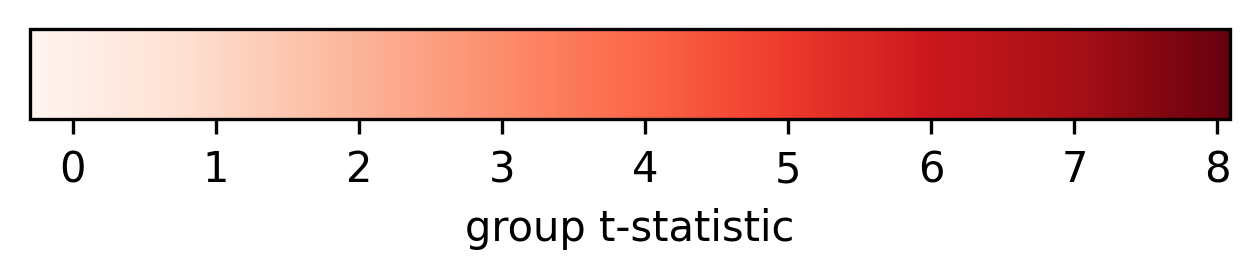

In [43]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
#cbar.ax.get_yaxis().labelpad = 15
plt.savefig(f"out-figure_group-all_contrast-{contrast_label}_network-{network_name}_colorbar.svg")

### Make 3D plots - early - final runs

In [ ]:
p_values

In [ ]:
from scipy.stats import ttest_rel

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region_hemi", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})

# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region_stage, data in roi_df_collapsed.groupby(["region_hemi"]):
    t_stat, p_val = ttest_rel(data[data.learning_stage=='final']['beta'], 
                              data[data.learning_stage=='early']['beta'])
    p_values.append(p_val)
    comparisons.append((region_stage[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, final vs. early stage, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")



In [ ]:
region_list = region_dict[network_name]

mask_dict = dict(zip(mask_path_list, 
                     range(1,len(mask_path_list)+1)))

stat_dict = dict(zip(range(1,len(t_stats)+1), 
                     t_stats))

from matplotlib import cm

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('coolwarm')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

In [60]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('Blues_r') # 'coolwarm', 'Reds'

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        yaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        zaxis=dict(title=None, showbackground=False, linecolor='rgba(0,0,0,0)', 
                   showgrid=False, showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    #title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_rungroup-final_network-{network_name}_surface.svg')
clear_output()

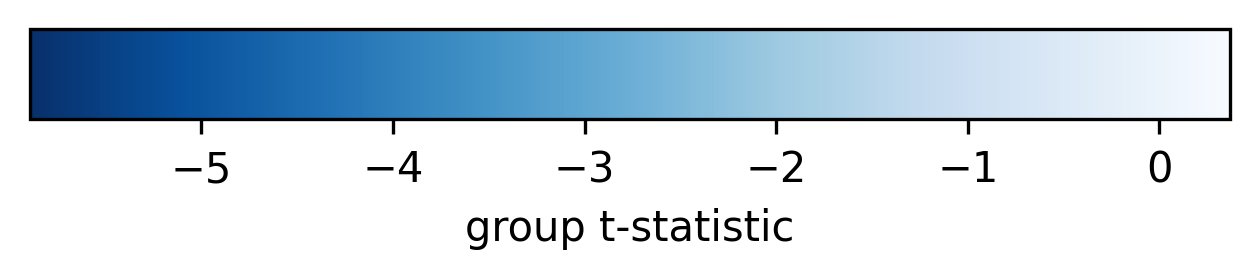

In [61]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(5, 0.5), dpi=300)
img = plt.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#cbar = plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
plt.colorbar(orientation="horizontal", cax=cax, label='group t-statistic')
#cbar.ax.get_yaxis().labelpad = 15
plt.savefig(f"out-figure_group-all_contrast-{contrast_label}_rungroup-final_network-{network_name}_colorbar.svg")

## `contrast-fb` for cortical network

In [20]:
# get the beta map for the contrast of interest for each subject
network_name = network_list[0]
contrast_label = contrast_list[2]
print('network_name:', network_name)
print('contrast_label:', contrast_label)

statmap_earlythird_dict = {}
for sub_id in sub_list_nman:
    statmap_earlythird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/earlythird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_middlethird_dict = {}
for sub_id in sub_list_nman:
    statmap_middlethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/middlethird/*{contrast_label}_map-beta.nii.gz'))[0]
    
statmap_latethird_dict = {}
for sub_id in sub_list_nman:
    statmap_latethird_dict[sub_id] = sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/grouped_runs/latethird/*{contrast_label}_map-beta.nii.gz'))[0]

network_name: auditory
contrast_label: fb-correct-vs-wrong


In [24]:
print(f'masking {contrast_label} stat maps for the {network_name} network')

print(f'creating dictionary for early learning stage')
roi_earlythird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_earlythird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

print(f'creating dictionary for middle learning stage')
roi_middlethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_middlethird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

print(f'creating dictionary for final learning stage')
roi_latethird_mean_dict, mask_path_list = mask_stat_maps(region_dict[network_name], 
                                               statmap_latethird_dict, 
                                               masks_dir, 
                                               'dseg',
                                               space_label)

masking fb-correct-vs-wrong stat maps for the auditory network
creating dictionary for early learning stage
L-HG
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT02/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT02_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT04/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT04_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT06/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT06_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT09/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT09_space-MNI152NLin2009cAsym_mask-L-HG.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/masks/sub-FLT11/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG.nii.

In [25]:
# add `learning_stage` column and combine into single dataframe
roi_earlythird_df_long = make_stats_df(roi_earlythird_mean_dict, participants_nman_df, network_name)
roi_earlythird_df_long['learning_stage'] = 'early'
roi_middlethird_df_long = make_stats_df(roi_middlethird_mean_dict, participants_nman_df, network_name)
roi_middlethird_df_long['learning_stage'] = 'middle'
roi_latethird_df_long = make_stats_df(roi_latethird_mean_dict, participants_nman_df, network_name)
roi_latethird_df_long['learning_stage'] = 'final'

roi_df_long = pd.concat([roi_earlythird_df_long, roi_middlethird_df_long, roi_latethird_df_long],)

In [26]:
non_mandarin_df = roi_df_long

/scratch/slurm-6658890/ipykernel_130690/1168370847.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


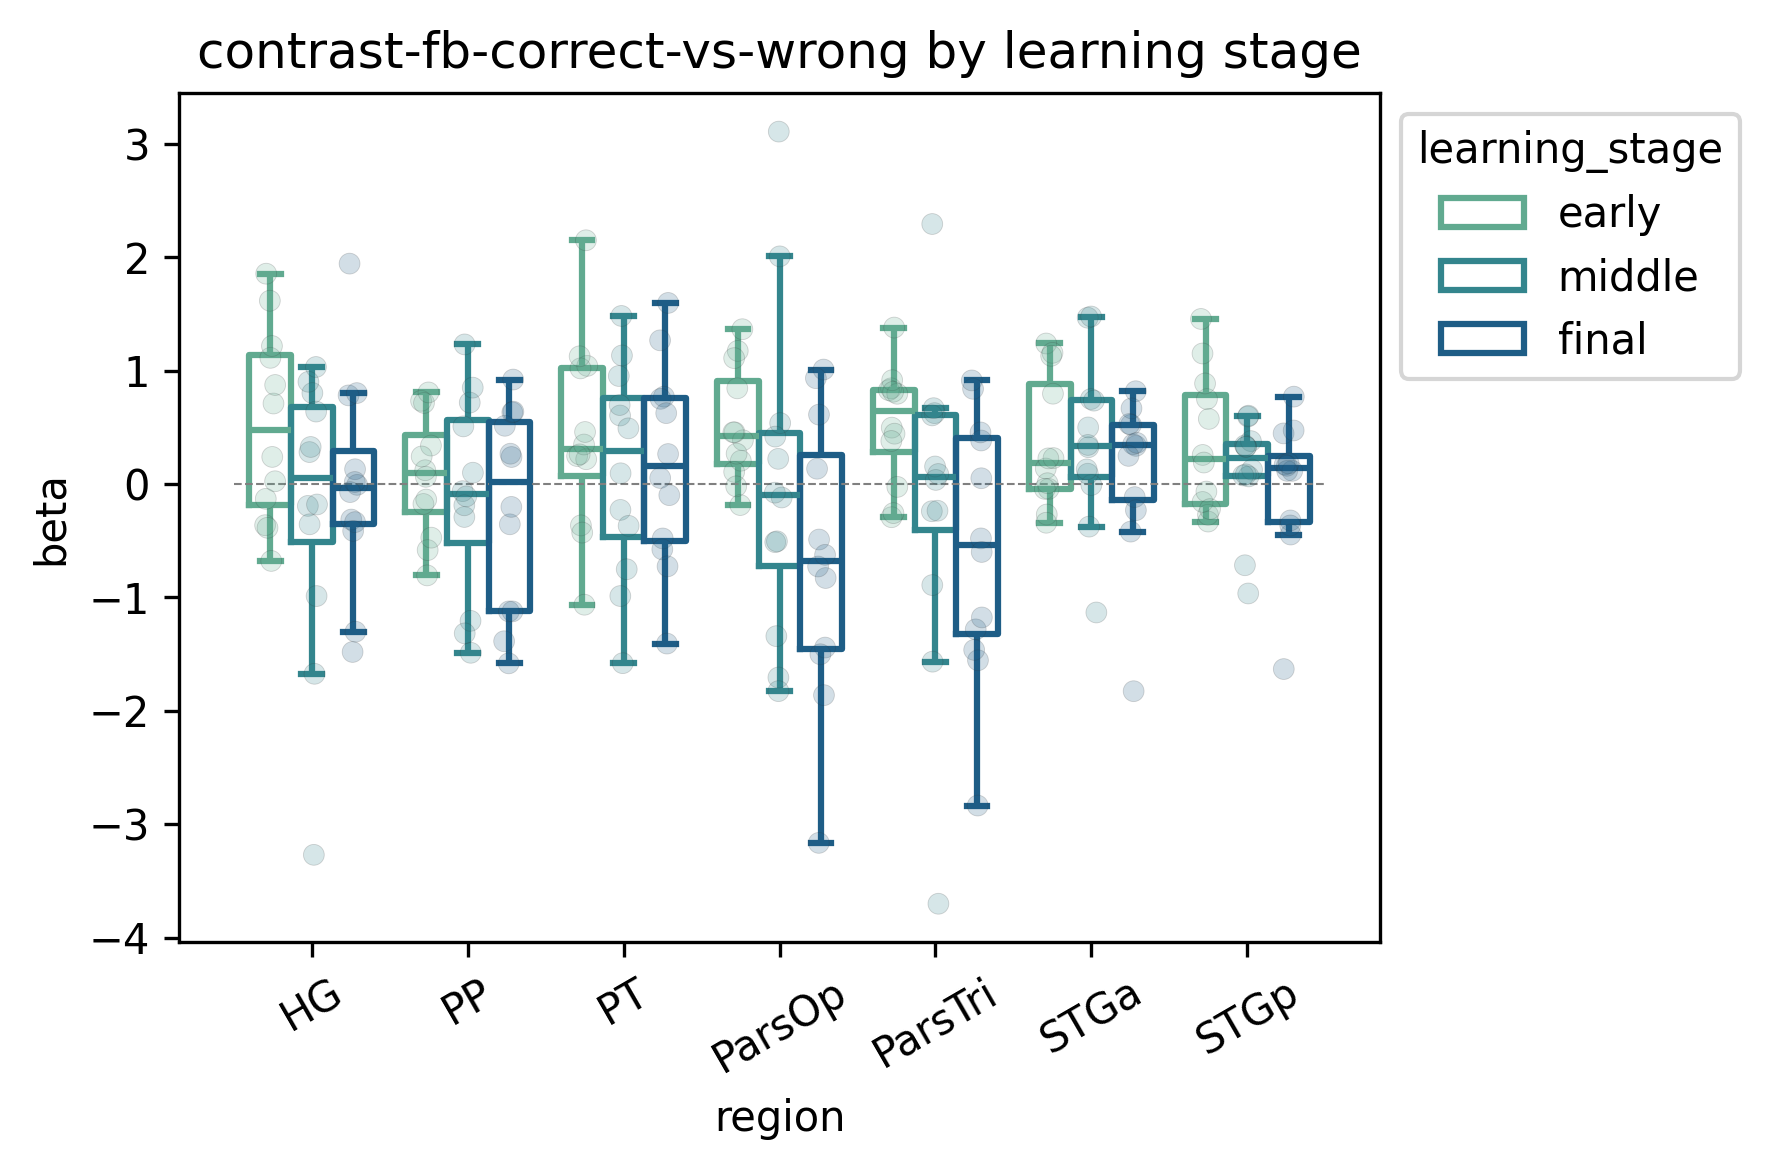

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=300)

roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})

sns.boxplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              palette='crest',
              fliersize = 0,            
              linewidth=1.5,
              fill=False,
              #legend=None,
              ax=ax);
sns.stripplot(data=roi_df_collapsed, 
              x='region', y='beta', 
              hue='learning_stage', hue_order=['early', 'middle', 'final'],
              palette='crest',
              dodge=True,
              linewidth=0.2,
              alpha=.2,
              legend=None,
              ax=ax);


xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title(f'contrast-{contrast_label} by learning stage');
#ax.set_ylim([-5, 5])

fig.tight_layout()


### omnibus ANOVA stats

In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Mixed-Effects ANOVA with Hemisphere, Region, and Interaction
aov = AnovaRM(non_mandarin_df, 
              aggregate_func='mean',
              depvar='beta', 
              subject='participant_id', 
              within=['hemisphere', 'learning_stage','region', ]).fit()

# Display results
print('network:', network_name)
print('contrast:', contrast_label)
print(aov)


network: auditory
contrast: fb-correct-vs-wrong
                             Anova
                                 F Value  Num DF  Den DF  Pr > F
----------------------------------------------------------------
hemisphere                        0.0132  1.0000  11.0000 0.9107
learning_stage                    3.6421  2.0000  22.0000 0.0430
region                            1.4349  6.0000  66.0000 0.2147
hemisphere:learning_stage         1.3513  2.0000  22.0000 0.2796
hemisphere:region                 1.0940  6.0000  66.0000 0.3753
learning_stage:region             1.0788 12.0000 132.0000 0.3830
hemisphere:learning_stage:region  0.5993 12.0000 132.0000 0.8397



/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [29]:
aov.summary().tables[0]

F Value  Num DF  Den DF    Pr > F
hemisphere                        0.013185     1.0    11.0  0.910654
learning_stage                    3.642107     2.0    22.0  0.043021
region                            1.434900     6.0    66.0  0.214729
hemisphere:learning_stage         1.351300     2.0    22.0  0.279563
hemisphere:region                 1.094013     6.0    66.0  0.375323
learning_stage:region             1.078821    12.0   132.0  0.383011
hemisphere:learning_stage:region  0.599261    12.0   132.0  0.839694

In [30]:
# pairwise by region, no learning stage

# Pairwise comparisons for region with FDR correction
pairwise_by_region_only = pg.pairwise_tests(data=non_mandarin_df,
                             dv='beta', 
                             within=['learning_stage', ],
                             subject='participant_id',
                             padjust='fdr') 

# Check available columns
print("Available columns:", pairwise_by_region_only.columns)

# Display key columns (without 'effsize' and 'CIs' if missing)
print("\nPost-hoc Pairwise Comparisons:")
#print(pairwise_by_region_only)
pairwise_by_region_only[['Contrast', 'Contrast', 'A', 'B', 'T', 'dof', 'p-unc', 'p-corr', 'BF10']]  # Keep only available columns


Available columns: Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges'],
      dtype='object')

Post-hoc Pairwise Comparisons:


Contrast        Contrast      A       B         T   dof     p-unc  \
0  learning_stage  learning_stage  early   final  2.504413  11.0  0.029276   
1  learning_stage  learning_stage  early  middle  1.666047  11.0  0.123894   
2  learning_stage  learning_stage  final  middle -1.014280  11.0  0.332240   

     p-corr   BF10  
0  0.087827   2.51  
1  0.185841  0.847  
2  0.332240  0.442

#### Collapse (average) over non-significant factors

In [31]:
roi_df_collapsed = roi_df_long.groupby(["participant_id", "region", 'learning_stage'], 
                                       as_index=False).agg({"beta": "mean"})


In [32]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_1samp


# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region_stage, data in roi_df_collapsed.groupby(["region",'learning_stage']):
    #print(region_stage)
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region_stage[0], region_stage[1], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, stage, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, stage: {stage}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: HG, stage: early, t = 2.09; corrected p = 0.2710
Region: HG, stage: final, t = -0.08; corrected p = 0.9669
Region: HG, stage: middle, t = -0.62; corrected p = 0.8032
Region: PP, stage: early, t = 0.47; corrected p = 0.8032
Region: PP, stage: final, t = -0.83; corrected p = 0.8032
Region: PP, stage: middle, t = -0.41; corrected p = 0.8032
Region: PT, stage: early, t = 1.71; corrected p = 0.2710
Region: PT, stage: final, t = 0.67; corrected p = 0.8032
Region: PT, stage: middle, t = 0.48; corrected p = 0.8032
Region: ParsOp, stage: early, t = 3.57; corrected p = 0.0464
Region: ParsOp, stage: final, t = -1.86; corrected p = 0.2710
Region: ParsOp, stage: middle, t = 0.04; corrected p = 0.9669
Region: ParsTri, stage: early, t = 3.59; corrected p = 0.0464
Region: ParsTri, stage: final, t = -1.71; corrected p = 0.2710
Region: ParsTri, stage: middle, t = -0.43; corrected p = 0.8032
Region: STGa, stage: early, t = 2.13; corrected p = 0.2710
Region: STGa, stage: final, t = 0.51; corrected

In [33]:
# Collect p-values
p_values = []
t_stats = []
comparisons = []

for region, data in roi_df_collapsed.groupby(["region"]):
    t_stat, p_val = ttest_1samp(data["beta"], 0)
    p_values.append(p_val)
    comparisons.append((region[0], t_stat))
    t_stats.append(t_stat)

# Apply FDR correction
_, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Print corrected results
for (region, t_stat), p_val_corr in zip(comparisons, p_corrected):
    print(f"Region: {region}, t = {t_stat:.2f}; corrected p = {p_val_corr:.4f}")


Region: HG, t = 0.51; corrected p = 0.8298
Region: PP, t = -0.64; corrected p = 0.8298
Region: PT, t = 1.65; corrected p = 0.3400
Region: ParsOp, t = -0.22; corrected p = 0.8298
Region: ParsTri, t = -0.37; corrected p = 0.8298
Region: STGa, t = 2.45; corrected p = 0.1354
Region: STGp, t = 1.49; corrected p = 0.3400
